# Applied Master Project - Portfolio Insurance: OBPI vs CPPI

### MSc Financial Engineering

Ugo ESCATO  
Aurore CLEVENOT  
Ludovic VINCENTI

# Librairies used

In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew, kurtosis, jarque_bera
from arch import arch_model
from scipy import stats

np.random.seed(123)

# Data

In [2]:
btc_data = yf.download('BTC-USD')
btc_daily = btc_data['Close'][:'2025-02']
btc_weekly = btc_daily.resample('W').last()
btc_monthly = btc_daily.resample('ME').last()

# Extract the date range from the BTC data
start_date = btc_daily.index.min().strftime('%Y-%m-%d')
end_date = btc_daily.index.max().strftime('%Y-%m-%d')

# Download the US T-bill rate for the same period
t_bill_data = yf.download('^IRX', start=start_date, end=end_date)
t_bill_adj_close = t_bill_data['Close']

# Reindex T-bill data to match Bitcoin dates
t_bill_adj_close_reindexed = t_bill_adj_close.reindex(btc_daily.index)

# Interpolate missing T-bill rates
t_bill_daily = t_bill_adj_close_reindexed.interpolate(method='linear')
t_bill_weekly = t_bill_daily.resample('W').last()
t_bill_monthly = t_bill_daily.resample('ME').last()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
initial_portfolio_value = 100000  
multipliers = [1, 2, 3, 4, 5, 6]  # Array of multipliers
floor_fractions = [0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Array of floor fractions (for CPPI), and strikes (for OBPI)

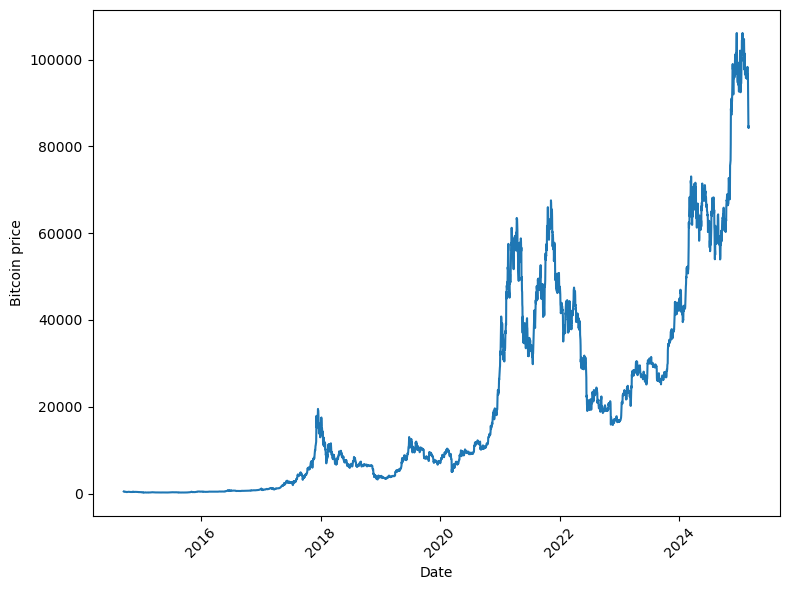

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(btc_daily)
plt.xlabel('Date')
plt.ylabel('Bitcoin price')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

# Calibration

## Normality check

In [5]:
btc_returns = btc_daily.pct_change().dropna()

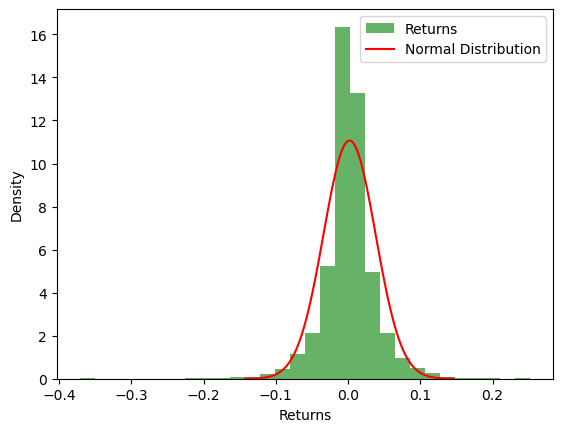

In [6]:
plt.hist(btc_returns, bins=30, density=True, alpha=0.6, color='g', label="Returns")

# Overlay normal distribution
mu, std = np.mean(btc_returns), np.std(btc_returns, axis=0)
x = np.linspace(mu - 4*std, mu + 4*std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std), 'r', label="Normal Distribution")

# plt.title("Histogram of Returns with Normal Curve")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

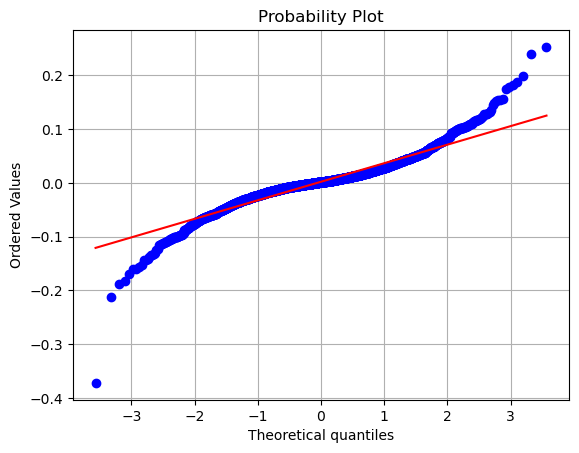

In [7]:
stats.probplot(btc_returns.values.flatten(), dist='norm', plot=plt)
#plt.title('Normal Probability Plot (Q-Q Plot)')
plt.grid(True)
plt.show()

In [8]:
skewness = skew(btc_returns)
kurt = kurtosis(btc_returns)
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

if abs(skewness) < 0.5 and abs(kurt - 3) < 1:
    print("Returns are approximately normally distributed.")
else:
    print("Returns are NOT normally distributed.")

Skewness: [-0.11085545]
Kurtosis: [7.60254767]
Returns are NOT normally distributed.


In [9]:
# Jarque-Bera test
stat, p = jarque_bera(btc_returns)
print(f"Jarque-Bera Test: Statistic={stat}, p-value={p}")

alpha = 0.05
if p > alpha:
    print("Fail to reject the null hypothesis: Returns are normally distributed.")
else:
    print("Reject the null hypothesis: Returns are NOT normally distributed.")

Jarque-Bera Test: Statistic=9200.224341408677, p-value=0.0
Reject the null hypothesis: Returns are NOT normally distributed.


As expected, Bitcoin returns do not follow a normal distribution. While the skewness is modest, the returns exhibit heavy tails (high kurtosis), indicating that a normal distribution would underestimate extreme upward and downward movements. For now, we will continue using a GBM for our simulations, incorporating EGARCH to model volatility and capture fat tails. Later, we will address this limitation by adopting more realistic distributions.

## Simulations using GBM

In [10]:
def simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations):
    """
    Simulates asset price evolution using Geometric Brownian Motion (GBM) with time-varying volatility.

    Parameters:
        initial_price (float): Current asset price.
        mu (float): Drift (mean return).
        sigma (float or np.ndarray): Volatility (constant float or array of shape (total_steps,)).
        time_horizon (float): Time horizon in years.
        steps_per_year (int): Number of time steps per year (e.g., 252 for daily steps).
        num_simulations (int): Number of Monte Carlo simulations.

    Returns:
        np.ndarray: Simulated price paths of shape (steps + 1, simulations).
    """
    dt = 1 / steps_per_year
    total_steps = int(time_horizon * steps_per_year)
    
    # Ensure sigma is an array of shape (total_steps,)
    if np.isscalar(sigma):
        sigma = np.full(total_steps, sigma)  
    elif len(sigma) != total_steps:
        raise ValueError("sigma must be a scalar or an array of length equal to total_steps.")
    
    # Initialize price paths
    price_paths = np.zeros((total_steps, num_simulations))
    price_paths[0] = initial_price  # Set initial price
    
    # Simulate GBM paths with time-varying sigma
    for t in range(1, total_steps):
        z = np.random.standard_normal(num_simulations)  # Random shocks
        
        # GBM formula with time-dependent sigma 
        price_paths[t] = price_paths[t - 1] * np.exp(
            (mu - 0.5 * sigma[t - 1]**2) * dt + sigma[t - 1] * np.sqrt(dt) * z
        )
    
    return price_paths

### Historical volatility

In [11]:
def calculate_mean_and_volatility(returns):
    simple_returns = returns.pct_change().dropna()
    log_returns = np.log(returns / returns.shift(1)).dropna()

    mean = simple_returns.mean() * 365
    volatility = log_returns.std() * np.sqrt(365)
    
    return mean, volatility

In [12]:
historical_mean, historical_volatility = calculate_mean_and_volatility(btc_daily)
historical_sharpe_ratio = historical_mean/historical_volatility

print(f"Mean (Simple Returns): {historical_mean}")
print(f"Volatility (Log Returns): {historical_volatility}")
print(f'Sharpe Ratio: {historical_sharpe_ratio}')

Mean (Simple Returns): Ticker
BTC-USD    0.737998
dtype: float64
Volatility (Log Returns): Ticker
BTC-USD    0.693099
dtype: float64
Sharpe Ratio: Ticker
BTC-USD    1.06478
dtype: float64


In [13]:
initial_price = btc_daily.iloc[-1]  
mu = historical_mean.iloc[0]  # Drift (annualized mean return) 
sigma = historical_volatility.iloc[0]  # Volatility (annualized standard deviation)
time_horizon = 1  # in year
steps_per_year = 365  # 365 for daily, 52 for weekly
num_simulations = 1000  

price_paths = simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

In [14]:
price_paths.shape

(365, 1000)

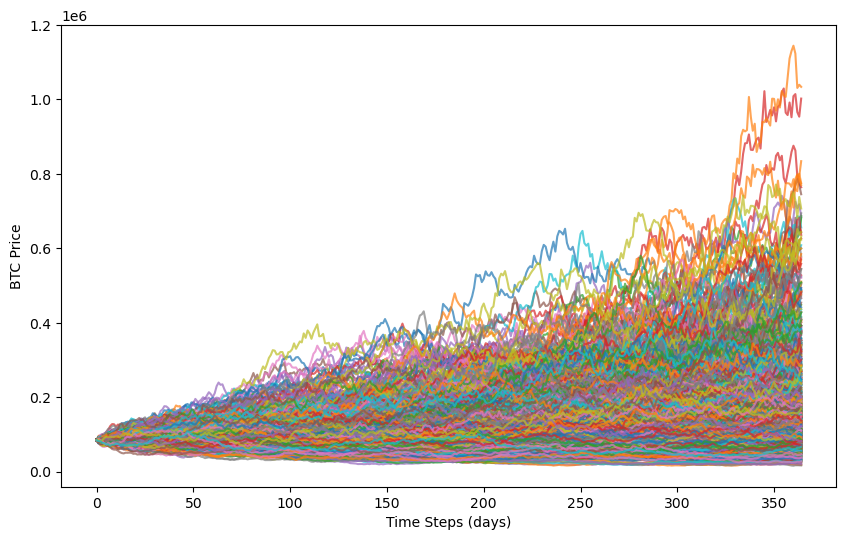

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(price_paths, alpha=0.7)
# plt.title("Simulated BTC Price Paths (GBM, Constant Volatility)")
plt.xlabel("Time Steps (days)")
plt.ylabel("BTC Price")
plt.show()

#### CPPI

In [16]:
def cppi_strategy(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy for multiple combinations
    of multiplier and floor_fraction values.

    Parameters:
        risky_asset (ndarray): Prices of the risky asset (e.g., BTC), shape (n_steps, n_simulations).
        riskless_rate (float): The constant annual risk-free rate (e.g., 0.02 for 2%).
        multipliers (array-like): Array of multipliers for the cushion.
        floor_fractions (array-like): Array of floor fractions of the initial portfolio value.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing results for each (multiplier, floor_fraction) combination.
    """

    n_steps, n_simulations = risky_asset.shape
    riskless_return = (1 + riskless_rate) ** (1 / 365) - 1

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            # Initialize arrays
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))

            # Initial conditions
            basket_values[0] = initial_portfolio_value
            floor = initial_portfolio_value * floor_fraction

            # Compute the initial cushion
            initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
            
            risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
            riskless_weights[0] = 1 - risky_weights[0]

            # CPPI dynamics for each time step
            for t in range(1, n_steps):
                # Compute risky returns
                risky_returns = (risky_asset[t] - risky_asset[t - 1]) / risky_asset[t - 1]

                # Portfolio return: combine risky and riskless returns
                port_returns = (risky_weights[t-1] * risky_returns + 
                               riskless_weights[t-1] * riskless_return)
                
                # Update portfolio value
                basket_values[t] = basket_values[t-1] * (1 + port_returns)
                
                # Update weights
                cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                risky_weights[t] = np.maximum(multiplier * cushion, 0)
                riskless_weights[t] = 1 - risky_weights[t]

            # Store the results for the current multiplier and floor_fraction
            results[(multiplier, floor_fraction)] = {
                'Basket Values': basket_values,
                'Risky Weights': risky_weights,
                'Riskless Weights': riskless_weights
            }

    return results

In [17]:
cppi_results = cppi_strategy(price_paths, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [18]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_cppi = cppi_results[key]['Basket Values'][-1]  # Last row of CPPI basket values

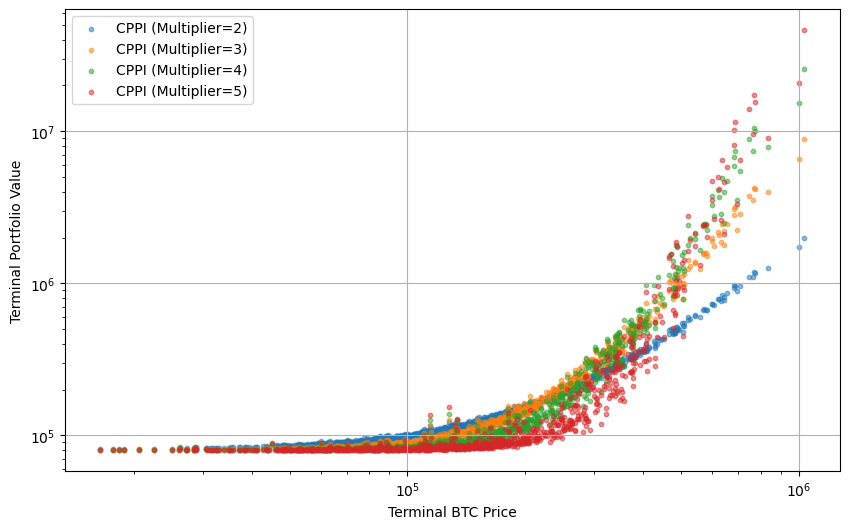

In [19]:
# Define floor fraction and multipliers
floor_frac = 0.8  # Example value
multiplier_values = [2,3,4,5]  # Use the existing multipliers array

# Plot terminal prices and CPPI values with multiplier varying
plt.figure(figsize=(10, 6))
for multiplier2 in multiplier_values:
    key = (multiplier2, floor_frac)
    if key in cppi_results:
        plt.scatter(terminal_prices, cppi_results[key]['Basket Values'][-1], 
                 label=f'CPPI (Multiplier={multiplier2})', 
                 alpha=0.5, s=10)
plt.xlabel('Terminal BTC Price')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Terminal Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

#### OBPI

In [20]:
def obpi_strategy(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions.

    Parameters:
        risky_asset (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized), 
                                  either a float (constant) or ndarray (n_steps, n_simulations).

    Returns:
        dict: Dictionary containing results for each floor fraction.
    """
    n_steps, n_simulations = risky_asset.shape
    steps_per_year = 365  # adjust
    riskless_return = (1 + riskless_rate) ** (1 / steps_per_year) - 1
    dt = 1 / steps_per_year  
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    # Ensure sigma is an array of correct shape (n_steps, n_simulations)
    if np.isscalar(sigma):
        sigma = np.full((n_steps, n_simulations), sigma)

    if sigma.shape != (n_steps, n_simulations):
        raise ValueError("sigma must be either a scalar or have shape (n_steps, n_simulations)")

    for floor_fraction in floor_fractions:
        # Initialize arrays
        basket_values = np.zeros((n_steps, n_simulations))
        risky_weights = np.zeros((n_steps, n_simulations))
        riskless_weights = np.zeros((n_steps, n_simulations))
        put_prices = np.zeros((n_steps, n_simulations))
        put_deltas = np.zeros((n_steps, n_simulations))

        # Initial conditions
        floor = initial_portfolio_value * floor_fraction

        # Compute initial put price and delta for all simulations
        initial_put_price, initial_put_delta = black_scholes_put(
            risky_asset[0], floor, time_to_maturity, riskless_rate, sigma[0]
        )

        # Compute initial weights
        risky_w = ((1 + initial_put_delta) * risky_asset[0]) / (risky_asset[0] + initial_put_price)
        risky_w = np.maximum(0, np.minimum(1, risky_w))
        riskless_w = 1 - risky_w

        # Set initial values
        basket_values[0, :] = initial_portfolio_value
        risky_weights[0, :] = risky_w
        riskless_weights[0, :] = riskless_w
        put_prices[0, :] = initial_put_price
        put_deltas[0, :] = initial_put_delta

        # Loop over time steps
        for i in range(1, n_steps):
            remaining_ttm = time_to_maturity - i * dt  

            # Compute returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]

            # Update portfolio value
            portfolio_return = (risky_weights[i - 1] * risky_return +
                                riskless_weights[i - 1] * riskless_return)
            basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

            # Compute new put option price and delta 
            put_price, put_delta = black_scholes_put(
                risky_asset[i], floor, remaining_ttm, riskless_rate, sigma[i]
            )

            # Update weights
            risky_w = ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)
            risky_w = np.maximum(0, np.minimum(1, risky_w))
            riskless_w = 1 - risky_w

            # Store values
            risky_weights[i] = risky_w
            riskless_weights[i] = riskless_w
            put_prices[i] = put_price
            put_deltas[i] = put_delta

        # Store results
        results[floor_fraction] = {
            "Basket Values": basket_values,
            "Risky Weights": risky_weights,
            "Riskless Weights": riskless_weights,
            "Put Price": put_prices,
            "Put Delta": put_deltas,
        }

    return results

In [21]:
time_to_maturity = len(price_paths)/365  # adjust (52 for weekly, 365 for daily)

obpi_results = obpi_strategy(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, historical_volatility.iloc[0])

In [22]:
floor_frac_obpi = 0.9
key = (floor_frac_obpi)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_obpi = obpi_results[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy and Hold

In [23]:
def buy_and_hold_strategy(price_paths, riskless_rate, initial_portfolio_value, time_to_maturity):
    """
    Implements a buy-and-hold strategy with a risky asset and a riskless asset.

    Parameters:
        price_paths (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.

    Returns:
        dict: Dictionary containing portfolio values, risky asset values, and riskless asset values.
    """
    n_steps, n_simulations = price_paths.shape
    dt = time_to_maturity / (n_steps - 1)  # Time step in years

    # Initialize arrays
    portfolio_values = np.zeros((n_steps, n_simulations))
    risky_values = np.zeros((n_steps, n_simulations))
    riskless_values = np.zeros((n_steps, n_simulations))

    # Initial allocation
    risky_weight = 0.6
    riskless_weight = 0.4

    # Initial values
    risky_values[0, :] = initial_portfolio_value * risky_weight
    riskless_values[0, :] = initial_portfolio_value * riskless_weight
    portfolio_values[0, :] = initial_portfolio_value

    # Compute riskless asset growth over time
    time_steps = np.arange(n_steps) * dt  
    riskless_growth = (1 + riskless_rate) ** time_steps  # Cumulative growth of riskless asset
    riskless_asset_values = initial_portfolio_value * riskless_weight * riskless_growth[:, np.newaxis]

    # Compute risky asset growth 
    risky_initial_price = price_paths[0]  
    risky_asset_values = risky_values[0, :] * (price_paths / risky_initial_price)

    # Portfolio value is the sum of risky and riskless components
    portfolio_values = risky_asset_values + riskless_asset_values

    # Store results
    results = {
        "Basket Values": portfolio_values,
        "Risky Values": risky_asset_values,
        "Riskless Values": riskless_asset_values,
    }

    return results

In [24]:
bnh_results = buy_and_hold_strategy(
    price_paths=price_paths,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths)/365
)

In [25]:
terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_bnh = bnh_results['Basket Values'][-1]  # Last row of B&H basket values

##### Analysis

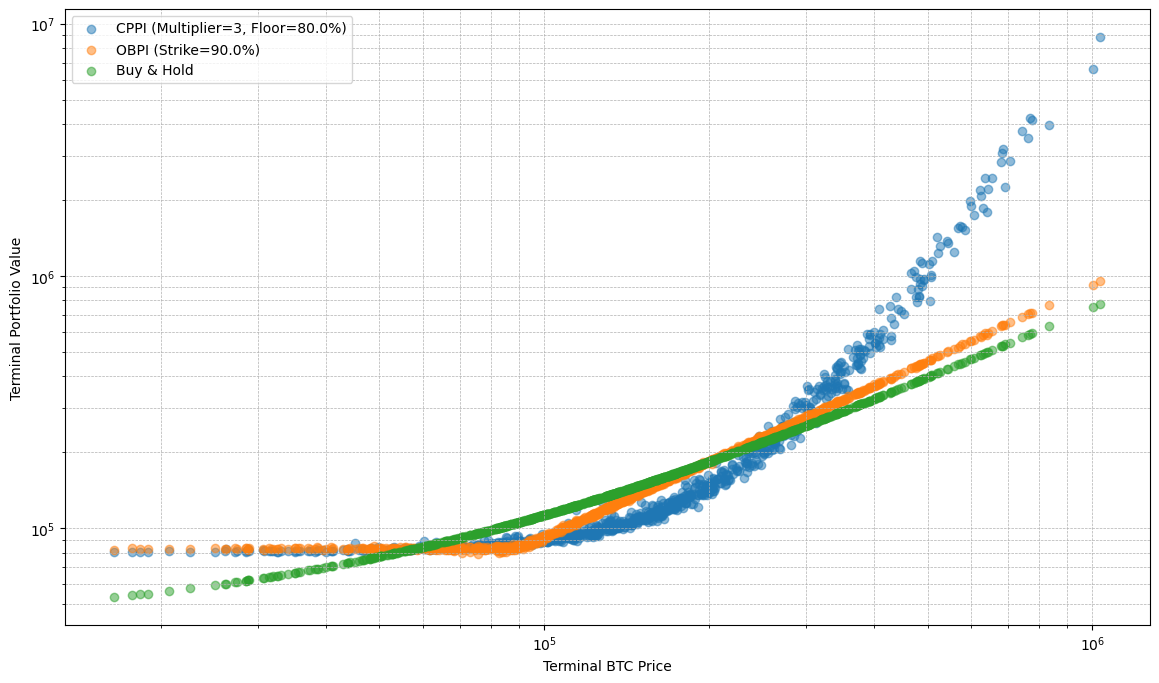

In [26]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Strike={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold')

#plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [27]:
# Define your parameters
multipliers_values2 = [2, 3, 4, 5]
floor_fractions_values2 = [0.7, 0.8, 0.9]
initial_value_2 = 100000  # or whatever your initial portfolio value is

# Initialize a matrix to store gap risk counts
gap_risk_matrix = np.zeros((len(multipliers_values2), len(floor_fractions_values2)))

# Loop through all combinations
for i, m in enumerate(multipliers_values2):
    for j, floor in enumerate(floor_fractions_values2):
        # Extract terminal portfolio values for this combo
        terminal_vals = cppi_results[(m, floor)]['Basket Values'][-1,:]

        floor_level = floor * initial_value_2
        gap_risk = terminal_vals < floor_level  # Boolean array

        # Count the number of True values
        gap_risk_matrix[i, j] = np.sum(gap_risk)
        print(f"Multiplier={m}, Floor={floor:.2f} -> Gap Risk Count = {int(gap_risk_matrix[i, j])}")

Multiplier=2, Floor=0.70 -> Gap Risk Count = 0
Multiplier=2, Floor=0.80 -> Gap Risk Count = 0
Multiplier=2, Floor=0.90 -> Gap Risk Count = 0
Multiplier=3, Floor=0.70 -> Gap Risk Count = 0
Multiplier=3, Floor=0.80 -> Gap Risk Count = 0
Multiplier=3, Floor=0.90 -> Gap Risk Count = 0
Multiplier=4, Floor=0.70 -> Gap Risk Count = 0
Multiplier=4, Floor=0.80 -> Gap Risk Count = 0
Multiplier=4, Floor=0.90 -> Gap Risk Count = 0
Multiplier=5, Floor=0.70 -> Gap Risk Count = 0
Multiplier=5, Floor=0.80 -> Gap Risk Count = 0
Multiplier=5, Floor=0.90 -> Gap Risk Count = 0


In [28]:
# Define your parameters
floor_fractions_values2 = [0.9, 1.0]
initial_value_2 = 100000  # or whatever your initial portfolio value is

# Initialize a matrix to store gap risk counts
gap_risk_matrix = np.zeros(len(floor_fractions_values2))

# Loop through all combinations
for j, floor in enumerate(floor_fractions_values2):
    # Extract terminal portfolio values for this combo
    terminal_vals = obpi_results[(floor)]['Basket Values'][-1,:]

    floor_level = 79100
    gap_risk = terminal_vals < floor_level  # Boolean array

    # Count the number of True values
    gap_risk_matrix[j] = np.sum(gap_risk)
    print(f"Floor={floor:.2f} -> Gap Risk Count = {int(gap_risk_matrix[j])}")

Floor=0.90 -> Gap Risk Count = 0
Floor=1.00 -> Gap Risk Count = 0


In [ ]:
def performance(portfolio_values, benchmark_prices, riskless_rate=0.04):
    """
    Calculate performance metrics for a portfolio across multiple simulations with benchmark.

    Parameters:
        portfolio_values (np.ndarray): Shape (n_steps, n_simulations), portfolio values over time.
        benchmark_prices (np.ndarray): Shape (n_steps, n_simulations), benchmark values over time.
        riskless_rate (float): Annual risk-free rate (e.g., 0.04).

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio,
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, max drawdown,
              and information ratio for path-level and distribution-level metrics.
    """
    portfolio_values = np.asarray(portfolio_values)
    benchmark_prices = np.asarray(benchmark_prices)

    if portfolio_values.shape != benchmark_prices.shape:
        raise ValueError("portfolio_values and benchmark_prices must have the same shape.")

    if portfolio_values.shape[0] < 2:
        raise ValueError("At least two time steps are required for performance calculation.")

    periods_per_year = 365

    # Calculate returns
    portfolio_returns = portfolio_values[1:, :] / portfolio_values[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
    benchmark_returns = benchmark_prices[1:, :] / benchmark_prices[:-1, :] - 1  # shape: (n_steps-1, n_simulations)

    total_returns = portfolio_values[-1, :] / portfolio_values[0, :] - 1  # shape: (n_simulations,)
    benchmark_total_returns = benchmark_prices[-1, :] / benchmark_prices[0, :] - 1  # shape: (n_simulations,)

    # === Path-level Metrics ===

    # Average Return
    avg_return = np.mean(total_returns)

    # Median Return
    median_return = np.median(total_returns)

    # Maximum and Minimum Returns
    max_return = np.max(total_returns)
    min_return = np.min(total_returns)

    # Volatility
    volatility = np.mean(np.std(portfolio_returns, axis=0, ddof=1)) * np.sqrt(periods_per_year)

    # Sharpe Ratio
    sharpe_ratio = (avg_return - riskless_rate) / volatility if volatility != 0 else np.nan

    # Sortino Ratio
    downside_returns = np.where(portfolio_returns < 0, portfolio_returns, 0)
    downside_std = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(periods_per_year)
    sortino_ratio = (avg_return - riskless_rate) / downside_std if downside_std != 0 else np.nan

    # Var and CVaR (5%)
    var_5 = np.percentile(portfolio_returns, 5, axis=0)
    cvar_5 = np.array([
        col[col <= v].mean() if np.any(col <= v) else np.nan
        for col, v in zip(portfolio_returns.T, var_5)
    ])
    var_5 = np.mean(var_5)
    cvar_5 = np.nanmean(cvar_5)

    # Skewness
    skewness = np.mean(skew(portfolio_returns, axis=0, bias=False))

    # Excess Kurtosis
    excess_kurtosis = np.mean(kurtosis(portfolio_returns, axis=0, fisher=True, bias=False))

    # === Max Drawdown ===
    cumulative = np.cumprod(1 + portfolio_returns, axis=0)  
    running_max = np.maximum.accumulate(cumulative, axis=0)
    drawdowns = (cumulative - running_max) / running_max
    max_drawdown = (np.min(drawdowns, axis=0)).mean()
    worst_max_drawdown = (np.min(drawdowns, axis=0)).min()

    # Tracking error
    tracking_error = np.std(portfolio_returns - benchmark_returns, axis=0, ddof=1) 
    tracking_error_mean = np.mean(tracking_error) * np.sqrt(periods_per_year)

    # Information Ratio
    active_returns = portfolio_returns - benchmark_returns
    active_returns_avg = np.mean(active_returns, axis=0)
    active_returns_tracking_error = np.std(active_returns, axis=0, ddof=1)
    information_ratio = np.mean(active_returns_avg / active_returns_tracking_error)
    
    # === Distribution Metrics ===

    # Volatility of the distribution
    volatility_distribution = np.std(total_returns)

    # Value at Risk (5%)
    var_5_distribution = np.percentile(total_returns, 5)

    # Expected Shortfall (Conditional VaR 5%)
    cvar_5_distribution = total_returns[total_returns <= var_5_distribution].mean() if np.any(total_returns <= var_5_distribution) else np.nan

    # Skewness
    skewness_distribution = skew(total_returns, bias=False)

    # Excess Kurtosis
    excess_kurtosis_distribution = kurtosis(total_returns, fisher=True, bias=False)

    return {
        "Average Return": avg_return,
        "Average Volatility": volatility,
        "Average Tracking Error": tracking_error_mean,
        "Average Sharpe Ratio": sharpe_ratio,
        "Average Sortino Ratio": sortino_ratio,
        "Average VaR 5%": var_5,
        "Average Expected Shortfall 5%": cvar_5,
        "Average Skewness": skewness,
        "Average Excess Kurtosis": excess_kurtosis,
        "Average Max Drawdown": max_drawdown,
        "Average Information Ratio": information_ratio,
        "---------------------------------------------": "Distribution Metrics",
        "Median Return": median_return,
        "Maximum Return": max_return,
        "Minimum Return": min_return,
        "Volatility Distribution": volatility_distribution,
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Max Drawdown": worst_max_drawdown,
    }

In [262]:
def turnover(w):
    """
    Compute the turnover for one or multiple simulations.
    
    - If input is 1D (shape (n_steps,)), treats it as one simulation and returns the turnover.
    - If input is 2D (shape (n_steps, n_simulations)), computes the turnover for each simulation 
      and returns the average turnover across simulations.
    
    Parameters:
    - w: Array-like, weights over time.
    
    Returns:
    - float: The turnover or average turnover.
    """
    w = np.asarray(w)
    
    if w.ndim == 1:
        w = w.reshape(-1, 1)
    elif w.ndim != 2:
        raise ValueError("Input must be 1D or 2D array")
    
    # Compute differences between consecutive weights 
    diffs = np.diff(w, axis=0)
    # Compute absolute values of differences
    abs_diffs = np.abs(diffs)
    # Sum absolute differences for each simulation
    turnovers = np.sum(abs_diffs, axis=0)
    # Compute the average turnover across simulations
    average_turnover = np.mean(turnovers)
    
    return average_turnover*100

In [287]:
benchmark_prices = price_paths

# CPPI Strategy Performance
cppi_strategy_results = cppi_results[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results[0.9]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

print("CPPI Strategy Metrics:")
for metric, value in cppi_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {cppi_turnover:.2f}%\n")

print("OBPI Strategy Metrics:")
for metric, value in obpi_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {obpi_turnover:.2f}%\n")

print("Buy-and-Hold Strategy Metrics:")
for metric, value in bnh_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {bnh_turnover:.2f}%\n")

CPPI Strategy Metrics:
Average Return: 1.5036
Average Volatility: 0.6421
Average Tracking Error: 0.4466
Average Sharpe Ratio: 2.2793
Average Sortino Ratio: 3.8917
Average Var 5%: -0.0526
Average Expected Shortfall 5%: -0.0734
Average Skewness: -0.0699
Average Excess Kurtosis: 2.7823
Average Max Drawdown: -0.4277
Average Information Ratio: -0.0309
---------------------------------------------: Distribution Metrics
Median Return: 0.0474
Maximum Return: 87.5339
Minimum Return: -0.1962
Volatility Distribution: 5.4484
Var 5% Distribution: -0.1822
Expected Shortfall 5% Distribution: -0.1887
Skewness Distribution: 8.1861
Excess Kurtosis Distribution: 93.1717
Worst Max Drawdown: -0.9171
Turnover: 1447.50%

OBPI Strategy Metrics:
Average Return: 0.7395
Average Volatility: 0.4574
Average Tracking Error: 0.2984
Average Sharpe Ratio: 1.5294
Average Sortino Ratio: 2.6832
Average Var 5%: -0.0375
Average Expected Shortfall 5%: -0.0494
Average Skewness: 0.0219
Average Excess Kurtosis: 1.5465
Average M

In [ ]:
def compute_btc_metrics(btc_array, riskless_rate=0.04):
    """
    Compute financial metrics for Bitcoin price simulations, averaged across simulations.

    Parameters:
        btc_array (np.ndarray): Shape (n_steps, n_simulations), where each column is a simulation.
        riskless_rate (float): Annual risk-free rate (e.g., 0.04).

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio,
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, and max drawdown
              for path-level and distribution-level metrics.
    """
    btc_array = np.asarray(btc_array)

    if btc_array.shape[0] < 2:
        raise ValueError("At least two time steps are required for metric calculation.")

    n_steps, n_simulations = btc_array.shape
    periods_per_year = 365

    # Calculate returns
    daily_returns = btc_array[1:, :] / btc_array[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
    total_returns = btc_array[-1, :] / btc_array[0, :] - 1  # shape: (n_simulations,)

    # === Path-level Metrics ===

    # Average Return
    avg_return = np.mean(total_returns)

    # Median Return
    median_return = np.median(total_returns)

    # Maximum and Minimum Returns
    max_return = np.max(total_returns)
    min_return = np.min(total_returns)

    # Volatility
    volatility = np.mean(np.std(daily_returns, axis=0, ddof=1)) * np.sqrt(periods_per_year)

    # Sharpe Ratio
    sharpe_ratio = (avg_return - riskless_rate) / volatility if volatility != 0 else np.nan

    # Sortino Ratio
    downside_returns = np.where(daily_returns < 0, daily_returns, 0)
    downside_std = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(periods_per_year)
    sortino_ratio = (avg_return - riskless_rate) / downside_std if downside_std != 0 else np.nan

    # Var and CVaR (5%)
    var_5 = np.percentile(daily_returns, 5, axis=0)
    cvar_5 = np.array([
        col[col <= v].mean() if np.any(col <= v) else np.nan
        for col, v in zip(daily_returns.T, var_5)
    ])
    var_5 = np.mean(var_5)
    cvar_5 = np.nanmean(cvar_5)

    # Skewness
    skewness = np.mean(skew(daily_returns, axis=0, bias=False))

    # Excess Kurtosis
    excess_kurtosis = np.mean(kurtosis(daily_returns, axis=0, fisher=True, bias=False))

    # === Max Drawdown ===
    cumulative = np.cumprod(1 + daily_returns, axis=0)  
    running_max = np.maximum.accumulate(cumulative, axis=0)
    drawdowns = (cumulative - running_max) / running_max
    max_drawdown = (np.min(drawdowns, axis=0)).mean()
    worst_max_drawdown = (np.min(drawdowns, axis=0)).min()

    # === Distribution Metrics ===

    # === Volatility distribution ===
    volatility_distribution = np.std(total_returns)

    # Value at Risk (5%)
    var_5_distribution = np.percentile(total_returns, 5)

    # Expected Shortfall (Conditional VaR 5%)
    cvar_5_distribution = total_returns[total_returns <= var_5_distribution].mean() if np.any(total_returns <= var_5_distribution) else np.nan

    # Skewness
    skewness_distribution = skew(total_returns, bias=False)

    # Excess Kurtosis
    excess_kurtosis_distribution = kurtosis(total_returns, fisher=True, bias=False)
    
    return {
        "Average Return": avg_return,
        "Median Return": median_return,
        "Maximum Return": max_return,
        "Minimum Return": min_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "VaR 5%": var_5,
        "Expected Shortfall 5%": cvar_5,
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Max Drawdown": max_drawdown,
        "---------------------------------------------": "Distribution Metrics",
        "Volatility Distribution": volatility_distribution,
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Max Drawdown Distribution": worst_max_drawdown
    }

In [35]:
print('BTC metrics:')
compute_btc_metrics(price_paths)

BTC metrics:


{'Average Return': 1.1565657312951874,
 'Median Return': 0.6505012262289137,
 'Maximum Return': 11.24569238551118,
 'Minimum Return': -0.8058288664911037,
 'Volatility': 0.6935779516794349,
 'Sharpe Ratio': 1.6098633593982141,
 'Sortino Ratio': 2.8194521269900954,
 'VaR 5%': -0.056383818592624486,
 'Expected Shortfall 5%': -0.07054188943612251,
 'Skewness': 0.10771443798467326,
 'Excess Kurtosis': 0.014420015119730116,
 'Max Drawdown': -0.4612052891481426,
 '---------------------------------------------': 'Distribution Metrics',
 'Volatility Distribution': 1.6339361394523984,
 'VaR 5% Distribution': -0.43178492296348553,
 'Expected Shortfall 5% Distribution': -0.5949900886208972,
 'Skewness Distribution': 1.9401559316665793,
 'Excess Kurtosis Distribution': 5.141800202500633,
 'Worst Max Drawdown Distribution': -0.8909787177151208}

### Simulated Volatility

#### EGARCH

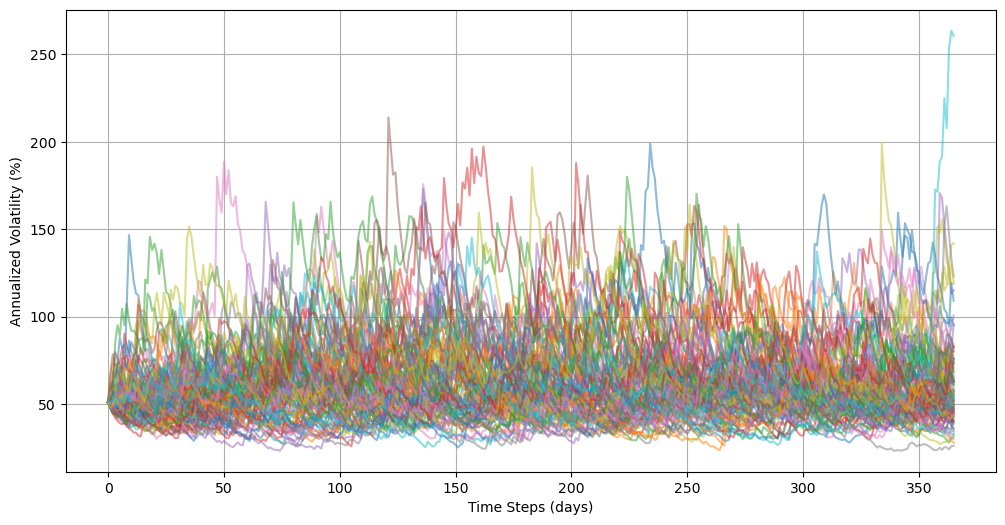

                           Constant Mean - EGARCH Model Results                           
Dep. Variable:                            BTC-USD   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 EGARCH   Log-Likelihood:               -9503.94
Distribution:      Generalized Error Distribution   AIC:                           19017.9
Method:                        Maximum Likelihood   BIC:                           19049.1
                                                    No. Observations:                 3817
Date:                            Mon, Apr 21 2025   Df Residuals:                     3816
Time:                                    10:20:35   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-----------------------------------

In [36]:
model = arch_model(btc_returns*100, vol='EGARCH', p=1, q=1, dist='ged') 
fit = model.fit(disp='off')  # Suppress output

n_days = 366  
n_simulations = 1000

# Forecast future volatility
forecast = fit.forecast(horizon=n_days, simulations=n_simulations, method='simulation')

# Extract simulated daily volatility 
simulated_volatility_daily = np.sqrt(forecast.simulations.variances) / 100

# Convert daily volatility to annualized volatility 
simulated_volatility_annualized = simulated_volatility_daily * np.sqrt(365)

plt.figure(figsize=(12, 6))

# Plot a subset of random paths for better visualization
for i in range(100):  
    plt.plot(simulated_volatility_annualized.T[:, i]*100, alpha=0.5)

#plt.title("Simulated 1-Year Annualized Volatility Using EGARCH(1,1)")
plt.xlabel("Time Steps (days)")
plt.ylabel("Annualized Volatility (%)")
plt.grid(True)
plt.show()

print(fit.summary())


In [37]:
initial_price = btc_daily.iloc[-1] 
mu = np.array(historical_mean)  # Drift (annualized mean return) 
sigma = simulated_volatility_annualized[0,:].T  # Volatility (annualized standard deviation)
time_horizon = 1  # in year
steps_per_year = 366  # 365 for daily, 52 for weekly
num_simulations = 1000  

price_paths_egarch = simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

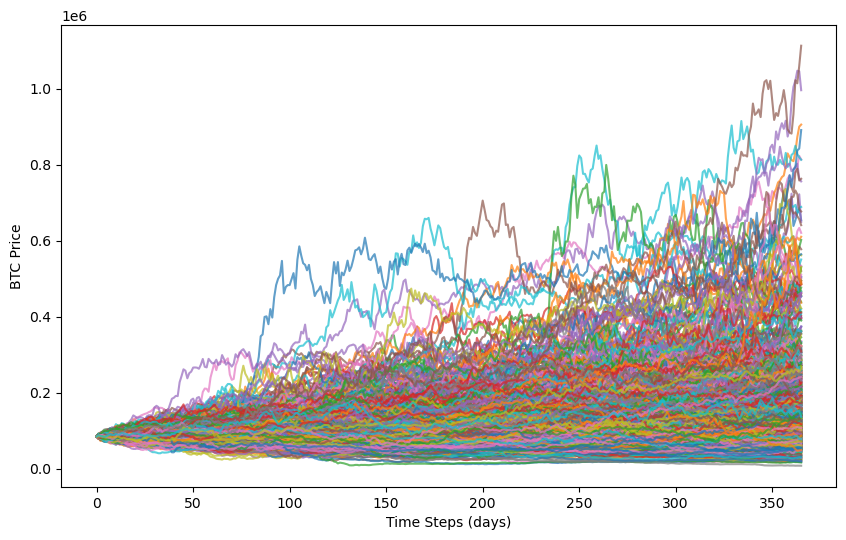

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(price_paths_egarch, alpha=0.7)
#plt.title("Simulated BTC Price Paths (GBM, EGARCH(1, 1) Volatility)")
plt.xlabel("Time Steps (days)")
plt.ylabel("BTC Price")
plt.show()

#### CPPI

In [39]:
cppi_results_egarch = cppi_strategy(price_paths_egarch, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [40]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_cppi = cppi_results_egarch[key]['Basket Values'][-1]  # Last row of CPPI basket values

#### OBPI

In [41]:
time_to_maturity = len(price_paths_egarch)/365 

obpi_results_egarch = obpi_strategy(price_paths_egarch, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, simulated_volatility_annualized[0,].T) # time-varying sigma for the option pricing

In [42]:
floor_frac_obpi = 0.9
key = (floor_frac_obpi)

terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_obpi = obpi_results_egarch[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy & Hold

In [43]:
bnh_results_egarch = buy_and_hold_strategy(
    price_paths=price_paths_egarch,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_egarch)/365
)

In [44]:
terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_bnh = bnh_results_egarch['Basket Values'][-1]  # Last row of B&H basket values

#### Comparison

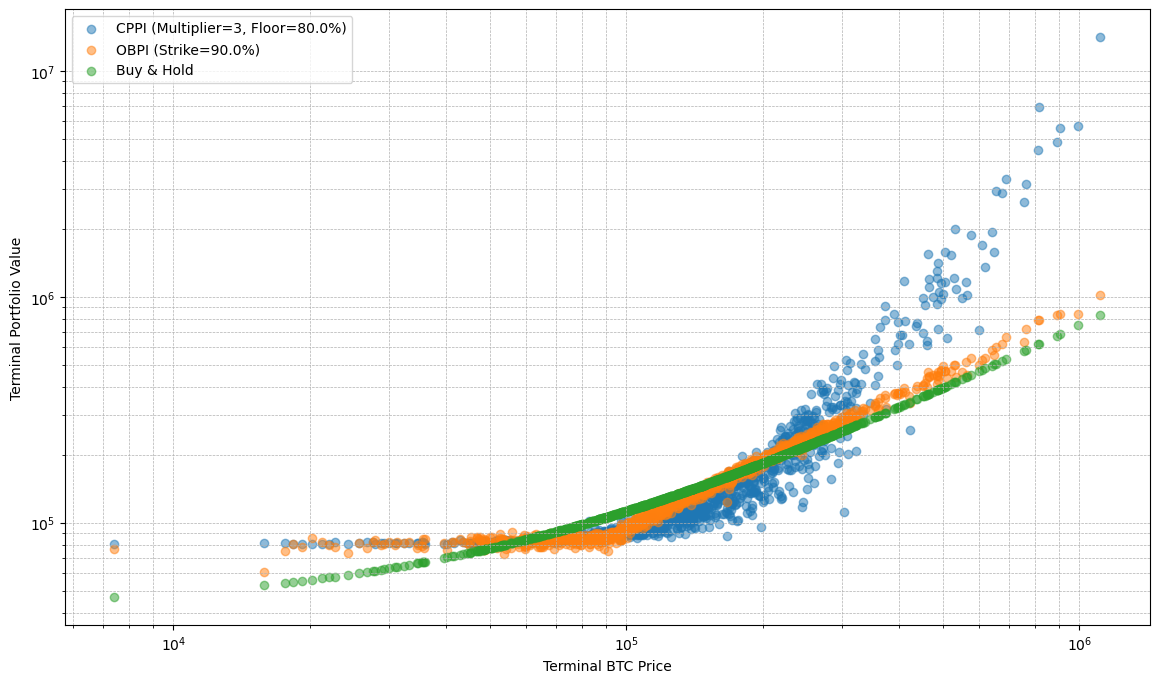

In [45]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Strike={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold')

#plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [46]:
# Define your parameters
multipliers_values2 = [2, 3, 4, 5]
floor_fractions_values2 = [0.7, 0.8, 0.9]
initial_value_2 = 100000  # or whatever your initial portfolio value is

# Initialize a matrix to store gap risk counts
gap_risk_matrix = np.zeros((len(multipliers_values2), len(floor_fractions_values2)))

# Loop through all combinations
for i, m in enumerate(multipliers_values2):
    for j, floor in enumerate(floor_fractions_values2):
        # Extract terminal portfolio values for this combo
        terminal_vals = cppi_results_egarch[(m, floor)]['Basket Values'][-1,:]

        floor_level = floor * initial_value_2
        gap_risk = terminal_vals < floor_level  # Boolean array

        # Count the number of True values
        gap_risk_matrix[i, j] = np.sum(gap_risk)
        print(f"Multiplier={m}, Floor={floor:.2f} -> Gap Risk Count = {int(gap_risk_matrix[i, j])}")


Multiplier=2, Floor=0.70 -> Gap Risk Count = 0
Multiplier=2, Floor=0.80 -> Gap Risk Count = 0
Multiplier=2, Floor=0.90 -> Gap Risk Count = 0
Multiplier=3, Floor=0.70 -> Gap Risk Count = 0
Multiplier=3, Floor=0.80 -> Gap Risk Count = 0
Multiplier=3, Floor=0.90 -> Gap Risk Count = 0
Multiplier=4, Floor=0.70 -> Gap Risk Count = 0
Multiplier=4, Floor=0.80 -> Gap Risk Count = 0
Multiplier=4, Floor=0.90 -> Gap Risk Count = 0
Multiplier=5, Floor=0.70 -> Gap Risk Count = 3
Multiplier=5, Floor=0.80 -> Gap Risk Count = 3
Multiplier=5, Floor=0.90 -> Gap Risk Count = 3


In [47]:
# Define your parameters
floor_fractions_values2 = [0.9, 1.0]
initial_value_2 = 100000  # or whatever your initial portfolio value is

# Initialize a matrix to store gap risk counts
gap_risk_matrix = np.zeros(len(floor_fractions_values2))

# Loop through all combinations
for j, floor in enumerate(floor_fractions_values2):
    # Extract terminal portfolio values for this combo
    terminal_vals = obpi_results_egarch[(floor)]['Basket Values'][-1,:]

    floor_level = 80000
    gap_risk = terminal_vals < floor_level  # Boolean array

    # Count the number of True values
    gap_risk_matrix[j] = np.sum(gap_risk)
    print(f"Floor={floor:.2f} -> Gap Risk Count = {int(gap_risk_matrix[j])}")

Floor=0.90 -> Gap Risk Count = 48
Floor=1.00 -> Gap Risk Count = 14


In [48]:
benchmark_prices = price_paths_egarch

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_egarch[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_egarch[0.9]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices) 
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_egarch['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# # Display Results
# def print_metrics(name, metrics, turnover):
#     print(f"{name} Strategy Metrics:")
#     for metric, value in metrics.items():
#         print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
#     print(f"Turnover: {turnover:.2f}%\n")

# print_metrics("CPPI", cppi_metrics, cppi_turnover)
# print_metrics("OBPI", obpi_metrics, obpi_turnover)
# print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

print("CPPI Strategy Metrics:")
for metric, value in cppi_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {cppi_turnover:.2f}%\n")

print("OBPI Strategy Metrics:")
for metric, value in obpi_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {obpi_turnover:.2f}%\n")

print("Buy-and-Hold Strategy Metrics:")
for metric, value in bnh_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {bnh_turnover:.2f}%\n")

CPPI Strategy Metrics:
Average Return: 1.4096
Average Volatility: 0.6084
Average Tracking Error: 0.4156
Average Sharpe Ratio: 2.2511
Average Sortino Ratio: 2.5165
Average Var 5%: -0.0513
Average Expected Shortfall 5%: -0.0872
Average Skewness: -0.1108
Average Excess Kurtosis: 4.6426
Average Max Drawdown: -0.4156
Average Information Ratio: -0.0111
---------------------------------------------: Distribution Metrics
Median Return: 0.0828
Maximum Return: 140.4846
Minimum Return: -0.1983
Volatility Distribution: 6.5504
Var 5% Distribution: -0.1817
Expected Shortfall 5% Distribution: -0.1878
Skewness Distribution: 12.9379
Excess Kurtosis Distribution: 227.7255
Worst Max Drawdown: -0.9100
Turnover: 1321.48%

OBPI Strategy Metrics:
Average Return: 0.6604
Average Volatility: 0.4267
Average Tracking Error: 0.2796
Average Sharpe Ratio: 1.4538
Average Sortino Ratio: 1.9882
Average Var 5%: -0.0362
Average Expected Shortfall 5%: -0.0524
Average Skewness: 0.0249
Average Excess Kurtosis: 2.9277
Averag

In [49]:
print('BTC metrics:')
compute_btc_metrics(price_paths_egarch)

BTC metrics:


{'Average Return': 1.0283619841909817,
 'Median Return': 0.6618661482460525,
 'Maximum Return': 12.187573780981129,
 'Minimum Return': -0.9123694076390755,
 'Volatility': 0.6507757774658635,
 'Sharpe Ratio': 1.5187442717055128,
 'Sortino Ratio': 2.395127694137389,
 'VaR 5%': -0.05249654274879898,
 'Expected Shortfall 5%': -0.07210717374038152,
 'Skewness': 0.15361524215056263,
 'Excess Kurtosis': 1.339010490707995,
 'Max Drawdown': -0.4403235635245171,
 '---------------------------------------------': 'Distribution Metrics',
 'Volatility Distribution': 1.4837709749215198,
 'VaR 5% Distribution': -0.41857955356508575,
 'Expected Shortfall 5% Distribution': -0.579151416854435,
 'Skewness Distribution': 2.5751087087991413,
 'Excess Kurtosis Distribution': 10.348657593167493,
 'Worst Max Drawdown Distribution': -0.9315294231072478}

## Merton Jump Diffusion

In [50]:
# Fit EGARCH(1,1) model
model = arch_model(btc_returns * 100, vol='EGARCH', p=1, q=1)
res = model.fit(disp="off")

# Standardized residuals
residuals = res.resid / res.conditional_volatility

# Threshold standardized residuals (e.g., > 3)
threshold = 3
jumps = btc_returns[np.abs(residuals) > threshold]


In [51]:
lambda_estimate = len(jumps.dropna()) / len(btc_returns) * 365  # Annualize the jump frequency
mu_jump_estimate = jumps.mean()
sigma_jump_estimate = jumps.std()
print(f"Estimated λ (jumps/year): {lambda_estimate:.2f}")
print(f"Estimated μ_jump (mean jump size): {float(mu_jump_estimate.iloc[0])*100:.4f}%")
print(f"Estimated σ_jump (jump volatility): {float(sigma_jump_estimate.iloc[0])*100:.4f}%")

Estimated λ (jumps/year): 5.45
Estimated μ_jump (mean jump size): -0.6453%
Estimated σ_jump (jump volatility): 14.2847%


In [52]:
def simulate_merton_jump_diffusion(
    S0: float,               # Initial price
    mu: float,               # Annual drift
    sigma: float,            # Annual volatility (GBM part)
    lambd: float,            # Jump intensity (λ, jumps/year)
    mu_jump: float,          # Mean log-jump size (μ_J)
    sigma_jump: float,       # Jump size volatility (σ_J)
    T: float,                # Time horizon (years)
    steps: int,              # Number of time steps
    n_simulations: int,      # Number of paths
) -> np.ndarray:
    """
    Simulates price paths using Merton's Jump-Diffusion model.
    
    Returns:
        np.ndarray: Shape (steps + 1, n_simulations)
    """
    dt = T / steps  
    k = np.exp(mu_jump + 0.5 * sigma_jump**2) - 1  # Average jump size adjustment
    
    # Initialize price matrix
    S = np.zeros((steps + 1, n_simulations))
    S[0] = S0
    
    for t in range(1, steps + 1):
        # Poisson jumps 
        m = np.random.poisson(lambd * dt, n_simulations)
        
        # GBM component
        Z = np.random.randn(n_simulations)
        gbm = (mu - lambd * k - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        
        # Jump component
        jump_sizes = np.zeros(n_simulations)
        for i in range(n_simulations):
            if m[i] > 0:
                # Sum of m[i] log-normal jumps
                jump_sizes[i] = np.sum(
                    mu_jump - 0.5 * sigma_jump**2 + sigma_jump * np.random.randn(m[i]))
        
        # Update price
        S[t] = S[t-1] * np.exp(gbm + jump_sizes)
    
    return S

In [53]:
params = {
    "S0": btc_daily.iloc[-1],              
    "mu": historical_mean.iloc[0],             # annual drift
    "sigma": historical_volatility.iloc[0],          # annual volatility (GBM)
    "lambd": 5.5,           # ~1 jump every 2 years
    "mu_jump": -0.0065,        # Average jump drops price by ~x% (μ_J)
    "sigma_jump": 0.15,     # Jump size volatility (σ_J)
    "T": 1,                 
    "steps": 365,           # 365 for daily
    "n_simulations": 1000,
}

price_paths_jumps = simulate_merton_jump_diffusion(**params)

In [54]:
# plt.figure(figsize=(10, 6))
# plt.plot(price_paths_jumps, alpha=0.7)
# #plt.title("Simulated BTC Price Paths (GBM with Jumps)")
# plt.xlabel("Time Steps (days)")
# plt.ylabel("BTC Price")
# plt.show()

#### CPPI

In [55]:
cppi_results_jumps = cppi_strategy(price_paths_jumps, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [56]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths_jumps[-1]  # Last row of price simulations
terminal_cppi = cppi_results_jumps[key]['Basket Values'][-1]  # Last row of CPPI basket values

#### OBPI

In [57]:
time_to_maturity = len(price_paths_jumps)/365  # adjust (52 for weekly, 365 for daily)

obpi_results_jumps = obpi_strategy(price_paths_jumps, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, float(historical_volatility.iloc[0])) 

# In the obpi strategy run above, the risky asset price paths follow a gbm with jumps process, but the option pricing model volatility is the historical volatility, hence constant. Is it better to use the historical_
# volatility or to use the simulated volatility paths obtained with EGARCH, hence dynamic volatility? 

# obpi_results_jumps = obpi_strategy(price_paths_jumps[:-1,:], 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, simulated_volatility_annualized[0,].T)

In [58]:
floor_frac_obpi = 0.9
key = (floor_frac_obpi)

terminal_prices = [-1]  # Last row of price simulations
terminal_obpi = obpi_results_jumps[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy & Hold

In [59]:
bnh_results_jumps = buy_and_hold_strategy(
    price_paths=price_paths_jumps,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_jumps)/365
)

In [60]:
terminal_prices = price_paths_jumps[-1]  # Last row of price simulations
terminal_bnh = bnh_results_jumps['Basket Values'][-1]  # Last row of B&H basket values

#### Comparison

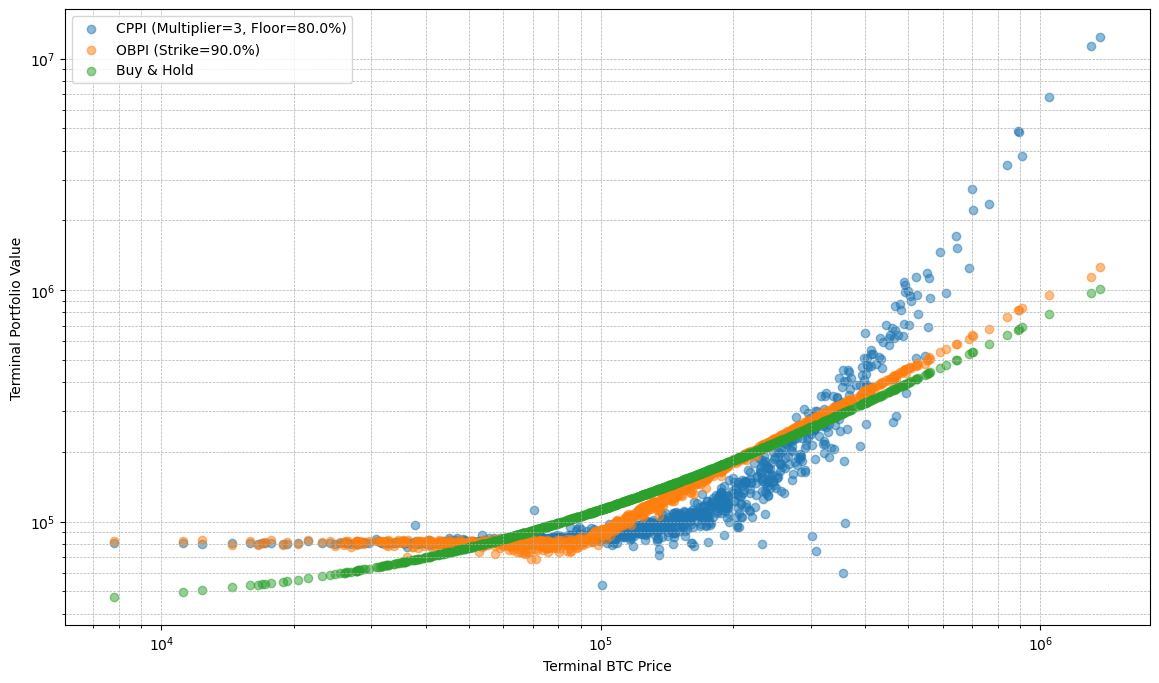

In [61]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Strike={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold')

#plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [62]:
# Define your parameters
multipliers_values2 = [2, 3, 4, 5]
floor_fractions_values2 = [0.7, 0.8, 0.9]
initial_value_2 = 100000  # or whatever your initial portfolio value is

# Initialize a matrix to store gap risk counts
gap_risk_matrix = np.zeros((len(multipliers_values2), len(floor_fractions_values2)))

# Loop through all combinations
for i, m in enumerate(multipliers_values2):
    for j, floor in enumerate(floor_fractions_values2):
        # Extract terminal portfolio values for this combo
        terminal_vals = cppi_results_jumps[(m, floor)]['Basket Values'][-1,:]

        floor_level = floor * initial_value_2
        gap_risk = terminal_vals < floor_level  # Boolean array

        # Count the number of True values
        gap_risk_matrix[i, j] = np.sum(gap_risk)
        print(f"Multiplier={m}, Floor={floor:.2f} -> Gap Risk Count = {int(gap_risk_matrix[i, j])}")

Multiplier=2, Floor=0.70 -> Gap Risk Count = 0
Multiplier=2, Floor=0.80 -> Gap Risk Count = 0
Multiplier=2, Floor=0.90 -> Gap Risk Count = 0
Multiplier=3, Floor=0.70 -> Gap Risk Count = 20
Multiplier=3, Floor=0.80 -> Gap Risk Count = 15
Multiplier=3, Floor=0.90 -> Gap Risk Count = 12
Multiplier=4, Floor=0.70 -> Gap Risk Count = 126
Multiplier=4, Floor=0.80 -> Gap Risk Count = 110
Multiplier=4, Floor=0.90 -> Gap Risk Count = 86
Multiplier=5, Floor=0.70 -> Gap Risk Count = 238
Multiplier=5, Floor=0.80 -> Gap Risk Count = 213
Multiplier=5, Floor=0.90 -> Gap Risk Count = 176


In [63]:
# Define your parameters
floor_fractions_values2 = [0.9, 1.0]
initial_value_2 = 100000  # or whatever your initial portfolio value is

# Initialize a matrix to store gap risk counts
gap_risk_matrix = np.zeros(len(floor_fractions_values2))

# Loop through all combinations
for j, floor in enumerate(floor_fractions_values2):
    # Extract terminal portfolio values for this combo
    terminal_vals = obpi_results_jumps[(floor)]['Basket Values'][-1,:]

    floor_level = 79100
    gap_risk = terminal_vals < floor_level  # Boolean array

    # Count the number of True values
    gap_risk_matrix[j] = np.sum(gap_risk)
    print(f"Floor={floor:.2f} -> Gap Risk Count = {int(gap_risk_matrix[j])}")

Floor=0.90 -> Gap Risk Count = 80
Floor=1.00 -> Gap Risk Count = 18


In [64]:
benchmark_prices = price_paths_jumps

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_jumps[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_jumps[0.9]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices) # needed when using simulated volatility
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_jumps['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# # Display Results
# def print_metrics(name, metrics, turnover):
#     print(f"{name} Strategy Metrics:")
#     for metric, value in metrics.items():
#         print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
#     print(f"Turnover: {turnover:.2f}%\n")

# print_metrics("CPPI", cppi_metrics, cppi_turnover)
# print_metrics("OBPI", obpi_metrics, obpi_turnover)
# print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

print("CPPI Strategy Metrics:")
for metric, value in cppi_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {cppi_turnover:.2f}%\n")

print("OBPI Strategy Metrics:")
for metric, value in obpi_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {obpi_turnover:.2f}%\n")

print("Buy-and-Hold Strategy Metrics:")
for metric, value in bnh_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {bnh_turnover:.2f}%\n")

CPPI Strategy Metrics:
Average Return: 1.0617
Average Volatility: 0.6443
Average Tracking Error: 0.5253
Average Sharpe Ratio: 1.5856
Average Sortino Ratio: 1.6511
Average Var 5%: -0.0537
Average Expected Shortfall 5%: -0.0939
Average Skewness: -0.6821
Average Excess Kurtosis: 16.2744
Average Max Drawdown: -0.4418
Average Information Ratio: -0.0180
---------------------------------------------: Distribution Metrics
Median Return: -0.0678
Maximum Return: 122.7292
Minimum Return: -0.4704
Volatility Distribution: 6.5499
Var 5% Distribution: -0.1934
Expected Shortfall 5% Distribution: -0.2128
Skewness Distribution: 13.5423
Excess Kurtosis Distribution: 217.8241
Worst Max Drawdown: -0.9745
Turnover: 1370.01%

OBPI Strategy Metrics:
Average Return: 0.6189
Average Volatility: 0.4910
Average Tracking Error: 0.3589
Average Sharpe Ratio: 1.1790
Average Sortino Ratio: 1.5323
Average Var 5%: -0.0403
Average Expected Shortfall 5%: -0.0598
Average Skewness: -0.2076
Average Excess Kurtosis: 10.7549
Av

In [65]:
print('BTC metrics:')
compute_btc_metrics(price_paths_jumps)

BTC metrics:


{'Average Return': 1.0011509686806082,
 'Median Return': 0.5263986477884213,
 'Maximum Return': 15.227688161031079,
 'Minimum Return': -0.9075929913973423,
 'Volatility': 0.7761863948259001,
 'Sharpe Ratio': 1.2382991702607669,
 'Sortino Ratio': 1.9595542674290762,
 'VaR 5%': -0.05832058603337502,
 'Expected Shortfall 5%': -0.0811545869214701,
 'Skewness': 0.2983090365296524,
 'Excess Kurtosis': 6.983015003804757,
 'Max Drawdown': -0.5130340970498047,
 '---------------------------------------------': 'Distribution Metrics',
 'Volatility Distribution': 1.6847060907826856,
 'VaR 5% Distribution': -0.5805201237364086,
 'Expected Shortfall 5% Distribution': -0.6895059466168276,
 'Skewness Distribution': 2.6976447533513594,
 'Excess Kurtosis Distribution': 13.000231054894883,
 'Worst Max Drawdown Distribution': -0.9145570876422804}

### Merton Jump Diffusion with EGARCH Volatility

In [171]:
def simulate_merton_jump_diffusion_egarch(
    S0: float,                        # Initial price
    mu: float,                        # Annual drift
    sigma: np.ndarray,                # Annual volatility (shape: (n_simulations, n_steps))
    lambd: float,                     # Jump intensity (λ, jumps/year)
    mu_jump: float,                   # Mean log-jump size (μ_J)
    sigma_jump: float,                # Jump size volatility (σ_J)
    T: float,                         # Time horizon (years)
    steps: int,                       # Number of time steps
    n_simulations: int                # Number of paths
) -> np.ndarray:
    """
    Simulates price paths using Merton's Jump-Diffusion model, allowing time-varying volatility.

    Returns:
        np.ndarray: Shape (steps + 1, n_simulations)
    """
    assert sigma.shape == (n_simulations, steps), "sigma must have shape (n_simulations, steps)"

    dt = T / steps  
    k = np.exp(mu_jump + 0.5 * sigma_jump**2) - 1  # Average jump size adjustment

    # Initialize price matrix
    S = np.zeros((steps + 1, n_simulations))
    S[0] = S0

    # Pre-sample random numbers for vectorization
    Z = np.random.randn(n_simulations, steps)
    m = np.random.poisson(lambd * dt, size=(n_simulations, steps))

    for t in range(1, steps + 1):
        # GBM component
        sigma_t = sigma[:, t - 1]
        Z_t = Z[:, t - 1]
        gbm = (mu - lambd * k - 0.5 * sigma_t**2) * dt + sigma_t * np.sqrt(dt) * Z_t

        # Jump component
        jump_sizes = np.zeros(n_simulations)
        jump_indices = np.where(m[:, t - 1] > 0)[0]

        for i in jump_indices:
            jump_count = m[i, t - 1]
            jump_sizes[i] = np.sum(
                mu_jump - 0.5 * sigma_jump**2 + sigma_jump * np.random.randn(jump_count)
            )

        # Update prices
        S[t] = S[t - 1] * np.exp(gbm + jump_sizes)

    return S

In [172]:
params = {
    "S0": btc_daily.iloc[-1],              
    "mu": historical_mean.iloc[0],             # annual drift
    "sigma": simulated_volatility_annualized[0],          # annual volatility (GBM)
    "lambd": 0.75,           # ~1 jump every 2 years
    "mu_jump": -0.2,        # Average jump drops price by ~x% (μ_J)
    "sigma_jump": 0.3,     # Jump size volatility (σ_J)
    "T": 1,                 
    "steps": 365,           # 365 for daily
    "n_simulations": 1000,
}

price_paths_jumps_egarch = simulate_merton_jump_diffusion_egarch(**params)

#### CPPI

In [173]:
cppi_results_jumps_egarch = cppi_strategy(price_paths_jumps, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [174]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths_jumps[-1]  # Last row of price simulations
terminal_cppi = cppi_results_jumps_egarch[key]['Basket Values'][-1]  # Last row of CPPI basket values

#### OBPI

In [175]:
time_to_maturity = len(price_paths_jumps)/365  # adjust (52 for weekly, 365 for daily)

obpi_results_jumps_egarch = obpi_strategy(price_paths_jumps[:-1,:], 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, simulated_volatility_annualized[0,].T)

In [176]:
floor_frac_obpi = 1
key = (floor_frac_obpi)

terminal_prices = [-1]  # Last row of price simulations
terminal_obpi = obpi_results_jumps_egarch[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy & Hold

In [177]:
bnh_results_jumps_egarch = buy_and_hold_strategy(
    price_paths=price_paths_jumps,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_jumps)/365
)

In [178]:
terminal_prices = price_paths_jumps[-1]  # Last row of price simulations
terminal_bnh = bnh_results_jumps_egarch['Basket Values'][-1]  # Last row of B&H basket values

#### Comparison

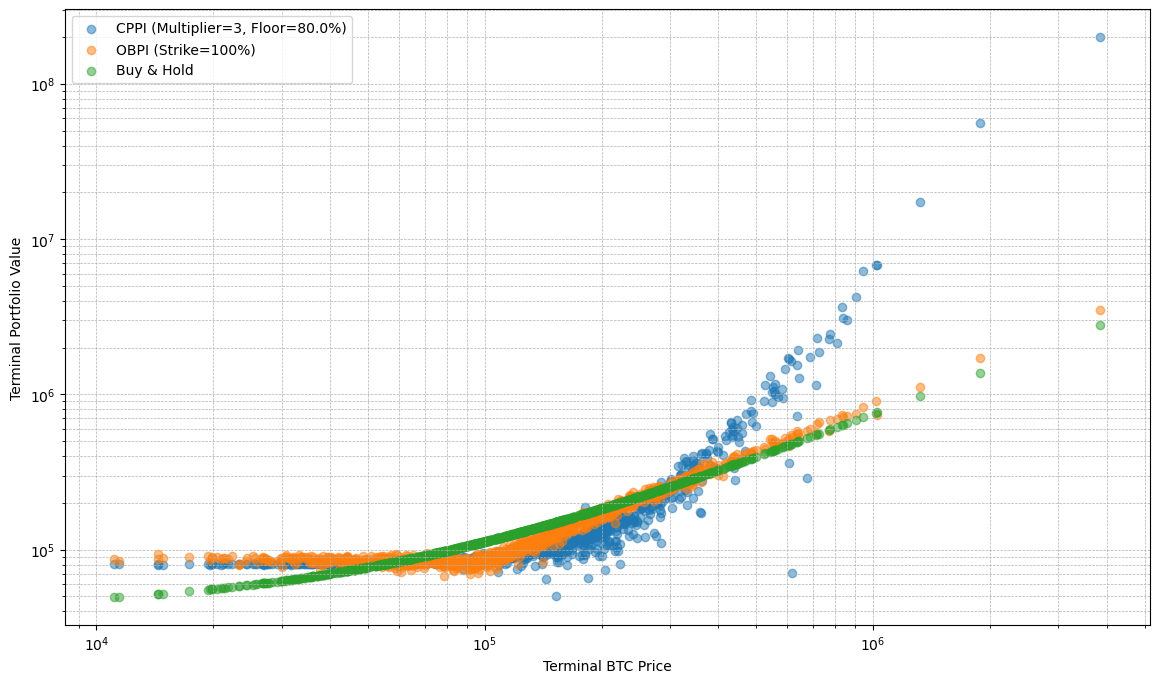

In [179]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Strike={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold')

#plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [180]:
benchmark_prices = price_paths_jumps_egarch

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_jumps_egarch[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_jumps_egarch[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices[:-1,:]) # needed when using simulated volatility
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_jumps_egarch['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

1995.1718602555895 -2.4509976002710516 3.68562939208635 65.79939455753771 -0.08404755569594985
34.070746868891774 -0.32576663728214783 0.5724957058381915 1.6627383596173435 -0.0003706992865942227
26.770293226764103 -0.5050149546234678 0.6200805759210719 1.3886590861851522 0.27882271238842804
CPPI Strategy Metrics:
Annualized Return: 3.6856
Annualized Volatility: 0.6107
Median Return: -0.0840
Sharpe Ratio: 1.7770
Sortino Ratio: 3.9803
Var 5: -0.0462
Es 5: -0.0713
Skewness: -0.9684
Kurtosis: 22.2958
Max Drawdown: -0.4255
Information Ratio: -0.4742
Turnover: 1302.65%

OBPI Strategy Metrics:
Annualized Return: 0.5725
Annualized Volatility: 0.4333
Median Return: -0.0004
Sharpe Ratio: 0.6987
Sortino Ratio: 1.4998
Var 5: -0.0330
Es 5: -0.0490
Skewness: -0.4883
Kurtosis: 16.7963
Max Drawdown: -0.3274
Information Ratio: -0.5027
Turnover: 735.12%

Buy-and-Hold Strategy Metrics:
Annualized Return: 0.6201
Annualized Volatility: 0.4894
Median Return: 0.2788
Sharpe Ratio: 1.0465
Sortino Ratio: 2.042

In [181]:
print('BTC metrics:')
compute_btc_metrics(price_paths_jumps_egarch)

BTC metrics:


{'Annualized Return': '161.61%',
 'Annualized Volatility': '69.98%',
 'Median Annualized Return': '107.48%',
 'Sharpe Ratio': '2.38',
 'Sortino Ratio': '3.93',
 'VaR (5%)': '-5.22%',
 'Expected Shortfall (5%)': '-7.61%',
 'Skewness': '-0.54',
 'Kurtosis': '11.61',
 'Max Drawdown': '-47.81%'}

## Heston Model

In [182]:
def identity(x):
    return x

def heston_simulate(rate: float, sharpe_ratio: float, initial_price: float,
                    kappa: float, lt_var: float, vol_var: float, initial_var: float, rho: float,
                    n_paths: int, time_step: float, n_periods: int,
                    rng: np.random.Generator,
                    transform=identity):
    """
    Simulate paths for price and volatility under the Heston model.
    Note that this function has a side effect because it changes the state of the random number generator.
    """
    
    logS = np.empty((n_periods + 1, n_paths))  # Pre-allocate log prices
    V = np.empty((n_periods + 1, n_paths))  # Pre-allocate variances
    
    logS[0, :] = np.log(initial_price)  # Initial log price
    V[0, :] = initial_var  # Initial variance
    
    loading2 = np.sqrt(1 - rho**2)
    
    for i in range(1, n_periods + 1):
        std_innov1 = rng.standard_normal(n_paths)  # Standard normal innovations
        std_innov2 = rng.standard_normal(n_paths)
        
        sigma = np.sqrt(np.maximum(V[i - 1, :], 0))  # Ensure non-negative volatility
        
        logS[i, :] = logS[i - 1, :] + (rate + sharpe_ratio * sigma - 0.5 * V[i - 1, :]) * time_step \
            + sigma * np.sqrt(time_step) * std_innov1
            
        V[i, :] = V[i - 1, :] + kappa * (lt_var - V[i - 1, :]) * time_step \
            + vol_var * sigma * np.sqrt(time_step) * (rho * std_innov1 + loading2 * std_innov2)
            
        V[i, :] = transform(np.maximum(V[i, :], 0))  # Ensure variance is non-negative
    
    S = np.exp(logS)  # Convert log prices back to prices
    
    return {'price': S, 'volatility': np.sqrt(V)}

In [183]:
print(historical_mean)
print(historical_volatility)
print(historical_sharpe_ratio)

Ticker
BTC-USD    0.737998
dtype: float64
Ticker
BTC-USD    0.693099
dtype: float64
Ticker
BTC-USD    1.06478
dtype: float64


In [184]:
rate = 0.737998
initial_price = btc_daily.iloc[-1]
sharpe_ratio = 1.06478
kappa = 5.07
vol_var = .7
lt_var = 0.693099**2
initial_var = lt_var
rho = -0.767
n_paths = 1000
time_step = 1 / 365
n_periods = 365

rng = np.random.default_rng(seed=123)

SV = heston_simulate(rate, sharpe_ratio, initial_price,
                     kappa, lt_var, vol_var, initial_var, rho,
                     n_paths, time_step, n_periods,
                     rng)

In [185]:
price_paths_heston = SV['price']
vol_paths_heston = SV['volatility']

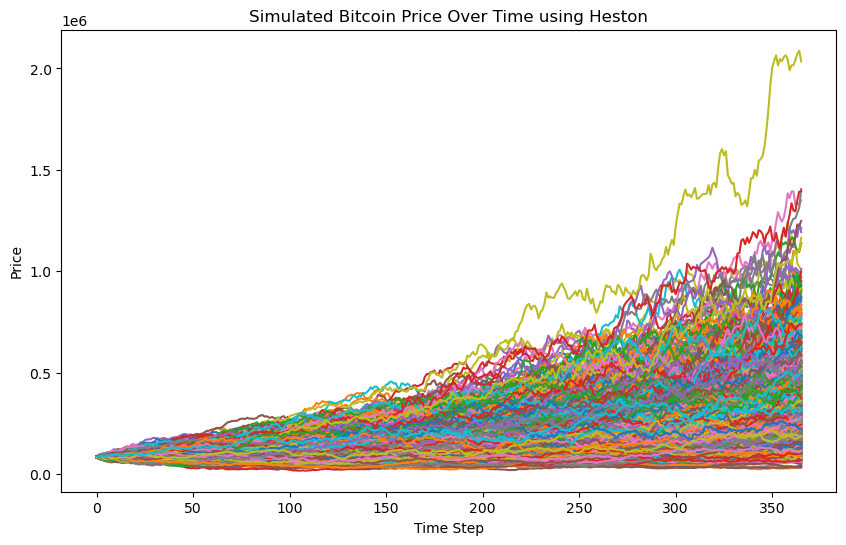

In [186]:
plt.figure(figsize=(10, 6))
plt.plot(price_paths_heston)
plt.title("Simulated Bitcoin Price Over Time using Heston")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()

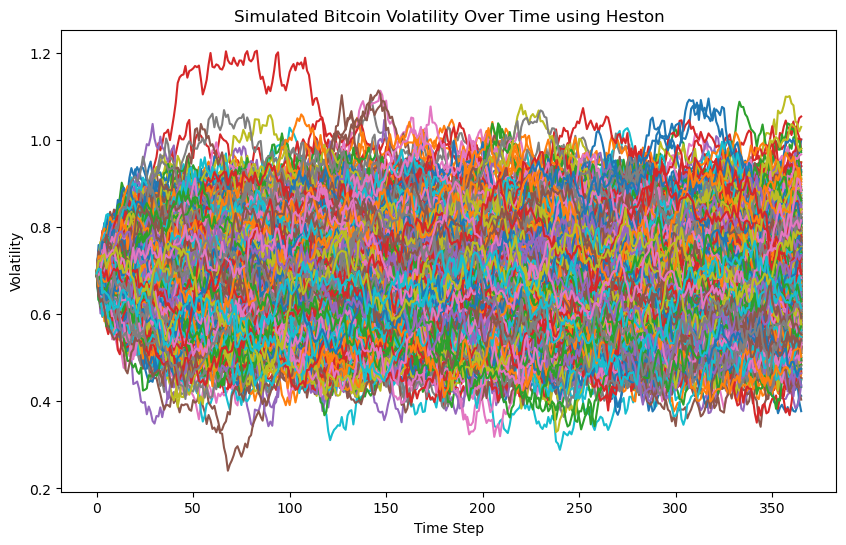

In [187]:
plt.figure(figsize=(10, 6))
plt.plot(vol_paths_heston)
plt.title("Simulated Bitcoin Volatility Over Time using Heston")
plt.xlabel("Time Step")
plt.ylabel("Volatility")
plt.show()

#### CPPI

In [188]:
cppi_results_heston = cppi_strategy(price_paths_heston, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [189]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths_heston[-1]  # Last row of price simulations
terminal_cppi = cppi_results_heston[key]['Basket Values'][-1]  # Last row of CPPI basket values

#### OBPI

In [190]:
time_to_maturity = len(price_paths_heston)/365  # adjust (52 for weekly, 365 for daily)

# obpi_results_heston = obpi_strategy(price_paths_heston, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, float(historical_volatility.iloc[0]))
# same comment as before, above is historical volatility (constant) for the option pricing, and below is the volatility paths used for the risky asset simulation (dynamic)

obpi_results_heston = obpi_strategy(price_paths_heston, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, vol_paths_heston)

In [191]:
floor_frac_obpi = 1
key = (floor_frac_obpi)

terminal_prices = [-1]  # Last row of price simulations
terminal_obpi = obpi_results_heston[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy & Hold

In [192]:
bnh_results_heston = buy_and_hold_strategy(
    price_paths=price_paths_heston,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_heston)/365
)

In [193]:
terminal_prices = price_paths_heston[-1]  # Last row of price simulations
terminal_bnh = bnh_results_heston['Basket Values'][-1]  # Last row of B&H basket values

#### Comparison

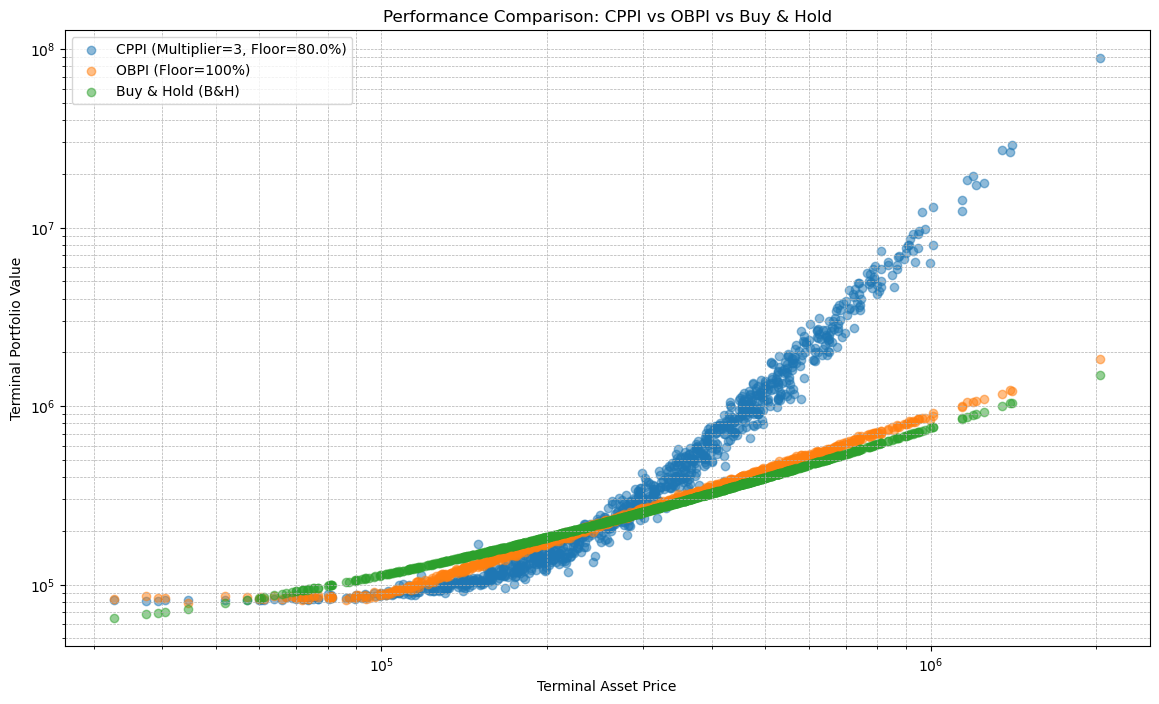

In [194]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [195]:
benchmark_prices = price_paths_heston

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_heston[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_heston[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_heston['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

888.9736980563089 -0.19108636119322187 10.607781711416866 36.93294778291461 2.211554266015077
17.24800541603148 -0.21229036228891918 2.110706857400645 1.9338654487942766 1.6779499933091089
13.88550476458925 -0.3517403174520064 1.9407289494716224 1.5645600772924113 1.610947682194587
CPPI Strategy Metrics:
Annualized Return: 10.6078
Annualized Volatility: 0.9580
Median Return: 2.2116
Sharpe Ratio: 8.1958
Sortino Ratio: 16.0899
Var 5: -0.0759
Es 5: -0.1031
Skewness: 0.0975
Kurtosis: 4.7060
Max Drawdown: -0.5022
Information Ratio: 0.3359
Turnover: 1601.85%

OBPI Strategy Metrics:
Annualized Return: 2.1107
Annualized Volatility: 0.5186
Median Return: 1.6779
Sharpe Ratio: 3.8600
Sortino Ratio: 7.4454
Var 5: -0.0406
Es 5: -0.0533
Skewness: 0.1374
Kurtosis: 3.9865
Max Drawdown: -0.3000
Information Ratio: -1.8796
Turnover: 499.30%

Buy-and-Hold Strategy Metrics:
Annualized Return: 1.9407
Annualized Volatility: 0.4911
Median Return: 1.6109
Sharpe Ratio: 3.9045
Sortino Ratio: 7.5378
Var 5: -0.038

In [196]:
print('BTC metrics:')
compute_btc_metrics(price_paths_heston)

BTC metrics:


{'Annualized Return': '426.40%',
 'Annualized Volatility': '69.09%',
 'Median Annualized Return': '368.94%',
 'Sharpe Ratio': '6.42',
 'Sortino Ratio': '11.59',
 'VaR (5%)': '-5.35%',
 'Expected Shortfall (5%)': '-6.77%',
 'Skewness': '0.14',
 'Kurtosis': '0.19',
 'Max Drawdown': '-37.85%'}

## Robustness analysis

Going forward, we will only use GBM with constant volatility.

### Impact of rebalancing frequency

In [66]:
def simulate_gbm_robustness_rebalancing(initial_price, mu, sigma, time_horizon, steps_per_year_array, num_simulations):
    """
    Simulates asset price evolution using Geometric Brownian Motion (GBM) with multiple time steps.

    Parameters:
        initial_price (float): Current asset price.
        mu (float): Drift (mean return).
        sigmas (float): Annualized volatility.
        time_horizon (float): Time horizon in years.
        steps_per_year_array (list): Array of time steps per year (e.g., [365, 52, 24, 12, 4]).
        num_simulations (int): Number of Monte Carlo simulations.

    Returns:
        dict: Dictionary of simulated price paths for each steps_per_year.
    """
    results = {}

    for steps_per_year in steps_per_year_array:
        dt = 1 / steps_per_year
        total_steps = int(time_horizon * steps_per_year)

        # Initialize price paths
        price_paths = np.zeros((total_steps + 1, num_simulations))
        price_paths[0] = initial_price

        for t in range(1, total_steps + 1):
            z = np.random.standard_normal(num_simulations)
            price_paths[t] = price_paths[t - 1] * np.exp(
                (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z
            )

        results[steps_per_year] = price_paths

    return results

In [67]:
steps_per_year_array = [365, 52, 12, 4, 2] 

In [442]:
initial_price = btc_daily.iloc[-1]  
mu = historical_mean.iloc[0]  # Drift (annualized mean return) 
sigma = historical_volatility.iloc[0]  # Volatility (annualized standard deviation)
time_horizon = 1  # in year
steps_per_year = steps_per_year_array 
num_simulations = 5000 

price_paths_robustness_rebalancing = simulate_gbm_robustness_rebalancing(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

#### CPPI

In [394]:
def cppi_strategy_robustness_rebalacing(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):

    results = {}

    # Loop through each rebalancing frequency
    for frequency, asset_prices in risky_asset.items():
        # Get the shape of the price matrix 
        n_steps, n_simulations = asset_prices.shape

        # Adjusted risk-free rate per rebalancing period
        riskless_return = (1 + riskless_rate) ** (1 / frequency) - 1

        results[frequency] = {}

        # Loop through each multiplier and floor fraction combination
        for multiplier in multipliers:
            for floor_fraction in floor_fractions:
                # Initialize arrays 
                basket_values = np.zeros((n_steps, n_simulations))
                risky_weights = np.zeros((n_steps, n_simulations))
                riskless_weights = np.zeros((n_steps, n_simulations))

                # Initial conditions
                basket_values[0] = initial_portfolio_value
                floor = initial_portfolio_value * floor_fraction

                # Compute the initial cushion and weights
                initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
                risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
                riskless_weights[0] = 1 - risky_weights[0]

                # CPPI dynamics: update at the specified rebalancing interval
                for t in range(1, n_steps):
                    # Compute risky returns 
                    risky_returns = (asset_prices[t] - asset_prices[t - 1]) / asset_prices[t - 1]

                    # Portfolio return: combine risky and riskless returns
                    port_returns = (risky_weights[t - 1] * risky_returns +
                                    riskless_weights[t - 1] * riskless_return)

                    # Update portfolio value
                    basket_values[t] = basket_values[t - 1] * (1 + port_returns)

                
                    cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                    risky_weights[t] = np.maximum(multiplier * cushion, 0)
                    riskless_weights[t] = 1 - risky_weights[t]

                results[frequency][(multiplier, floor_fraction)] = {
                    'Basket Values': basket_values,
                    'Risky Weights': risky_weights,
                    'Riskless Weights': riskless_weights
                }

    return results

In [443]:
cppi_results_robustness_rebalancing = cppi_strategy_robustness_rebalacing(price_paths_robustness_rebalancing, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [473]:
def compute_metrics_cppi_rebalancing(cppi_results, price_paths, m=3, f=0.8, riskless_rate=0.04):
    """
    Computes performance and risk metrics for CPPI strategy across different rebalancing frequencies.

    Parameters:
        cppi_results (dict): Output from the cppi_strategy_robustness_rebalancing function.
        m (int or float): Multiplier used in CPPI (e.g., 3).
        f (float): Floor fraction (e.g., 0.8).
        riskless_rate (float): Annual risk-free rate (e.g., 0.04).

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio, 
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, 
              and max drawdown for each rebalancing frequency.
    """
    avg_returns = {}
    median_returns = {}
    max_returns = {}
    min_returns = {}
    volatility = {}
    sharpe_ratios = {}
    sortino_ratios = {}
    information_ratios = {}
    tracking_errors = {}
    var_5 = {}
    cvar_5 = {}
    skewness = {}
    excess_kurtosis = {}
    max_drawdowns = {}
    var_5_distribution = {}
    cvar_5_distribution = {}
    skewness_distribution = {}
    excess_kurtosis_distribution = {}
    worst_max_drawdowns = {}
    volatility_distribution = {}

    # Loop through each rebalancing frequency
    for frequency, freq_results in cppi_results.items():
        if (m, f) in freq_results:
            basket_values = freq_results[(m, f)]['Basket Values']  # shape: (n_steps, n_simulations)

            # Calculate returns
            returns = basket_values[1:, :] / basket_values[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
            price_returns = price_paths[frequency][1:, :] / price_paths[frequency][:-1, :] - 1  # shape: (n_steps-1, n_simulations)

            total_returns = basket_values[-1, :] / basket_values[0, :] - 1  # shape: (n_simulations,)

            # === Path-level Metrics ===

            # === Average Return ===
            avg_returns[frequency] = np.mean(total_returns)

            # === Median Return ===
            median_returns[frequency] = np.median(total_returns)

            # === Max and Min Returns ===
            max_returns[frequency] = np.max(total_returns)
            min_returns[frequency] = np.min(total_returns)

            # === Volatility ===
            volatility[frequency] = np.mean(np.std(returns, axis=0, ddof=1)) * np.sqrt(frequency)

            # === Tracking Error ===
            tracking_error = np.std(returns - price_returns, axis=0, ddof=1) 
            tracking_errors[frequency] = np.mean(tracking_error) * np.sqrt(frequency)

            # === Sharpe Ratio ===
            sharpe_ratios[frequency] = (avg_returns[frequency] - riskless_rate) / volatility[frequency] if volatility[frequency] != 0 else np.nan

            # === Sortino Ratio ===
            downside_returns = np.where(returns < 0, returns, 0)  
            downside_deviation = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(frequency) if len(downside_returns) > 0 else np.nan
            sortino_ratios[frequency] = (avg_returns[frequency] - riskless_rate) / downside_deviation if downside_deviation not in [0, np.nan] else np.nan

            # === Var and CVar (5%) ===
            var_5[frequency] = np.percentile(returns, 5, axis=0)
            cvar_5[frequency] = np.array([
                col[col <= v].mean() if np.any(col <= v) else np.nan
                for col, v in zip(returns.T, var_5[frequency])
            ])
            var_5[frequency] = np.mean(var_5[frequency])
            cvar_5[frequency] = np.mean(cvar_5[frequency])

            # === Skewness ===
            skewness[frequency] = np.mean(skew(returns, axis=0, bias=False)) # Use bias=False for unbiased skewness

            # === Excess Kurtosis ===
            excess_kurtosis[frequency] = np.mean(kurtosis(returns, axis=0, fisher=True, bias=False))  # Fisher=True for excess kurtosis, bias=False for unbiased

            # === Max Drawdown ===
            cumulative = np.cumprod(1 + returns, axis=0)  
            running_max = np.maximum.accumulate(cumulative, axis=0)
            drawdowns = (cumulative - running_max) / running_max
            max_drawdowns[frequency] = (np.min(drawdowns, axis=0)).mean()

            # Information Ratio
            active_returns = returns - price_returns
            active_returns_avg = np.mean(active_returns, axis=0)
            active_returns_tracking_error = np.std(active_returns, axis=0, ddof=1)
            information_ratios[frequency] = np.mean(active_returns_avg / active_returns_tracking_error)

            # === Distribution Metrics ===

            # === Volatility distribution ===
            volatility_distribution[frequency] = np.std(total_returns)

            # === Value at Risk (5%) ===
            var_5_distribution[frequency] = np.percentile(total_returns, 5)

            # === Expected Shortfall (Conditional VaR 5%) ===
            cvar_5_distribution[frequency] = total_returns[total_returns <= var_5_distribution[frequency]].mean() if np.any(total_returns <= var_5_distribution[frequency]) else np.nan

            # === Skewness ===
            skewness_distribution[frequency] = skew(total_returns, bias=False)  # Use bias=False for unbiased skewness

            # === Excess Kurtosis ===
            excess_kurtosis_distribution[frequency] = kurtosis(total_returns, fisher=True, bias=False)  # Fisher=True for excess kurtosis, bias=False for unbiased

            # === Worst Max Drawdown ===
            cumulative = np.cumprod(1 + returns, axis=0)  
            running_max = np.maximum.accumulate(cumulative, axis=0)
            drawdowns = (cumulative - running_max) / running_max
            worst_max_drawdowns[frequency] = (np.min(drawdowns, axis=0)).min()


    return {
        "Average Returns": avg_returns,
        "Median Returns": median_returns,
        "Max Returns": max_returns,
        "Min Returns": min_returns,
        "Volatility": volatility,
        "Tracking Error": tracking_errors,
        "Sharpe Ratios": sharpe_ratios,
        "Sortino Ratios": sortino_ratios,
        "VaR 5%": var_5,
        "Expected Shortfall 5%": cvar_5,
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Max Drawdown": max_drawdowns,
        "Information Ratio": information_ratios,
        "---------------------------------------------": "Distribution Metrics",
        "Volatility Distribution": volatility_distribution,
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Max Drawdown": worst_max_drawdowns
        
    }

In [474]:
results_cppi_2 = compute_metrics_cppi_rebalancing(cppi_results_robustness_rebalancing, price_paths_robustness_rebalancing, m=3, f=0.8, riskless_rate=0.04)
results_cppi_2

{'Average Returns': {365: 1.6569501466410719,
  52: 1.6030863405358236,
  12: 1.4670763086476295,
  4: 1.2078071847730898,
  2: 0.8521835144225294},
 'Median Returns': {365: 0.04501047432779326,
  52: 0.02364183324185798,
  12: 0.0005653457217279501,
  4: 0.14050252018215414,
  2: 0.324443159277894},
 'Max Returns': {365: 282.821107383238,
  52: 589.6373823649847,
  12: 395.054785567681,
  4: 78.92250276681614,
  2: 27.714263203716893},
 'Min Returns': {365: -0.19696858069409995,
  52: -0.197706151731868,
  12: -4.907786928516259,
  4: -3.5532207143179413,
  2: -2.6417519864723182},
 'Volatility': {365: 0.6334749369008316,
  52: 0.6295702915944585,
  12: 0.6225702661517245,
  4: 0.641234149777256,
  2: 0.5762154070988849},
 'Tracking Error': {365: 0.4467656754434902,
  52: 0.4560716329822461,
  12: 0.4702919503214377,
  4: 0.4678512931335708,
  2: 0.4350187172140301},
 'Sharpe Ratios': {365: 2.5525084773704316,
  52: 2.4827828781074297,
  12: 2.292233320856736,
  4: 1.8211868241558067,

In [445]:
for i in cppi_results_robustness_rebalancing.keys():
    print(turnover(cppi_results_robustness_rebalancing[i][(3, 0.9)]['Risky Weights']))

1093.53347078008
410.5793630375822
196.16467728471278
118.42465155158479
83.37416542792165


#### OBPI

In [399]:
def obpi_strategy_robustness_rebalancing(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions and rebalancing frequencies.

    Parameters:
        risky_asset (dict): Dictionary where keys are rebalancing frequencies (e.g., 365 for daily, 52 for weekly)
                             and values are simulated risky asset prices with shape (n_steps, n_simulations).
        riskless_rate (float): The constant annual risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized), either a float (constant) or ndarray (n_steps, n_simulations).

    Returns:
        dict: Dictionary containing results for each floor fraction and each rebalancing frequency.
    """
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        """Computes the Black-Scholes put price and delta."""
        if T <= 0:  # Handle edge case where time to maturity is zero
            return np.maximum(K - S, 0), np.where(S < K, -1, 0)  # Vectorized for arrays
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        
        return put_price, put_delta

    # Loop through all rebalancing frequencies 
    for frequency, asset_prices in risky_asset.items():
        n_steps, n_simulations = asset_prices.shape
        floor_results = {}

        # Calculate riskless return based on frequency
        riskless_return = (1 + riskless_rate) ** (1 / frequency) - 1
        dt = 1 / frequency  

        for floor_fraction in floor_fractions:
            # Initialize arrays 
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))
            put_prices = np.zeros((n_steps, n_simulations))
            put_deltas = np.zeros((n_steps, n_simulations))

            # Initial conditions
            floor = initial_portfolio_value * floor_fraction

            # Compute initial put price and delta for all simulations
            initial_put_price, initial_put_delta = black_scholes_put(
                asset_prices[0], floor, time_to_maturity, riskless_rate, sigma
            )

            # Compute initial weights
            risky_w = ((1 + initial_put_delta) * asset_prices[0]) / (asset_prices[0] + initial_put_price)
            risky_w = np.maximum(0, np.minimum(1, risky_w))  # Ensure weights are between 0 and 1
            riskless_w = 1 - risky_w

            # Set initial values
            basket_values[0, :] = initial_portfolio_value
            risky_weights[0, :] = risky_w
            riskless_weights[0, :] = riskless_w
            put_prices[0, :] = initial_put_price
            put_deltas[0, :] = initial_put_delta

            for i in range(1, n_steps):
                remaining_ttm = time_to_maturity - i * dt  

                # Compute risky returns
                risky_return = (asset_prices[i] - asset_prices[i - 1]) / asset_prices[i - 1]

                # Update portfolio value
                portfolio_return = (risky_weights[i - 1] * risky_return +
                                    riskless_weights[i - 1] * riskless_return)
                basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

                # Compute new put option price and delta 
                put_price, put_delta = black_scholes_put(
                    asset_prices[i], floor, remaining_ttm, riskless_rate, sigma
                )

                # Update weights
                risky_w = ((1 + put_delta) * asset_prices[i]) / (asset_prices[i] + put_price)
                risky_w = np.maximum(0, np.minimum(1, risky_w))  # Ensure weights are between 0 and 1
                riskless_w = 1 - risky_w

                # Store values for this step
                risky_weights[i] = risky_w
                riskless_weights[i] = riskless_w
                put_prices[i] = put_price
                put_deltas[i] = put_delta

            floor_results[floor_fraction] = {
                "Basket Values": basket_values,
                "Risky Weights": risky_weights,
                "Riskless Weights": riskless_weights,
                "Put Price": put_prices,
                "Put Delta": put_deltas,
            }

        results[frequency] = floor_results

    return results

In [446]:
obpi_results_robustness_rebalancing = obpi_strategy_robustness_rebalancing(price_paths_robustness_rebalancing, 0.04, floor_fractions, initial_portfolio_value, 1, historical_volatility.iloc[0])

In [475]:
def compute_metrics_obpi(results, price_paths, f=0.9, riskless_rate=0.04):
    """
    Computes performance and risk metrics for OBPI strategy across different rebalancing frequencies.

    Parameters:
        results (dict): Output from the obpi_strategy_robustness_rebalancing function.
        f (float): Floor fraction (e.g., 0.9).
        riskless_rate (float): Annual risk-free rate (e.g., 0.04).

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio,
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, and max drawdown
              for each rebalancing frequency, for path-level and distribution-level metrics.
    """
    avg_returns = {}
    median_returns = {}
    max_returns = {}
    min_returns = {}
    volatility = {}
    tracking_errors = {}
    sharpe_ratios = {}
    sortino_ratios = {}
    information_ratios = {}
    var_5 = {}
    cvar_5 = {}
    skewness = {}
    excess_kurtosis = {}
    max_drawdowns = {}
    var_5_distribution = {}
    cvar_5_distribution = {}
    skewness_distribution = {}
    excess_kurtosis_distribution = {}
    worst_max_drawdowns = {}
    volatility_distribution = {}

    # Loop through each rebalancing frequency
    for frequency, freq_results in results.items():
        if f in freq_results:
            basket_values = freq_results[f]['Basket Values']  # shape: (n_steps, n_simulations)

            # Calculate returns
            returns = basket_values[1:, :] / basket_values[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
            price_returns = price_paths[frequency][1:, :] / price_paths[frequency][:-1, :] - 1  # shape: (n_steps-1, n_simulations)

            total_returns = (basket_values[-1, :] / basket_values[0, :]) - 1  # shape: (n_simulations,)

            # === Path-level Metrics ===

            # Average Return
            avg_returns[frequency] = np.mean(total_returns)

            # Median Return
            median_returns[frequency] = np.median(total_returns)

            # Max and Min Returns
            max_returns[frequency] = np.max(total_returns)
            min_returns[frequency] = np.min(total_returns)

            # Volatility
            volatility[frequency] = np.mean(np.std(returns, axis=0, ddof=1)) * np.sqrt(frequency)

            # === Tracking Error ===
            tracking_error = np.std(returns - price_returns, axis=0, ddof=1) 
            tracking_errors[frequency] = np.mean(tracking_error) * np.sqrt(frequency)

            # Sharpe Ratio
            sharpe_ratios[frequency] = (avg_returns[frequency] - riskless_rate) / volatility[frequency] if volatility[frequency] != 0 else np.nan

            # === Sortino Ratio ===
            downside_returns = np.where(returns < 0, returns, 0)  
            downside_deviation = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(frequency) if len(downside_returns) > 0 else np.nan
            sortino_ratios[frequency] = (avg_returns[frequency] - riskless_rate) / downside_deviation if downside_deviation not in [0, np.nan] else np.nan

            # === Var and CVar (5%) ===
            var_5[frequency] = np.percentile(returns, 5, axis=0)
            cvar_5[frequency] = np.array([
                col[col <= v].mean() if np.any(col <= v) else np.nan
                for col, v in zip(returns.T, var_5[frequency])
            ])
            var_5[frequency] = np.mean(var_5[frequency])
            cvar_5[frequency] = np.mean(cvar_5[frequency])

            # Skewness
            skewness[frequency] = np.mean(skew(returns, axis=0, bias=False))

            # Excess Kurtosis
            excess_kurtosis[frequency] = np.mean(kurtosis(returns, axis=0, fisher=True, bias=False))

            # === Max Drawdown ===
            cumulative = np.cumprod(1 + returns, axis=0)  
            running_max = np.maximum.accumulate(cumulative, axis=0)
            drawdowns = (cumulative - running_max) / running_max
            max_drawdowns[frequency] = (np.min(drawdowns, axis=0)).mean()
            worst_max_drawdowns[frequency] = (np.min(drawdowns, axis=0)).min()


            # Information Ratio
            active_returns = returns - price_returns
            active_returns_avg = np.mean(active_returns, axis=0)
            active_returns_tracking_error = np.std(active_returns, axis=0, ddof=1)
            information_ratios[frequency] = np.mean(active_returns_avg / active_returns_tracking_error)

            # === Distribution Metrics ===

            # === Volatility distribution ===
            volatility_distribution[frequency] = np.std(total_returns)

            # Value at Risk (5%)
            var_5_distribution[frequency] = np.percentile(total_returns, 5)

            # Expected Shortfall (Conditional VaR 5%)
            cvar_5_distribution[frequency] = total_returns[total_returns <= var_5_distribution[frequency]].mean() if np.any(total_returns <= var_5_distribution[frequency]) else np.nan

            # Skewness
            skewness_distribution[frequency] = skew(total_returns, bias=False)

            # Excess Kurtosis
            excess_kurtosis_distribution[frequency] = kurtosis(total_returns, fisher=True, bias=False)

    return {
        "Average Returns": avg_returns,
        "Median Returns": median_returns,
        "Max Returns": max_returns,
        "Min Returns": min_returns,
        "Volatility": volatility,
        "Tracking Error": tracking_errors,
        "Sharpe Ratios": sharpe_ratios,
        "Sortino Ratios": sortino_ratios,
        "VaR 5%": var_5,
        "Expected Shortfall 5%": cvar_5,
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Max Drawdown": max_drawdowns,
        "Information Ratio": information_ratios,
        "---------------------------------------------": "Distribution Metrics",
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Drawdown Distribution": worst_max_drawdowns
    }

In [476]:
results_obpi_2 = compute_metrics_obpi(obpi_results_robustness_rebalancing, price_paths_robustness_rebalancing, f=0.9, riskless_rate=0.04)
results_obpi_2

{'Average Returns': {365: 0.7187948737255672,
  52: 0.6957020611853046,
  12: 0.6728227977807648,
  4: 0.6666937784080803,
  2: 0.5779813969054601},
 'Median Returns': {365: 0.29313759169341214,
  52: 0.2737287713015839,
  12: 0.274397447160764,
  4: 0.2834161365725605,
  2: 0.2839511400483764},
 'Max Returns': {365: 12.929356366312565,
  52: 17.395614082596275,
  12: 21.65614665246104,
  4: 14.889856046315026,
  2: 11.567176153451054},
 'Min Returns': {365: -0.23095867880809373,
  52: -0.285652112082309,
  12: -0.39799212881075563,
  4: -0.5173084946429986,
  2: -0.5520582313120008},
 'Volatility': {365: 0.45515717268833933,
  52: 0.452772293097326,
  12: 0.4489291170739557,
  4: 0.44391979563410006,
  2: 0.40894905575731716},
 'Tracking Error': {365: 0.30125296468133683,
  52: 0.3113746925276101,
  12: 0.33825849495347327,
  4: 0.3888961595830321,
  2: 0.4318146998879149},
 'Sharpe Ratios': {365: 1.4913417044849246,
  52: 1.4481938740106557,
  12: 1.4096274305070633,
  4: 1.411727489

In [448]:
for i in obpi_results_robustness_rebalancing.keys():
    print(turnover(obpi_results_robustness_rebalancing[i][(0.9)]['Risky Weights']))

604.6950693954391
231.96564159736735
117.62889638189249
74.50094667526942
58.325929059414875


#### Analysis

In [449]:
# Extract rebalancing frequencies
frequencies_cppi = list(results_cppi_2["Average Returns"].keys())
frequencies_obpi = list(results_obpi_2["Average Returns"].keys())

# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi_2["Average Returns"][f] for f in frequencies_cppi]
volatility_cppi = [results_cppi_2["Volatility"][f] for f in frequencies_cppi]
sharpe_cppi = [results_cppi_2["Sharpe Ratios"][f] for f in frequencies_cppi]

avg_returns_obpi = [results_obpi_2["Average Returns"][f] for f in frequencies_obpi]
volatility_obpi = [results_obpi_2["Volatility"][f] for f in frequencies_obpi]
sharpe_obpi = [results_obpi_2["Sharpe Ratios"][f] for f in frequencies_obpi]

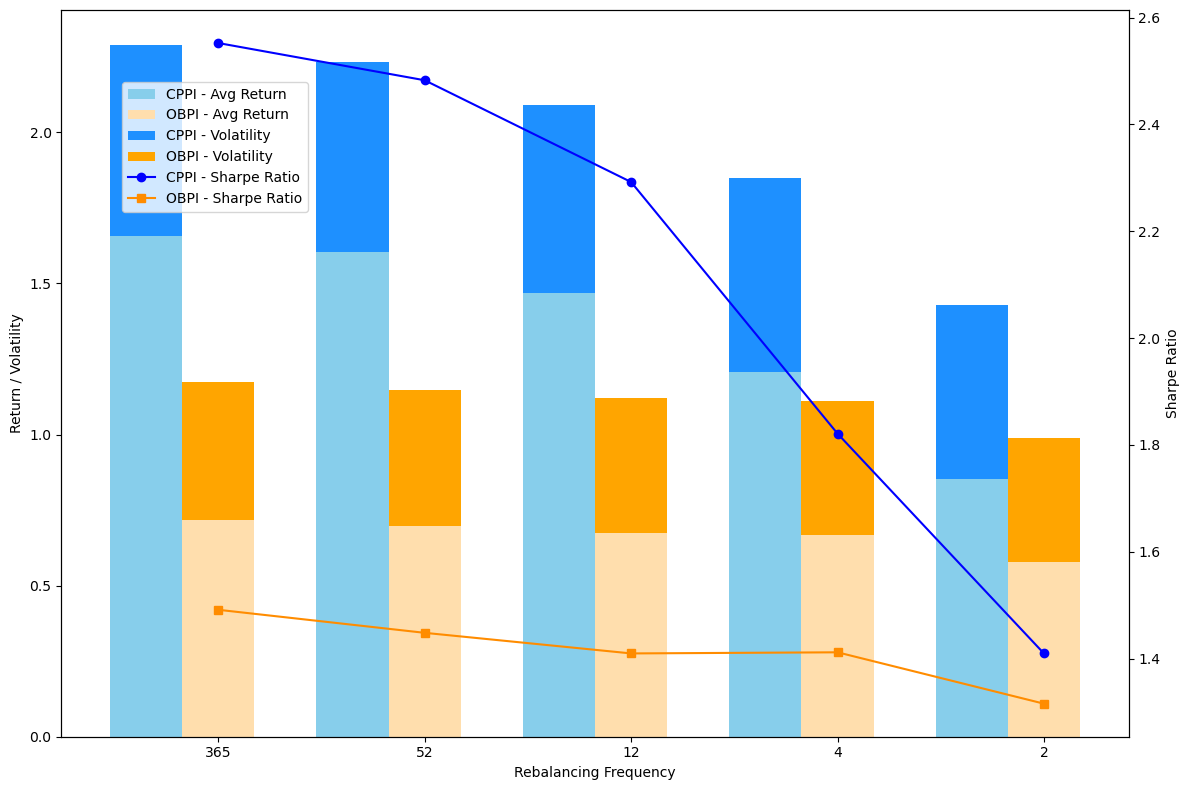

In [450]:
# Prepare data
labels = frequencies_cppi  # Assuming both CPPI and OBPI use the same frequencies
x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12, 8))

# Plot average returns
ax.bar(x - width, avg_returns_cppi, width, label='CPPI - Avg Return', color='skyblue')
ax.bar(x, avg_returns_obpi, width, label='OBPI - Avg Return', color='navajowhite')

# Plot volatility
ax.bar(x - width, volatility_cppi, width, bottom=avg_returns_cppi, label='CPPI - Volatility', color='dodgerblue')
ax.bar(x, volatility_obpi, width, bottom=avg_returns_obpi, label='OBPI - Volatility', color='orange')

# Plot sharpe ratios on a secondary axis to keep scale readable
ax2 = ax.twinx()
ax2.plot(x, sharpe_cppi, marker='o', color='blue', label='CPPI - Sharpe Ratio')
ax2.plot(x, sharpe_obpi, marker='s', color='darkorange', label='OBPI - Sharpe Ratio')

# Labels and Titles
ax.set_xlabel('Rebalancing Frequency')
ax.set_ylabel('Return / Volatility')
ax2.set_ylabel('Sharpe Ratio')

# X-axis ticks
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Layout
plt.tight_layout()
plt.show()


### Impact of volatility level

In [235]:
def simulate_gbm_robustness_volatility(initial_price, mu, sigmas, time_horizon, steps_per_year, num_simulations):
    
    results = {}

    for sigma in sigmas:
        dt = 1 / steps_per_year
        total_steps = int(time_horizon * steps_per_year)

        # Initialize price paths
        price_paths = np.zeros((total_steps + 1, num_simulations))
        price_paths[0] = initial_price

        for t in range(1, total_steps + 1):
            z = np.random.standard_normal(num_simulations)
            price_paths[t] = price_paths[t - 1] * np.exp(
                (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z
            )

        results[sigma] = price_paths

    return results

In [236]:
sigmas = [2, 1.5, 1, 0.5, 0.25]

In [354]:
initial_price = btc_daily.iloc[-1]  
mu = historical_mean.iloc[0]  # Drift (annualized mean return) 
sigma = sigmas  # Volatilities
time_horizon = 1  # in year
steps_per_year = 365 
num_simulations = 1000 

price_paths_robustness_volatility = simulate_gbm_robustness_volatility(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

#### CPPI

In [355]:
def cppi_strategy_robustness_volatility(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):

    results = {}

    # Loop through each volatility
    for volatility, asset_prices in risky_asset.items():
        # Get the shape of the price matrix for the current volatility
        n_steps, n_simulations = asset_prices.shape

        # Adjusted risk-free rate per rebalancing period
        riskless_return = (1 + riskless_rate) ** (1 / 365) - 1

        # Store results for the current volatility
        results[volatility] = {}

        # Loop through each multiplier and floor fraction combination
        for multiplier in multipliers:
            for floor_fraction in floor_fractions:
                # Initialize arrays for portfolio values and weights
                basket_values = np.zeros((n_steps, n_simulations))
                risky_weights = np.zeros((n_steps, n_simulations))
                riskless_weights = np.zeros((n_steps, n_simulations))

                # Initial conditions
                basket_values[0] = initial_portfolio_value
                floor = initial_portfolio_value * floor_fraction

                # Compute the initial cushion and weights
                initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
                risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
                riskless_weights[0] = 1 - risky_weights[0]

                # CPPI dynamics: update at the specified rebalancing interval
                for t in range(1, n_steps):
                    # Compute risky returns since the last step
                    risky_returns = (asset_prices[t] - asset_prices[t - 1]) / asset_prices[t - 1]

                    # Portfolio return: combine risky and riskless returns
                    port_returns = (risky_weights[t - 1] * risky_returns +
                                    riskless_weights[t - 1] * riskless_return)

                    # Update portfolio value
                    basket_values[t] = basket_values[t - 1] * (1 + port_returns)

                
                    cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                    risky_weights[t] = np.maximum(multiplier * cushion, 0)
                    riskless_weights[t] = 1 - risky_weights[t]

                # Store the results for the current volatility, multiplier, and floor_fraction
                results[volatility][(multiplier, floor_fraction)] = {
                    'Basket Values': basket_values,
                    'Risky Weights': risky_weights,
                    'Riskless Weights': riskless_weights
                }

    return results

In [356]:
cppi_results_robustness_volatility = cppi_strategy_robustness_volatility(price_paths_robustness_volatility, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [478]:
def compute_metrics_cppi_volatility(cppi_results, price_paths, m=3, f=0.8, riskless_rate=0.04):
    """
    Computes financial metrics for CPPI strategy across different volatility levels.

    Parameters:
        cppi_results (dict): Output from the cppi_strategy_robustness_volatility function.
        m (int or float): The multiplier.
        f (float): The floor fraction.
        riskless_rate (float): Annual risk-free rate.

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio,
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, and max drawdown
              for each volatility level, for path-level and distribution-level metrics.
    """
    avg_returns = {}
    median_returns = {}
    max_returns = {}
    min_returns = {}
    volatility = {}
    tracking_errors = {}
    sharpe_ratios = {}
    sortino_ratios = {}
    information_ratios = {}
    var_5 = {}
    cvar_5 = {}
    skewness = {}
    excess_kurtosis = {}
    max_drawdowns = {}
    var_5_distribution = {}
    cvar_5_distribution = {}
    skewness_distribution = {}
    excess_kurtosis_distribution = {}
    worst_max_drawdowns = {}
    volatility_distribution = {}

    # Loop through each volatility level
    for sigma, results in cppi_results.items():
        if (m, f) in results:
            basket_values = results[(m, f)]['Basket Values']  # shape: (n_steps, n_simulations)

            # Calculate returns
            returns = basket_values[1:, :] / basket_values[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
            price_returns = price_paths[sigma][1:, :] / price_paths[sigma][:-1, :] - 1

            total_returns = basket_values[-1, :] / basket_values[0, :] - 1  # shape: (n_simulations,)

            # === Path-level Metrics ===

            # Average Return
            avg_returns[sigma] = np.mean(total_returns)

            # Median Return
            median_returns[sigma] = np.median(total_returns)

            # Min and Max Returns
            max_returns[sigma] = np.max(total_returns)
            min_returns[sigma] = np.min(total_returns)

            # Volatility
            volatility[sigma] = np.mean(np.std(returns, axis=0, ddof=1)) * np.sqrt(365)

            # === Tracking Error ===
            tracking_error = np.std(returns - price_returns, axis=0, ddof=1) 
            tracking_errors[sigma] = np.mean(tracking_error) * np.sqrt(365)

            # Sharpe Ratio
            sharpe_ratios[sigma] = (avg_returns[sigma] - riskless_rate) / volatility[sigma] if volatility[sigma] != 0 else np.nan

            # === Sortino Ratio ===
            downside_returns = np.where(returns < 0, returns, 0)  
            downside_deviation = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(365) if len(downside_returns) > 0 else np.nan
            sortino_ratios[sigma] = (avg_returns[sigma] - riskless_rate) / downside_deviation if downside_deviation not in [0, np.nan] else np.nan

            # === Var and CVar (5%) ===
            var_5[sigma] = np.percentile(returns, 5, axis=0)
            cvar_5[sigma] = np.array([
                col[col <= v].mean() if np.any(col <= v) else np.nan
                for col, v in zip(returns.T, var_5[sigma])
            ])
            var_5[sigma] = np.mean(var_5[sigma])
            cvar_5[sigma] = np.mean(cvar_5[sigma])

            # Skewness
            skewness[sigma] = np.mean(skew(returns, axis=0, bias=False))

            # Excess Kurtosis
            excess_kurtosis[sigma] = np.mean(kurtosis(returns, axis=0, fisher=True, bias=False))

            # === Max Drawdown ===
            cumulative = np.cumprod(1 + returns, axis=0)  
            running_max = np.maximum.accumulate(cumulative, axis=0)
            drawdowns = (cumulative - running_max) / running_max
            max_drawdowns[sigma] = (np.min(drawdowns, axis=0)).mean()
            worst_max_drawdowns[sigma] = (np.min(drawdowns, axis=0)).min()

            # Information Ratio
            active_returns = returns - price_returns
            active_returns_avg = np.mean(active_returns, axis=0)
            active_returns_tracking_error = np.std(active_returns, axis=0, ddof=1)
            information_ratios[sigma] = np.mean(active_returns_avg / active_returns_tracking_error)

            # === Distribution Metrics ===

            # === Volatility distribution ===
            volatility_distribution[sigma] = np.std(total_returns)

            # Value at Risk (5%)
            var_5_distribution[sigma] = np.percentile(total_returns, 5)

            # Expected Shortfall (Conditional VaR 5%)
            cvar_5_distribution[sigma] = total_returns[total_returns <= var_5_distribution[sigma]].mean() if np.any(total_returns <= var_5_distribution[sigma]) else np.nan

            # Skewness
            skewness_distribution[sigma] = skew(total_returns, bias=False)

            # Excess Kurtosis
            excess_kurtosis_distribution[sigma] = kurtosis(total_returns, fisher=True, bias=False)

    return {
        "Average Returns": avg_returns,
        "Median Returns": median_returns,
        "Max Returns": max_returns,
        "Min Returns": min_returns,
        "Volatility": volatility,
        "Tracking Error": tracking_errors,
        "Sharpe Ratios": sharpe_ratios,
        "Sortino Ratios": sortino_ratios,
        "VaR 5%": var_5,
        "Expected Shortfall 5%": cvar_5,
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Max Drawdown": max_drawdowns,
        "Information Ratio": information_ratios,
        "---------------------------------------------": "Distribution Metrics",
        "Volatility Distribution": volatility_distribution,
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Max Drawdown": worst_max_drawdowns
    }

In [479]:
results_cppi_2 = compute_metrics_cppi_volatility(cppi_results_robustness_volatility, price_paths_robustness_volatility, m=3, f=0.8, riskless_rate=0.04)
results_cppi_2

{'Average Returns': {2: -0.1765702482421318,
  1.5: 0.12281753931698448,
  1: 1.120328376968333,
  0.5: 1.6113658224193346,
  0.25: 1.532980363532163},
 'Median Returns': {2: -0.19694590891203462,
  1.5: -0.1928943942171485,
  1: -0.16058467498643125,
  0.5: 0.3543738932876187,
  0.25: 1.1045867242755254},
 'Max Returns': {2: 4.222484191183456,
  1.5: 105.8279227264804,
  1: 214.96566325990227,
  0.5: 144.55495788820713,
  0.25: 14.652796229191624},
 'Min Returns': {2: -0.5766867051947231,
  1.5: -0.19949303213539304,
  1: -0.19867138141077445,
  0.5: -0.17968977083560922,
  0.25: -0.021352489462003965},
 'Volatility': {2: 0.5386752366379723,
  1.5: 0.6797184325420703,
  1: 0.6552006983180513,
  0.5: 0.5262335993288444,
  0.25: 0.3175165165211556},
 'Tracking Error': {2: 1.8565947161330674,
  1.5: 1.3044618250548563,
  1: 0.759095528357074,
  0.5: 0.27864536180224636,
  0.25: 0.12320528084996434},
 'Sharpe Ratios': {2: -0.4020423318395129,
  1.5: 0.12184094965213203,
  1: 1.64885107684

In [373]:
for i in cppi_results_robustness_volatility.keys():
    print(turnover(cppi_results_robustness_volatility[i][(3, 0.8)]['Risky Weights']))

867.6852294587188
1257.3716926009965
1438.7193097960899
1235.6564692441068
737.335281197801


#### OBPI

In [359]:
def obpi_strategy_robustness_volatility(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigmas):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions and volatilities.

    Parameters:
        risky_asset (dict): Dictionary where keys are volatilities and values are simulated prices (n_steps, n_simulations).
        riskless_rate (float): Annual risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial portfolio value.
        time_to_maturity (float): Time to maturity in years.
        sigmas (list or np.ndarray): List of volatilities to test.

    Returns:
        dict: Dictionary of results for each volatility and floor fraction.
    """

    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        """Computes the Black-Scholes put price and delta."""
        if T <= 0:  # Handle edge case where time to maturity is zero
            return np.maximum(K - S, 0), np.where(S < K, -1, 0)  # Vectorized for arrays
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        
        return put_price, put_delta

    for sigma, asset_prices in risky_asset.items():
        n_steps, n_simulations = asset_prices.shape
        dt = time_to_maturity / (n_steps - 1) 
        riskless_return = (1 + riskless_rate) ** dt - 1

        floor_results = {}

        for floor_fraction in floor_fractions:
            # Initialize arrays for results
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))
            put_prices = np.zeros((n_steps, n_simulations))
            put_deltas = np.zeros((n_steps, n_simulations))

            # Initial conditions
            floor = initial_portfolio_value * floor_fraction

            # Initial put price and delta
            initial_put_price, initial_put_delta = black_scholes_put(
                asset_prices[0], floor, time_to_maturity, riskless_rate, sigma
            )

            # Initial weights
            risky_w = ((1 + initial_put_delta) * asset_prices[0]) / (asset_prices[0] + initial_put_price)
            risky_w = np.clip(risky_w, 0, 1)  # Ensure weights are between 0 and 1
            riskless_w = 1 - risky_w

            # Store initial values
            basket_values[0] = initial_portfolio_value
            risky_weights[0] = risky_w
            riskless_weights[0] = riskless_w
            put_prices[0] = initial_put_price
            put_deltas[0] = initial_put_delta

            # Iterate through time steps
            for i in range(1, n_steps):
                remaining_ttm = max(0, time_to_maturity - i * dt)

                # Calculate risky return
                risky_return = (asset_prices[i] - asset_prices[i - 1]) / asset_prices[i - 1]

                # Update basket value
                portfolio_return = risky_weights[i - 1] * risky_return + riskless_weights[i - 1] * riskless_return
                basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

                # Update put price and delta
                put_price, put_delta = black_scholes_put(
                    asset_prices[i], floor, remaining_ttm, riskless_rate, sigma
                )

                # Update weights
                risky_w = ((1 + put_delta) * asset_prices[i]) / (asset_prices[i] + put_price)
                risky_w = np.clip(risky_w, 0, 1)
                riskless_w = 1 - risky_w

                # Store updated values
                risky_weights[i] = risky_w
                riskless_weights[i] = riskless_w
                put_prices[i] = put_price
                put_deltas[i] = put_delta

            # Store results for this floor_fraction
            floor_results[floor_fraction] = {
                "Basket Values": basket_values,
                "Risky Weights": risky_weights,
                "Riskless Weights": riskless_weights,
                "Put Price": put_prices,
                "Put Delta": put_deltas,
            }

        results[sigma] = floor_results

    return results

In [360]:
obpi_results_robustness_volatility = obpi_strategy_robustness_volatility(price_paths_robustness_volatility, 0.04, floor_fractions, initial_portfolio_value, 0.9, sigmas)

In [480]:
def compute_metrics_obpi_volatility(obpi_results, price_paths, f=0.8, riskless_rate=0.04):
    """
    Computes financial metrics for OBPI strategy across different volatility levels.

    Parameters:
        obpi_results (dict): Output from the obpi_strategy_robustness_volatility function.
        f (float): The floor fraction.
        riskless_rate (float): Annual risk-free rate.

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio,
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, and max drawdown
              for each volatility level, for path-level and distribution-level metrics.
    """
    avg_returns = {}
    median_returns = {}
    max_returns = {}
    min_returns = {}
    volatility = {}
    tracking_errors = {}
    sharpe_ratios = {}
    sortino_ratios = {}
    information_ratios = {}
    var_5 = {}
    cvar_5 = {}
    skewness = {}
    excess_kurtosis = {}
    max_drawdowns = {}
    var_5_distribution = {}
    cvar_5_distribution = {}
    skewness_distribution = {}
    excess_kurtosis_distribution = {}
    worst_max_drawdowns = {}
    volatility_distribution = {}

    # Loop through each volatility level
    for sigma, results in obpi_results.items():
        if f in results:
            basket_values = results[f]['Basket Values']  # shape: (n_steps, n_simulations)

            # Calculate returns
            returns = basket_values[1:, :] / basket_values[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
            price_returns = price_paths[sigma][1:, :] / price_paths[sigma][:-1, :] - 1  # shape: (n_steps-1, n_simulations)

            total_returns = basket_values[-1, :] / basket_values[0, :] - 1  # shape: (n_simulations,)

            # === Path-level Metrics ===

            # Average Return
            avg_returns[sigma] = np.mean(total_returns)

            # Median Return
            median_returns[sigma] = np.median(total_returns)

            # Min and Max Returns
            max_returns[sigma] = np.max(total_returns)
            min_returns[sigma] = np.min(total_returns)

            # Volatility
            volatility[sigma] = np.mean(np.std(returns, axis=0, ddof=1)) * np.sqrt(365)

            # === Tracking Error ===
            tracking_error = np.std(returns - price_returns, axis=0, ddof=1) 
            tracking_errors[sigma] = np.mean(tracking_error) * np.sqrt(365)

            # Sharpe Ratio
            sharpe_ratios[sigma] = (avg_returns[sigma] - riskless_rate) / volatility[sigma] if volatility[sigma] != 0 else np.nan

            # === Sortino Ratio ===
            downside_returns = np.where(returns < 0, returns, 0)  
            downside_deviation = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(365) if len(downside_returns) > 0 else np.nan
            sortino_ratios[sigma] = (avg_returns[sigma] - riskless_rate) / downside_deviation if downside_deviation not in [0, np.nan] else np.nan

            # === Var and CVar (5%) ===
            var_5[sigma] = np.percentile(returns, 5, axis=0)
            cvar_5[sigma] = np.array([
                col[col <= v].mean() if np.any(col <= v) else np.nan
                for col, v in zip(returns.T, var_5[sigma])
            ])
            var_5[sigma] = np.mean(var_5[sigma])
            cvar_5[sigma] = np.mean(cvar_5[sigma])

            # Skewness
            skewness[sigma] = np.mean(skew(returns, axis=0, bias=False))

            # Excess Kurtosis
            excess_kurtosis[sigma] = np.mean(kurtosis(returns, axis=0, fisher=True, bias=False))

            # === Max Drawdown ===
            cumulative = np.cumprod(1 + returns, axis=0)  
            running_max = np.maximum.accumulate(cumulative, axis=0)
            drawdowns = (cumulative - running_max) / running_max
            max_drawdowns[sigma] = (np.min(drawdowns, axis=0)).mean()
            worst_max_drawdowns[sigma] = (np.min(drawdowns, axis=0)).min()

            # Information Ratio
            active_returns = returns - price_returns
            active_returns_avg = np.mean(active_returns, axis=0)
            active_returns_tracking_error = np.std(active_returns, axis=0, ddof=1)
            information_ratios[sigma] = np.mean(active_returns_avg / active_returns_tracking_error)

            # === Distribution Metrics ===

            # === Volatility distribution ===
            volatility_distribution[sigma] = np.std(total_returns)

            # Value at Risk (5%)
            var_5_distribution[sigma] = np.percentile(total_returns, 5)

            # Expected Shortfall (Conditional VaR 5%)
            cvar_5_distribution[sigma] = total_returns[total_returns <= var_5_distribution[sigma]].mean() if np.any(total_returns <= var_5_distribution[sigma]) else np.nan

            # Skewness
            skewness_distribution[sigma] = skew(total_returns, bias=False)

            # Excess Kurtosis
            excess_kurtosis_distribution[sigma] = kurtosis(total_returns, fisher=True, bias=False)

    return {
        "Average Returns": avg_returns,
        "Median Returns": median_returns,
        "Max Returns": max_returns,
        "Min Returns": min_returns,
        "Volatility": volatility,
        "Tracking Error": tracking_errors,
        "Sharpe Ratios": sharpe_ratios,
        "Sortino Ratios": sortino_ratios,
        "VaR 5%": var_5,
        "Expected Shortfall 5%": cvar_5,
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Max Drawdown": max_drawdowns,
        "Information Ratio": information_ratios,
        "---------------------------------------------": "Distribution Metrics",
        "Volatility Distribution": volatility_distribution,
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Max Drawdown": worst_max_drawdowns
    }

In [481]:
results_obpi_2 = compute_metrics_obpi_volatility(obpi_results_robustness_volatility, price_paths_robustness_volatility, f=0.9, riskless_rate=0.04)
results_obpi_2

{'Average Returns': {2: 0.32523675011395464,
  1.5: 0.633670286529438,
  1: 0.6125554466751014,
  0.5: 0.7195489637162384,
  0.25: 0.8553552909075861},
 'Median Returns': {2: -0.3700268853987129,
  1.5: -0.31242042088376937,
  1: -0.10935549008157458,
  0.5: 0.4573596175026894,
  0.25: 0.7941583235480663},
 'Max Returns': {2: 35.07278055141722,
  1.5: 39.81579938384441,
  1: 20.201959744634145,
  0.5: 8.9506725532444,
  0.25: 3.085347688588463},
 'Min Returns': {2: -0.4662245693527307,
  1.5: -0.4088058651034041,
  1: -0.29968198336272833,
  0.5: -0.1728166092671608,
  0.25: -0.056431680669026485},
 'Volatility': {2: 0.8179272421676657,
  1.5: 0.7467408698460858,
  1: 0.5676180579076722,
  0.5: 0.3598097197097472,
  0.25: 0.2147280324767123},
 'Tracking Error': {2: 1.3850106262007627,
  1.5: 0.8989237092931897,
  1: 0.5279004386963263,
  0.5: 0.18844176173990973,
  0.25: 0.06260372516508389},
 'Sharpe Ratios': {2: 0.34873120176071165,
  1.5: 0.7950151257313693,
  1: 1.008698434975147,


In [376]:
for i in obpi_results_robustness_volatility.keys():
    print(turnover(obpi_results_robustness_volatility[i][(0.9)]['Risky Weights']))

676.0926351312792
690.8411307210799
672.9555645253756
551.5795869217417
322.6698986431543


#### Analysis

In [363]:
# Extract rebalancing frequencies
volatilities_cppi = list(results_cppi_2["Average Returns"].keys())
volatilities_obpi = list(results_obpi_2["Average Returns"].keys())

# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi_2["Average Returns"][f] for f in volatilities_cppi]
volatility_cppi = [results_cppi_2["Volatility"][f] for f in volatilities_cppi]
sharpe_cppi = [results_cppi_2["Sharpe Ratios"][f] for f in volatilities_cppi]

avg_returns_obpi = [results_obpi_2["Average Returns"][f] for f in volatilities_obpi]
volatility_obpi = [results_obpi_2["Volatility"][f] for f in volatilities_obpi]
sharpe_obpi = [results_obpi_2["Sharpe Ratios"][f] for f in volatilities_obpi]

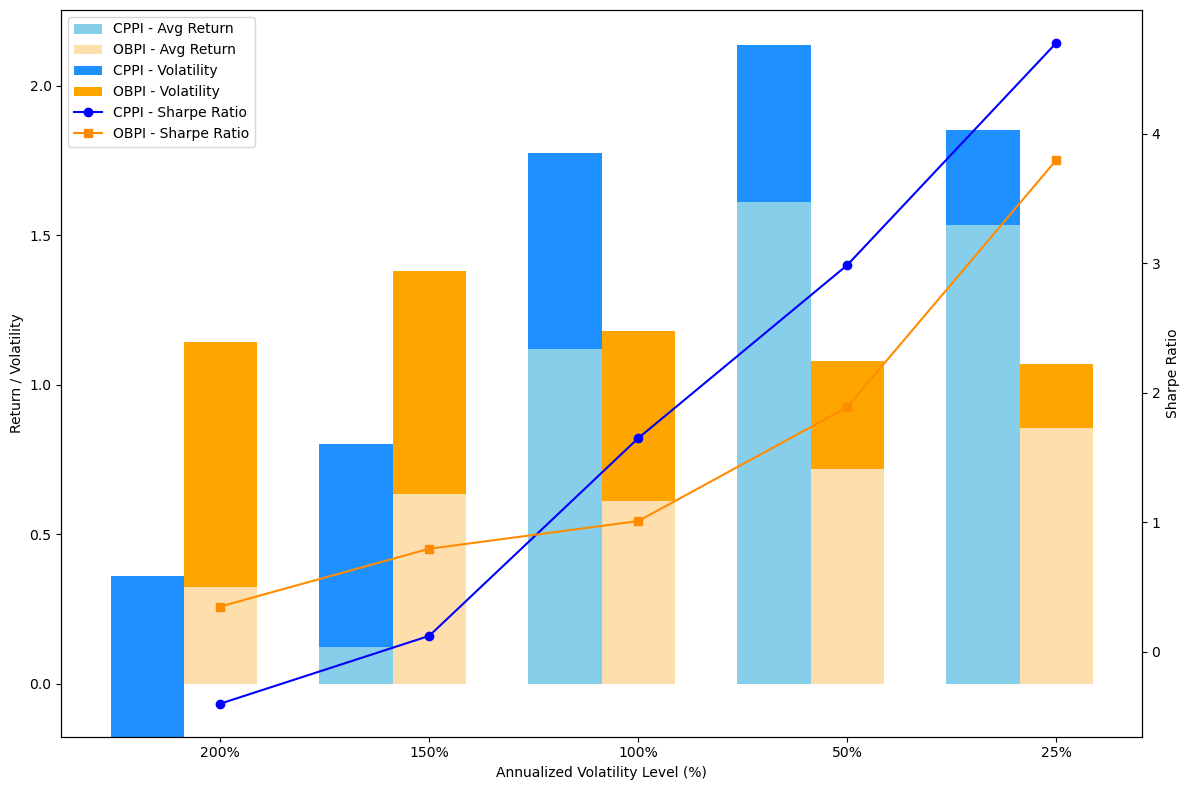

In [364]:
# Prepare data
labels = volatilities_cppi  # Assuming both CPPI and OBPI use the same volatility levels
x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Plot Average Returns
ax.bar(x - width, avg_returns_cppi, width, label='CPPI - Avg Return', color='skyblue')
ax.bar(x, avg_returns_obpi, width, label='OBPI - Avg Return', color='navajowhite')

# Plot Volatility stacked on Average Return
ax.bar(x - width, volatility_cppi, width, bottom=avg_returns_cppi, label='CPPI - Volatility', color='dodgerblue')
ax.bar(x, volatility_obpi, width, bottom=avg_returns_obpi, label='OBPI - Volatility', color='orange')

# Secondary axis for Sharpe Ratios
ax2 = ax.twinx()
ax2.plot(x, sharpe_cppi, marker='o', color='blue', label='CPPI - Sharpe Ratio')
ax2.plot(x, sharpe_obpi, marker='s', color='darkorange', label='OBPI - Sharpe Ratio')

# Labels and title
ax.set_xlabel('Annualized Volatility Level (%)')
ax.set_ylabel('Return / Volatility')
ax2.set_ylabel('Sharpe Ratio')

# X-axis ticks
ax.set_xticks(x)
ax.set_xticklabels([f"{v * 100:.0f}%" for v in labels])

# Legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


### Impact of Floor level

In [454]:
time_to_maturity = len(price_paths) / 365

cppi_results_robustness_floor = cppi_strategy(price_paths, 0.04, [3], floor_fractions, initial_portfolio_value)
obpi_results_robustness_floor = obpi_strategy(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, historical_volatility.iloc[0])

#### CPPI

In [482]:
def compute_metrics_cppi_floor(cppi_results, price_paths, f_values, riskless_rate, m):
    """
    Computes performance and risk metrics for CPPI strategy with a fixed multiplier of 3 across different floor fractions.

    Parameters:
        cppi_results (dict): Output from the cppi_strategy_robustness_rebalancing function, with keys as (multiplier, floor_fraction) tuples.
        f_values (array): Array of floor fractions to consider.
        riskless_rate (float): Annual risk-free rate (default is 0.04).

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio,
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, and max drawdown
              for each floor fraction, for path-level and distribution-level metrics.
    """
    avg_returns = {}
    median_returns = {}
    max_returns = {}
    min_returns = {}
    volatility = {}
    tracking_errors = {}
    sharpe_ratios = {}
    sortino_ratios = {}
    information_ratios = {}
    var_5 = {}
    cvar_5 = {}
    skewness = {}
    excess_kurtosis = {}
    max_drawdowns = {}
    var_5_distribution = {}
    cvar_5_distribution = {}
    skewness_distribution = {}
    excess_kurtosis_distribution = {}
    worst_max_drawdowns = {}
    volatility_distribution = {}

    # Loop through each floor fraction
    for f in f_values:
        if (m, f) in cppi_results:
            basket_values = cppi_results[(m, f)]['Basket Values']  # shape: (n_steps, n_simulations)

            # Calculate returns
            returns = basket_values[1:, :] / basket_values[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
            price_returns = price_paths[1:, :] / price_paths[:-1, :] - 1  # shape: (n_steps-1, n_simulations)

            total_returns = basket_values[-1, :] / basket_values[0, :] - 1  # shape: (n_simulations,)

            # === Path-level Metrics ===

            # Average Return
            avg_returns[f] = np.mean(total_returns)

            # Median Return
            median_returns[f] = np.median(total_returns)

            # Min and Max Returns
            max_returns[f] = np.max(total_returns)
            min_returns[f] = np.min(total_returns)

            # Volatility
            volatility[f] = np.mean(np.std(returns, axis=0, ddof=1)) * np.sqrt(365)

            # === Tracking Error ===
            tracking_error = np.std(returns - price_returns, axis=0, ddof=1) 
            tracking_errors[f] = np.mean(tracking_error) * np.sqrt(365)

            # Sharpe Ratio
            sharpe_ratios[f] = (avg_returns[f] - riskless_rate) / volatility[f] if volatility[f] != 0 else np.nan

            # === Sortino Ratio ===
            downside_returns = np.where(returns < 0, returns, 0)  
            downside_deviation = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(365) if len(downside_returns) > 0 else np.nan
            sortino_ratios[f] = (avg_returns[f] - riskless_rate) / downside_deviation if downside_deviation not in [0, np.nan] else np.nan

            # === Var and CVar (5%) ===
            var_5[f] = np.percentile(returns, 5, axis=0)
            cvar_5[f] = np.array([
                col[col <= v].mean() if np.any(col <= v) else np.nan
                for col, v in zip(returns.T, var_5[f])
            ])
            var_5[f] = np.mean(var_5[f])
            cvar_5[f] = np.mean(cvar_5[f])

            # Skewness
            skewness[f] = np.mean(skew(returns, axis=0, bias=False))

            # Excess Kurtosis
            excess_kurtosis[f] = np.mean(kurtosis(returns, axis=0, fisher=True, bias=False))

            # === Max Drawdown ===
            cumulative = np.cumprod(1 + returns, axis=0)  
            running_max = np.maximum.accumulate(cumulative, axis=0)
            drawdowns = (cumulative - running_max) / running_max
            max_drawdowns[f] = (np.min(drawdowns, axis=0)).mean()
            worst_max_drawdowns[f] = (np.min(drawdowns, axis=0)).min()

            # Information Ratio
            active_returns = returns - price_returns
            active_returns_avg = np.mean(active_returns, axis=0)
            active_returns_tracking_error = np.std(active_returns, axis=0, ddof=1)
            information_ratios[f] = np.mean(active_returns_avg / active_returns_tracking_error)

            # === Distribution Metrics ===

            # === Volatility distribution ===
            volatility_distribution[f] = np.std(total_returns)

            # Value at Risk (5%)
            var_5_distribution[f] = np.percentile(total_returns, 5)

            # Expected Shortfall (Conditional VaR 5%)
            cvar_5_distribution[f] = total_returns[total_returns <= var_5_distribution[f]].mean() if np.any(total_returns <= var_5_distribution[f]) else np.nan

            # Skewness
            skewness_distribution[f] = skew(total_returns, bias=False)

            # Excess Kurtosis
            excess_kurtosis_distribution[f] = kurtosis(total_returns, fisher=True, bias=False)

    return {
        "Average Returns": avg_returns,
        "Median Returns": median_returns,
        "Max Returns": max_returns,
        "Min Returns": min_returns,
        "Volatility": volatility,
        "Tracking Error": tracking_errors,
        "Sharpe Ratios": sharpe_ratios,
        "Sortino Ratios": sortino_ratios,
        "VaR 5%": var_5,
        "Expected Shortfall 5%": cvar_5,
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Max Drawdown": max_drawdowns,
        "Information Ratio": information_ratios,
        "---------------------------------------------": "Distribution Metrics",
        "Volatility Distribution": volatility_distribution,
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Max Drawdown": worst_max_drawdowns
    }

In [483]:
results_cppi = compute_metrics_cppi_floor(cppi_results_robustness_floor, price_paths, f_values=floor_fractions, riskless_rate=0.04, m=3)
results_cppi

{'Average Returns': {0.5: 3.5391230162383907,
  0.6: 2.860613602216862,
  0.7: 2.1821041881953334,
  0.8: 1.503594774173806,
  0.9: 0.825085360152277,
  1: 0.1465759461307489},
 'Median Returns': {0.5: 0.028804380332096646,
  0.6: 0.033409209424093755,
  0.7: 0.03944394455773881,
  0.8: 0.04738245381091677,
  0.9: 0.05353662764877354,
  1: 0.04743825682980518},
 'Max Returns': {0.5: 212.25115108246408,
  0.6: 170.678717555186,
  0.7: 129.10628402790954,
  0.8: 87.53385050063264,
  0.9: 45.96141697335547,
  1: 4.388983446078019},
 'Min Returns': {0.5: -0.49642627786518756,
  0.6: -0.3962144228951594,
  0.7: -0.2961978062470303,
  0.8: -0.19618118959890174,
  0.9: -0.09616457295077241,
  1: 0.0038520436973568106},
 'Volatility': {0.5: 1.1162257948062368,
  0.6: 0.9686599800573865,
  0.7: 0.8136411458850638,
  0.8: 0.6421109544723894,
  0.9: 0.43502979317038015,
  1: 0.10915830737806477},
 'Tracking Error': {0.5: 0.5886030136242845,
  0.6: 0.5140067596723586,
  0.7: 0.4632010421162478,
  

In [457]:
for i in cppi_results_robustness_floor.keys():
    print(turnover(cppi_results_robustness_floor[(i)]['Risky Weights']))

1763.6212412696163
1741.04409177587
1642.418884952256
1447.4986708548115
1099.6525716996086
305.5215899699403


#### OBPI

In [484]:
def compute_metrics_obpi_floor(obpi_results, price_paths, f_values, riskless_rate=0.04):
    """
    Computes performance and risk metrics for OBPI strategy across different floor fractions with a fixed rebalancing frequency.

    Parameters:
        obpi_results (dict): Output from the obpi_strategy_robustness_rebalancing function, with keys as floor fractions.
        f_values (array): Array of floor fractions to consider.
        riskless_rate (float): Annual risk-free rate (default is 0.04).

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio,
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, and max drawdown
              for each floor fraction, for path-level and distribution-level metrics.
    """
    avg_returns = {}
    median_returns = {}
    max_returns = {}
    min_returns = {}
    volatility = {}
    tracking_errors = {}
    sharpe_ratios = {}
    sortino_ratios = {}
    information_ratios = {}
    var_5 = {}
    cvar_5 = {}
    skewness = {}
    excess_kurtosis = {}
    max_drawdowns = {}
    var_5_distribution = {}
    cvar_5_distribution = {}
    skewness_distribution = {}
    excess_kurtosis_distribution = {}
    worst_max_drawdowns = {}
    volatility_distribution = {}

    # Loop through each floor fraction
    for f in f_values:
        if f in obpi_results and 'Basket Values' in obpi_results[f]:
            basket_values = obpi_results[f]['Basket Values']  # shape: (n_steps, n_simulations)

            # Calculate returns
            returns = basket_values[1:, :] / basket_values[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
            price_returns = price_paths[1:, :] / price_paths[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
            
            total_returns = basket_values[-1, :] / basket_values[0, :] - 1  # shape: (n_simulations,)

            # === Path-level Metrics ===

            # Average Return
            avg_returns[f] = np.mean(total_returns)

            # Median Return
            median_returns[f] = np.median(total_returns)

            # Min and Max Returns
            max_returns[f] = np.max(total_returns)
            min_returns[f] = np.min(total_returns)

            # Volatility
            volatility[f] = np.mean(np.std(returns, axis=0, ddof=1)) * np.sqrt(365)

            # === Tracking Error ===
            tracking_error = np.std(returns - price_returns, axis=0, ddof=1) 
            tracking_errors[f] = np.mean(tracking_error) * np.sqrt(365)

            # Sharpe Ratio
            sharpe_ratios[f] = (avg_returns[f] - riskless_rate) / volatility[f] if volatility[f] != 0 else np.nan

            # === Sortino Ratio ===
            downside_returns = np.where(returns < 0, returns, 0)  
            downside_deviation = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(365) if len(downside_returns) > 0 else np.nan
            sortino_ratios[f] = (avg_returns[f] - riskless_rate) / downside_deviation if downside_deviation not in [0, np.nan] else np.nan

            # === Var and CVar (5%) ===
            var_5[f] = np.percentile(returns, 5, axis=0)
            cvar_5[f] = np.array([
                col[col <= v].mean() if np.any(col <= v) else np.nan
                for col, v in zip(returns.T, var_5[f])
            ])
            var_5[f] = np.mean(var_5[f])
            cvar_5[f] = np.mean(cvar_5[f])

            # Skewness
            skewness[f] = np.mean(skew(returns, axis=0, bias=False))

            # Excess Kurtosis
            excess_kurtosis[f] = np.mean(kurtosis(returns, axis=0, fisher=True, bias=False))

            # === Max Drawdown ===
            cumulative = np.cumprod(1 + returns, axis=0)  
            running_max = np.maximum.accumulate(cumulative, axis=0)
            drawdowns = (cumulative - running_max) / running_max
            max_drawdowns[f] = (np.min(drawdowns, axis=0)).mean()
            worst_max_drawdowns[f] = (np.min(drawdowns, axis=0)).min()

            # Information Ratio
            active_returns = returns - price_returns
            active_returns_avg = np.mean(active_returns, axis=0)
            active_returns_tracking_error = np.std(active_returns, axis=0, ddof=1)
            information_ratios[f] = np.mean(active_returns_avg / active_returns_tracking_error)

            # === Distribution Metrics ===

            # === Volatility distribution ===
            volatility_distribution[f] = np.std(total_returns)

            # Value at Risk (5%)
            var_5_distribution[f] = np.percentile(total_returns, 5)

            # Expected Shortfall (Conditional VaR 5%)
            cvar_5_distribution[f] = total_returns[total_returns <= var_5_distribution[f]].mean() if np.any(total_returns <= var_5_distribution[f]) else np.nan

            # Skewness
            skewness_distribution[f] = skew(total_returns, bias=False)

            # Excess Kurtosis
            excess_kurtosis_distribution[f] = kurtosis(total_returns, fisher=True, bias=False)


    return {
        "Average Returns": avg_returns,
        "Median Returns": median_returns,
        "Max Returns": max_returns,
        "Min Returns": min_returns,
        "Volatility": volatility,
        "Tracking Error": tracking_errors,
        "Sharpe Ratios": sharpe_ratios,
        "Sortino Ratios": sortino_ratios,
        "VaR 5%": var_5,
        "Expected Shortfall 5%": cvar_5,
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Max Drawdown": max_drawdowns,
        "Information Ratio": information_ratios,
        "---------------------------------------------": "Distribution Metrics",
        "Volatility Distribution": volatility_distribution,
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Max Drawdown": worst_max_drawdowns
    }

In [485]:
results_obpi = compute_metrics_obpi_floor(obpi_results_robustness_floor, price_paths, f_values=floor_fractions, riskless_rate=0.04)
results_obpi

{'Average Returns': {0.5: 1.0448398345288963,
  0.6: 0.9754418804273775,
  0.7: 0.8982127510173172,
  0.8: 0.8178195016117531,
  0.9: 0.7395276531391276,
  1: 0.6661852635869627},
 'Median Returns': {0.5: 0.5551230331366969,
  0.6: 0.4934873257798159,
  0.7: 0.42313368513688543,
  0.8: 0.35204311087589724,
  0.9: 0.27828682933941107,
  1: 0.2047301303379656},
 'Max Returns': {0.5: 10.575201090077124,
  0.6: 10.132250198110937,
  0.7: 9.620636034258883,
  0.8: 9.074260454734981,
  0.9: 8.520620230144083,
  1: 7.979244308886809},
 'Min Returns': {0.5: -0.45539569429128435,
  0.6: -0.3773941805433121,
  0.7: -0.30443930350881654,
  0.8: -0.2605279521495698,
  0.9: -0.20769260679354395,
  1: -0.15863171208006355},
 'Volatility': {0.5: 0.6208011418159478,
  0.6: 0.5818004469422259,
  0.7: 0.5401617773833854,
  0.8: 0.4981954247641348,
  0.9: 0.4573882021526475,
  1: 0.4185832602129026},
 'Tracking Error': {0.5: 0.10307614806209446,
  0.6: 0.15264629975525523,
  0.7: 0.2032377167052315,
  0.

In [460]:
for i in obpi_results_robustness_floor.keys():
    print(turnover(obpi_results_robustness_floor[(i)]['Risky Weights']))

305.25225717961877
411.49353213075995
496.0317017897829
559.74402700405
601.5673983509305
623.989830102945


#### Analysis

In [461]:
floors_cppi = list(results_cppi["Average Returns"].keys())
floors_obpi = list(results_obpi["Average Returns"].keys())

# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi["Average Returns"][f] for f in floors_cppi]
volatility_cppi = [results_cppi["Volatility"][f] for f in floors_cppi]
sharpe_cppi = [results_cppi["Sharpe Ratios"][f] for f in floors_cppi]

avg_returns_obpi = [results_obpi["Average Returns"][f] for f in floors_obpi]
volatility_obpi = [results_obpi["Volatility"][f] for f in floors_obpi]
sharpe_obpi = [results_obpi["Sharpe Ratios"][f] for f in floors_obpi]

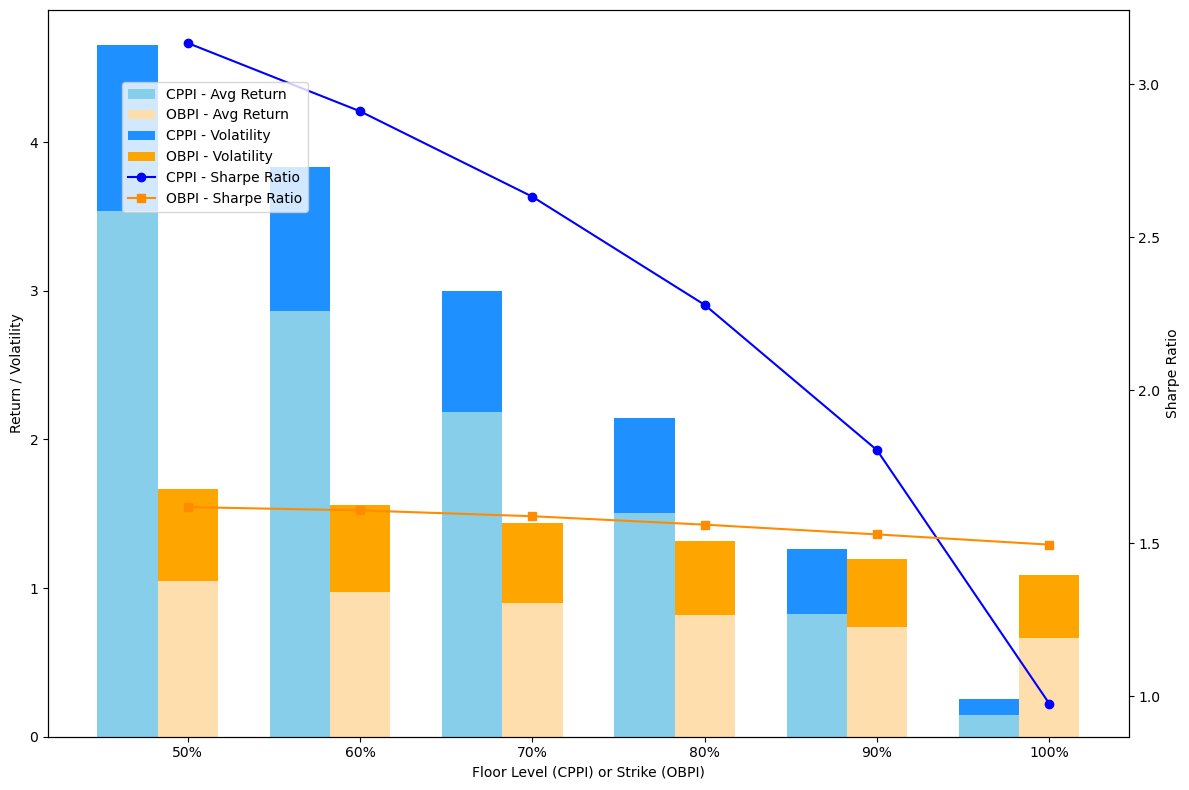

In [462]:
# Prepare data
labels = floors_cppi  # Assuming both CPPI and OBPI use the same floors (or strikes)
x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12, 8))

# Plot average returns
ax.bar(x - width, avg_returns_cppi, width, label='CPPI - Avg Return', color='skyblue')
ax.bar(x, avg_returns_obpi, width, label='OBPI - Avg Return', color='navajowhite')

# Plot volatility
ax.bar(x - width, volatility_cppi, width, bottom=avg_returns_cppi, label='CPPI - Volatility', color='dodgerblue')
ax.bar(x, volatility_obpi, width, bottom=avg_returns_obpi, label='OBPI - Volatility', color='orange')

# Plot Sharpe ratios on a secondary axis to keep scale readable
ax2 = ax.twinx()
ax2.plot(x, sharpe_cppi, marker='o', color='blue', label='CPPI - Sharpe Ratio')
ax2.plot(x, sharpe_obpi, marker='s', color='darkorange', label='OBPI - Sharpe Ratio')

# Labels and Titles
ax.set_xlabel('Floor Level (CPPI) or Strike (OBPI)')
ax.set_ylabel('Return / Volatility')
ax2.set_ylabel('Sharpe Ratio')

# X-axis ticks
ax.set_xticks(x)
ax.set_xticklabels([f"{v*100:.0f}%" for v in labels])

# Legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Layout
plt.tight_layout()
plt.show()

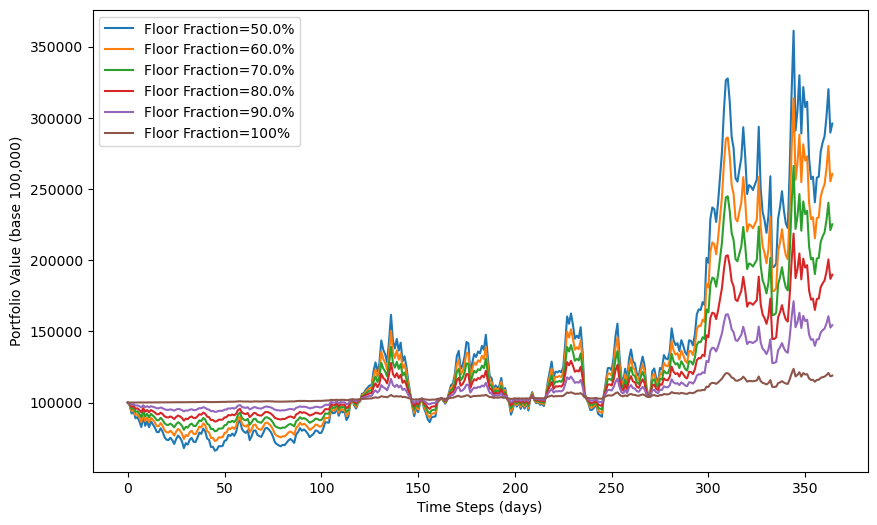

In [344]:
# Plot with multiplier fixed
fixed_multiplier = 3

plt.figure(figsize=(10, 6))

# Filter and plot only results with the fixed multiplier
for key, df in cppi_results_robustness_floor.items():
    # Extract multiplier and floor from the key
    if isinstance(key, tuple) and len(key) == 2:
        multiplier, floor_fraction = key
    else:
        continue  # Skip if key format is unexpected

    # Plot only if the multiplier matches the fixed multiplier
    if multiplier == fixed_multiplier:
        plt.plot(df['Basket Values'].T[7], label=f'Floor Fraction={floor_fraction*100}%')

plt.xlabel('Time Steps (days)')
plt.ylabel('Portfolio Value (base 100,000)')
#plt.title(f'Basket Value Paths for Different Floor Fractions (Multiplier Fixed at {fixed_multiplier})')
plt.legend()
plt.show()

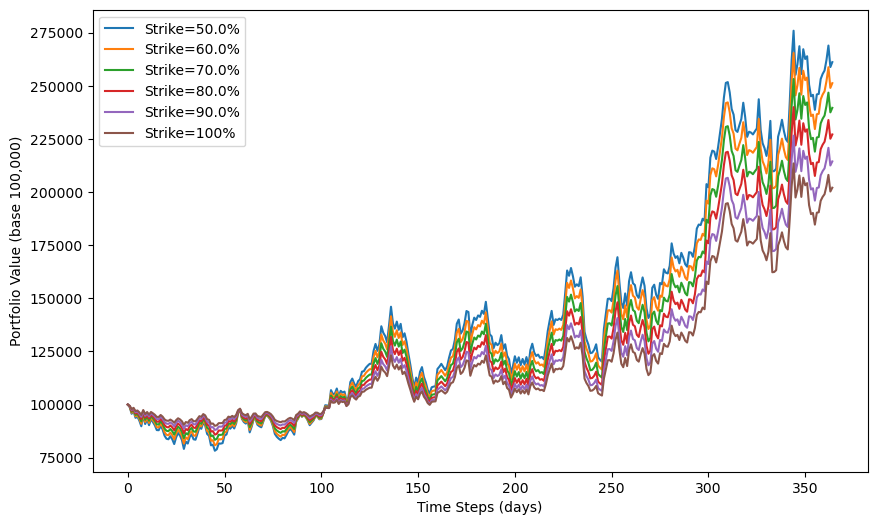

In [345]:
plt.figure(figsize=(10, 6))

# Filter and plot only results with the fixed multiplier
for key, df in obpi_results_robustness_floor.items():
    # Extract multiplier and floor from the key
    floor_fraction = key

    # Plot only if the multiplier matches the fixed multiplier
    
    plt.plot(df['Basket Values'].T[7], label=f'Strike={floor_fraction*100}%')

plt.xlabel('Time Steps (days)')
plt.ylabel('Portfolio Value (base 100,000)')
#plt.title(f'Portfolio Value Paths for Different Floor Fractions (OBPI)')
plt.legend()
plt.show()

### Impact of multiplier (CPPI)

In [346]:
cppi_results_robustness_multiplier = cppi_strategy(price_paths, 0.04, multipliers, [0.8], initial_portfolio_value)

In [486]:
def compute_metrics_cppi_fixed_floor(cppi_results, price_paths, multiplier_values, riskless_rate, fixed_floor):
    """
    Computes performance and risk metrics for CPPI strategy with variable multipliers and a fixed floor of 0.8.

    Parameters:
        cppi_results (dict): Output from the cppi_strategy_robustness_rebalancing function, with keys as (multiplier, floor_fraction) tuples.
        multiplier_values (array): Array of multipliers to consider.
        riskless_rate (float): Annual risk-free rate (default is 0.04).

    Returns:
        dict: Contains average returns, median returns, volatility, Sharpe ratio, Sortino ratio,
              VaR 5%, Expected Shortfall 5%, skewness, excess kurtosis, and max drawdown
              for each multiplier, for path-level and distribution-level metrics.
    """
    avg_returns = {}
    median_returns = {}
    max_returns = {}
    min_returns = {}
    volatility = {}
    tracking_errors = {}
    sharpe_ratios = {}
    sortino_ratios = {}
    information_ratios = {}
    var_5 = {}
    cvar_5 = {}
    skewness = {}
    excess_kurtosis = {}
    max_drawdowns = {}
    var_5_distribution = {}
    cvar_5_distribution = {}
    skewness_distribution = {}
    excess_kurtosis_distribution = {}
    worst_max_drawdowns = {}
    volatility_distribution = {}

    # Loop through each multiplier
    for m in multiplier_values:
        if (m, fixed_floor) in cppi_results:
            basket_values = cppi_results[(m, fixed_floor)]['Basket Values']  # shape: (n_steps, n_simulations)

            # Calculate returns
            returns = basket_values[1:, :] / basket_values[:-1, :] - 1  # shape: (n_steps-1, n_simulations)
            price_returns = price_paths[1:, :] / price_paths[:-1, :] - 1  # shape: (n_steps-1, n_simulations)

            total_returns = basket_values[-1, :] / basket_values[0, :] - 1  # shape: (n_simulations,)

            # === Path-level Metrics ===

            # Average Return
            avg_returns[m] = np.mean(total_returns)

            # Median Return
            median_returns[m] = np.median(total_returns)

            # Min and Max Returns
            max_returns[m] = np.max(total_returns)
            min_returns[m] = np.min(total_returns)

            # Volatility
            volatility[m] = np.mean(np.std(returns, axis=0, ddof=1)) * np.sqrt(365)

            # === Tracking Error ===
            tracking_error = np.std(returns - price_returns, axis=0, ddof=1) 
            tracking_errors[m] = np.mean(tracking_error) * np.sqrt(365)

            # Sharpe Ratio
            sharpe_ratios[m] = (avg_returns[m] - riskless_rate) / volatility[m] if volatility[m] != 0 else np.nan

            # === Sortino Ratio ===
            downside_returns = np.where(returns < 0, returns, 0)  
            downside_deviation = np.mean(np.std(downside_returns, axis=0, ddof=1)) * np.sqrt(365) if len(downside_returns) > 0 else np.nan
            sortino_ratios[m] = (avg_returns[m] - riskless_rate) / downside_deviation if downside_deviation not in [0, np.nan] else np.nan

            # === Var and CVar (5%) ===
            var_5[m] = np.percentile(returns, 5, axis=0)
            cvar_5[m] = np.array([
                col[col <= v].mean() if np.any(col <= v) else np.nan
                for col, v in zip(returns.T, var_5[m])
            ])
            var_5[m] = np.mean(var_5[m])
            cvar_5[m] = np.mean(cvar_5[m])

            # Skewness
            skewness[m] = np.mean(skew(returns, axis=0, bias=False))

            # Excess Kurtosis
            excess_kurtosis[m] = np.mean(kurtosis(returns, axis=0, fisher=True, bias=False))

            # === Max Drawdown ===
            cumulative = np.cumprod(1 + returns, axis=0)  
            running_max = np.maximum.accumulate(cumulative, axis=0)
            drawdowns = (cumulative - running_max) / running_max
            max_drawdowns[m] = (np.min(drawdowns, axis=0)).mean()
            worst_max_drawdowns[m] = (np.min(drawdowns, axis=0)).min()

            # Information Ratio
            active_returns = returns - price_returns
            active_returns_avg = np.mean(active_returns, axis=0)
            active_returns_tracking_error = np.std(active_returns, axis=0, ddof=1)
            information_ratios[m] = np.mean(active_returns_avg / active_returns_tracking_error)

            # === Distribution Metrics ===

            # === Volatility distribution ===
            volatility_distribution[m] = np.std(total_returns)

            # Value at Risk (5%)
            var_5_distribution[m] = np.percentile(total_returns, 5)

            # Expected Shortfall (Conditional VaR 5%)
            cvar_5_distribution[m] = total_returns[total_returns <= var_5_distribution[m]].mean() if np.any(total_returns <= var_5_distribution[m]) else np.nan

            # Skewness
            skewness_distribution[m] = skew(total_returns, bias=False)

            # Excess Kurtosis
            excess_kurtosis_distribution[m] = kurtosis(total_returns, fisher=True, bias=False)


    return {
        "Average Returns": avg_returns,
        "Median Returns": median_returns,
        "Max Returns": max_returns,
        "Min Returns": min_returns,
        "Volatility": volatility,
        "Tracking Error": tracking_errors,
        "Sharpe Ratios": sharpe_ratios,
        "Sortino Ratios": sortino_ratios,
        "VaR 5%": var_5,
        "Expected Shortfall 5%": cvar_5,
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Max Drawdown": max_drawdowns,
        "Information Ratio": information_ratios,
        "---------------------------------------------": "Distribution Metrics",
        "Volatility Distribution": volatility_distribution,
        "VaR 5% Distribution": var_5_distribution,
        "Expected Shortfall 5% Distribution": cvar_5_distribution,
        "Skewness Distribution": skewness_distribution,
        "Excess Kurtosis Distribution": excess_kurtosis_distribution,
        "Worst Max Drawdown": worst_max_drawdowns
    }

In [487]:
results_cppi = compute_metrics_cppi_fixed_floor(cppi_results_robustness_multiplier, price_paths, multipliers, riskless_rate=0.04, fixed_floor=0.8)
results_cppi

{'Average Returns': {1: 0.2786690405202251,
  2: 0.7466985969530813,
  3: 1.503594774173806,
  4: 2.3335270572047313,
  5: 2.6618278148132366,
  6: 2.0839209827195884},
 'Median Returns': {1: 0.17296461009427555,
  2: 0.17324228602147207,
  3: 0.04738245381091677,
  4: -0.08763501904821674,
  5: -0.15549597030407264,
  6: -0.1803305164347197},
 'Max Returns': {1: 2.418723556062345,
  2: 18.759029929545743,
  3: 87.53385050063264,
  4: 255.74959878467973,
  5: 460.179166335988,
  6: 489.9231836659769},
 'Min Returns': {1: -0.14510917678633906,
  2: -0.18708018445942332,
  3: -0.19618118959890174,
  4: -0.19816699065476862,
  5: -0.19881822823445428,
  6: -0.19920037377305166},
 'Volatility': {1: 0.19151749548500982,
  2: 0.42937750199845937,
  3: 0.6421109544723894,
  4: 0.7936792140645745,
  5: 0.8788045049366463,
  6: 0.9071545735097359},
 'Tracking Error': {1: 0.5097814499533126,
  2: 0.3652119474458227,
  3: 0.44659411035218133,
  4: 0.6042677055471496,
  5: 0.7379148551307884,
  6:

In [392]:
for i in cppi_results_robustness_multiplier.keys():
    print(turnover(cppi_results_robustness_multiplier[(i)]['Risky Weights']))

196.68431251786643
737.154021917338
1447.4986708548115
2172.177172665547
2801.9187308982796
3273.5507967604817


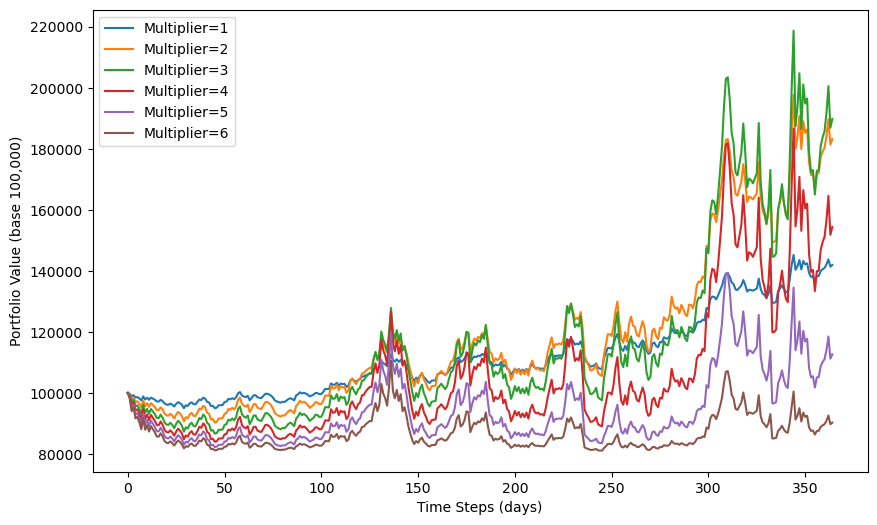

In [351]:
# Plot with floor fixed
fixed_floor = 0.8

plt.figure(figsize=(10, 6))

# Filter and plot only results with the fixed multiplier
for key, df in cppi_results_robustness_multiplier.items():
    # Extract multiplier and floor from the key
    if isinstance(key, tuple) and len(key) == 2:
        multiplier, floor_fraction = key
    else:
        continue  # Skip if key format is unexpected

    # Plot only if the multiplier matches the fixed multiplier
    if floor_fraction == fixed_floor:
        plt.plot(df['Basket Values'].T[7], label=f'Multiplier={multiplier}')

plt.xlabel('Time Steps (days)')
plt.ylabel('Portfolio Value (base 100,000)')
#plt.title(f'Basket Value Paths for Different Floor Fractions (Multiplier Fixed at {fixed_multiplier})')
plt.legend()
plt.show()

In [352]:
# Extract rebalancing frequencies
multipliers_cppi = list(results_cppi["Average Returns"].keys())

# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi["Average Returns"][f] for f in multipliers_cppi]
volatility_cppi = [results_cppi["Volatility"][f] for f in multipliers_cppi]
sharpe_cppi = [results_cppi["Sharpe Ratios"][f] for f in multipliers_cppi]

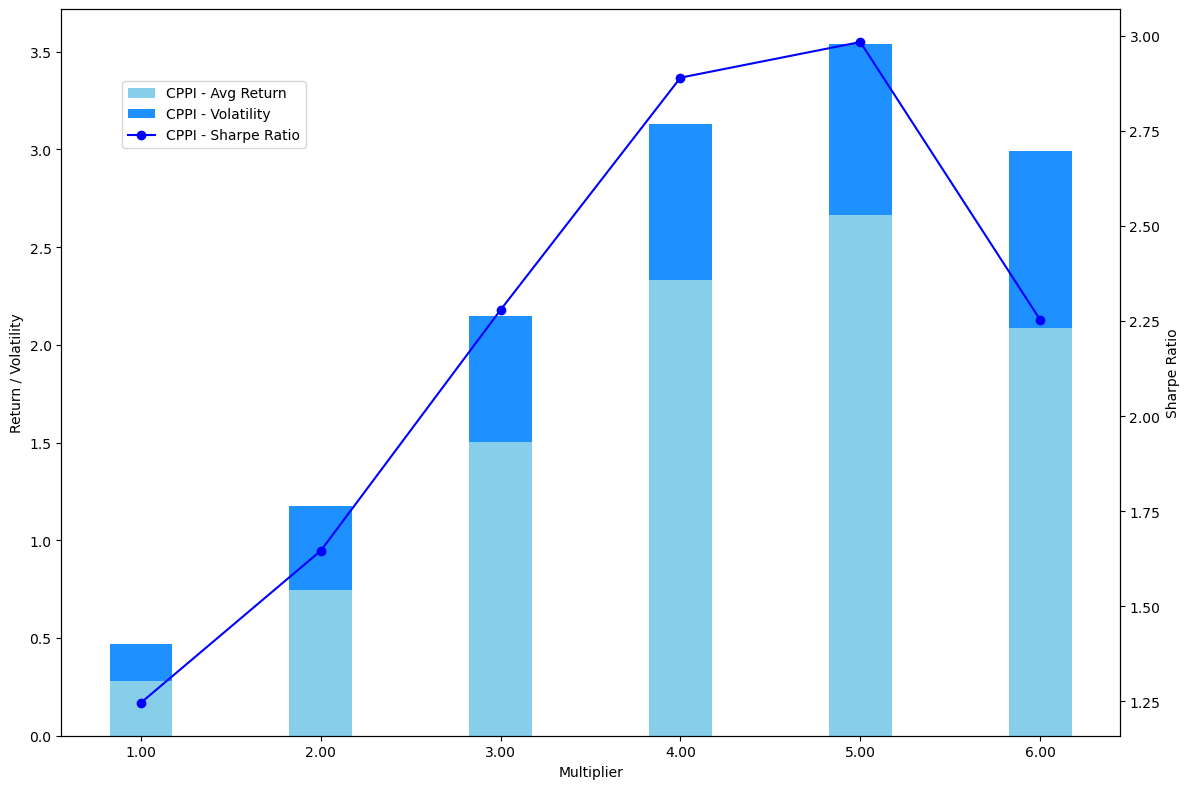

In [353]:
# Prepare data
labels = multipliers_cppi  # Assuming multipliers_cppi contains the multipliers for CPPI
x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12, 8))

# Plot average returns
ax.bar(x, avg_returns_cppi, width, label='CPPI - Avg Return', color='skyblue')

# Plot volatility
ax.bar(x, volatility_cppi, width, bottom=avg_returns_cppi, label='CPPI - Volatility', color='dodgerblue')

# Plot Sharpe ratios on a secondary axis to keep scale readable
ax2 = ax.twinx()
ax2.plot(x, sharpe_cppi, marker='o', color='blue', label='CPPI - Sharpe Ratio')

# Labels and Titles
ax.set_xlabel('Multiplier')
ax.set_ylabel('Return / Volatility')
ax2.set_ylabel('Sharpe Ratio')

# X-axis ticks
ax.set_xticks(x)
ax.set_xticklabels([f"{v:.2f}" for v in labels])

# Legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Layout
plt.tight_layout()
plt.show()


## Extensions to conventional Portfolio Insurance strategies

CPPI extension: Maximum Drawdown (Dynamic Floor)  
OBPI extension: Move Based Rebalancing or Leveraged OBPI

### Maximum Drawdown CPPI

In [503]:
def cppi_mdd_strategy(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements a CPPI (Constant Proportion Portfolio Insurance) strategy with a dynamically 
    updated floor based on Maximum Drawdown (MDD).

    Parameters:
        risky_asset (ndarray): Prices of the risky asset (e.g., BTC), shape (n_steps, n_simulations).
        riskless_rate (float): The constant annual risk-free rate (e.g., 0.02 for 2%).
        multipliers (array-like): Array of multipliers for the cushion.
        floor_fractions (array-like): Array of floor fractions of the peak portfolio value.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing results for each (multiplier, floor_fraction) combination.
    """

    n_steps, n_simulations = risky_asset.shape
    riskless_return = (1 + riskless_rate) ** (1 / 365) - 1

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            # Initialize arrays
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))
            peak_values = np.zeros((n_steps, n_simulations))  # Track the highest portfolio value
            drawdowns = np.zeros((n_steps, n_simulations))  # Track drawdowns

            # Initial conditions
            basket_values[0] = initial_portfolio_value
            peak_values[0] = initial_portfolio_value
            floor = peak_values[0] * floor_fraction  # Dynamic floor based on peak value

            # Compute the initial cushion
            initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
            risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
            riskless_weights[0] = 1 - risky_weights[0]

            # CPPI dynamics for each time step
            for t in range(1, n_steps):
                # Compute risky returns
                risky_returns = (risky_asset[t] - risky_asset[t - 1]) / risky_asset[t - 1]

                # Portfolio return: combine risky and riskless returns
                port_returns = (risky_weights[t-1] * risky_returns + 
                               riskless_weights[t-1] * riskless_return)
                
                # Update portfolio value
                basket_values[t] = basket_values[t-1] * (1 + port_returns)

                # Update peak value and floor dynamically
                peak_values[t] = np.maximum(peak_values[t-1], basket_values[t])
                floor = peak_values[t] * floor_fraction  # Dynamic floor based on max observed value

                # Compute Maximum Drawdown (MDD)
                drawdowns[t] = (peak_values[t] - basket_values[t]) / peak_values[t]

                # Update weights
                cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                risky_weights[t] = np.maximum(multiplier * cushion, 0)
                riskless_weights[t] = 1 - risky_weights[t]

            # Store the results for the current multiplier and floor_fraction
            results[(multiplier, floor_fraction)] = {
                'Basket Values': basket_values,
                'Risky Weights': risky_weights,
                'Riskless Weights': riskless_weights,
                'Peak Values': peak_values,
                'Drawdowns': drawdowns,  # Track the Maximum Drawdown over time
            }

    return results

In [504]:
cppi_results_mdd = cppi_mdd_strategy(price_paths, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [505]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_cppi = cppi_results[key]['Basket Values'][-1]  # Last row of CPPI basket values
terminal_cppi_mdd = cppi_results_mdd[key]['Basket Values'][-1]  # Last row of MDD CPPI basket values

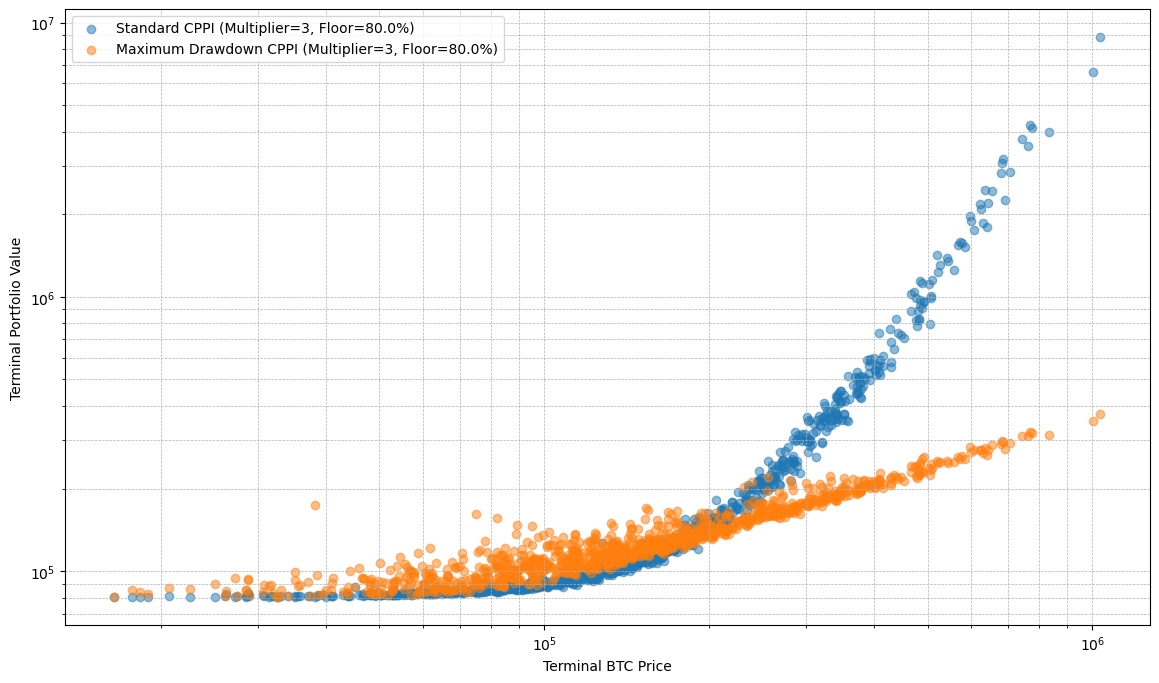

In [506]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'Standard CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# MDD CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi_mdd, 
            alpha=0.5, 
            label=f'Maximum Drawdown CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

#plt.title('Performance of CPPI vs MDD CPPI')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [518]:
benchmark_prices = price_paths

# MDD CPPI Strategy Performance
cppi_strategy_results_mdd = cppi_results_mdd[(3, 0.8)]
cppi_portfolio_values_mdd = np.array(cppi_strategy_results_mdd['Basket Values'])
cppi_metrics_mdd = performance(cppi_portfolio_values_mdd, benchmark_prices)
cppi_turnover_mdd = turnover(cppi_strategy_results_mdd['Risky Weights'])

# CPPI Strategy Performance
cppi_strategy_results = cppi_results[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

print("Maximum Drawdown CPPI Strategy Metrics:")
for metric, value in cppi_metrics_mdd.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {cppi_turnover_mdd:.2f}%\n")

print("Standard CPPI Strategy Metrics:")
for metric, value in cppi_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {cppi_turnover:.2f}%\n")

Maximum Drawdown CPPI Strategy Metrics:
Average Return: 0.3560
Average Volatility: 0.2556
Average Tracking Error: 0.4713
Average Sharpe Ratio: 1.2363
Average Sortino Ratio: 2.1498
Average Var 5%: -0.0207
Average Expected Shortfall 5%: -0.0286
Average Skewness: 0.0906
Average Excess Kurtosis: 2.6276
Average Max Drawdown: -0.1709
Average Information Ratio: -0.0593
---------------------------------------------: Distribution Metrics
Median Return: 0.2219
Maximum Return: 2.7482
Minimum Return: -0.1940
Volatility Distribution: 0.4652
Var 5% Distribution: -0.1444
Expected Shortfall 5% Distribution: -0.1656
Skewness Distribution: 1.4682
Excess Kurtosis Distribution: 2.4377
Worst Max Drawdown: -0.1979
Turnover: 821.10%

Standard CPPI Strategy Metrics:
Average Return: 1.5036
Average Volatility: 0.6421
Average Tracking Error: 0.4466
Average Sharpe Ratio: 2.2793
Average Sortino Ratio: 3.8917
Average Var 5%: -0.0526
Average Expected Shortfall 5%: -0.0734
Average Skewness: -0.0699
Average Excess Kur

In [508]:
print('BTC metrics:')
compute_btc_metrics(price_paths)

BTC metrics:


{'Average Return': 1.1565657312951874,
 'Median Return': 0.6505012262289137,
 'Maximum Return': 11.24569238551118,
 'Minimum Return': -0.8058288664911037,
 'Volatility': 0.6935779516794349,
 'Sharpe Ratio': 1.6098633593982141,
 'Sortino Ratio': 2.8194521269900954,
 'VaR 5%': -0.056383818592624486,
 'Expected Shortfall 5%': -0.07054188943612251,
 'Skewness': 0.10771443798467326,
 'Excess Kurtosis': 0.014420015119730116,
 'Max Drawdown': -0.4612052891481426,
 '---------------------------------------------': 'Distribution Metrics',
 'Volatility Distribution': 1.6339361394523984,
 'VaR 5% Distribution': -0.43178492296348553,
 'Expected Shortfall 5% Distribution': -0.5949900886208972,
 'Skewness Distribution': 1.9401559316665793,
 'Excess Kurtosis Distribution': 5.141800202500633,
 'Worst Max Drawdown Distribution': -0.8909787177151208}

### Leveraged OBPI

In [519]:
def obpi_strategy_leveraged(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma, leverage_factor):
    """
    Implements a Leveraged OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions.

    Parameters:
        risky_asset (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized), 
                                  either a float (constant) or ndarray (n_steps, n_simulations).
        leverage_factor (float): Factor by which the risky asset allocation can be increased (e.g., 1.5 means up to 150%).

    Returns:
        dict: Dictionary containing results for each floor fraction.
    """
    n_steps, n_simulations = risky_asset.shape
    steps_per_year = 365  # adjust for daily rebalancing
    riskless_return = (1 + riskless_rate) ** (1 / steps_per_year) - 1
    dt = 1 / steps_per_year  
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    if np.isscalar(sigma):
        sigma = np.full((n_steps, n_simulations), sigma)

    if sigma.shape != (n_steps, n_simulations):
        raise ValueError("sigma must be either a scalar or have shape (n_steps, n_simulations)")

    for floor_fraction in floor_fractions:
        # Initialize arrays
        basket_values = np.zeros((n_steps, n_simulations))
        risky_weights = np.zeros((n_steps, n_simulations))
        riskless_weights = np.zeros((n_steps, n_simulations))
        put_prices = np.zeros((n_steps, n_simulations))
        put_deltas = np.zeros((n_steps, n_simulations))

        # Initial floor
        floor = initial_portfolio_value * floor_fraction

        # Compute initial put price and delta for all simulations
        initial_put_price, initial_put_delta = black_scholes_put(
            risky_asset[0], floor, time_to_maturity, riskless_rate, sigma[0]
        )

        # Compute initial weights with leverage
        risky_w = leverage_factor * ((1 + initial_put_delta) * risky_asset[0]) / (risky_asset[0] + initial_put_price)
        riskless_w = 1 - risky_w  

        # Allow negative riskless weights (borrowing)
        risky_w = np.maximum(0, risky_w)
        riskless_w = np.minimum(1, riskless_w)  # Ensuring total exposure remains reasonable

        # Set initial values
        basket_values[0, :] = initial_portfolio_value
        risky_weights[0, :] = risky_w
        riskless_weights[0, :] = riskless_w
        put_prices[0, :] = initial_put_price
        put_deltas[0, :] = initial_put_delta

        # Loop over time steps
        for i in range(1, n_steps):
            remaining_ttm = time_to_maturity - i * dt  

            # Compute returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]

            # Update portfolio value
            portfolio_return = (risky_weights[i - 1] * risky_return +
                                riskless_weights[i - 1] * riskless_return)
            basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

            # Compute new put option price and delta 
            put_price, put_delta = black_scholes_put(
                risky_asset[i], floor, remaining_ttm, riskless_rate, sigma[i]
            )

            # Update weights with leverage
            risky_w = leverage_factor * ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)
            riskless_w = 1 - risky_w  

            # Allow for leverage (negative riskless weight = borrowing)
            risky_w = np.maximum(0, risky_w)
            riskless_w = np.minimum(1, riskless_w)  

            # Store values
            risky_weights[i] = risky_w
            riskless_weights[i] = riskless_w
            put_prices[i] = put_price
            put_deltas[i] = put_delta

        # Store results
        results[floor_fraction] = {
            "Basket Values": basket_values,
            "Risky Weights": risky_weights,
            "Riskless Weights": riskless_weights,
            "Put Price": put_prices,
            "Put Delta": put_deltas,
        }

    return results

In [521]:
time_to_maturity = len(price_paths)/365  # adjust (52 for weekly, 365 for daily)
leverage_factor = 1.5

obpi_results_leveraged = obpi_strategy_leveraged(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, historical_volatility.iloc[0], leverage_factor)

In [522]:
floor_frac = 0.9
key = (floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_obpi = obpi_results[key]['Basket Values'][-1]  # Last row of OBPI basket values
terminal_obpi_leveraged = obpi_results_leveraged[key]['Basket Values'][-1]  # Last row of leveraged OBPI basket values

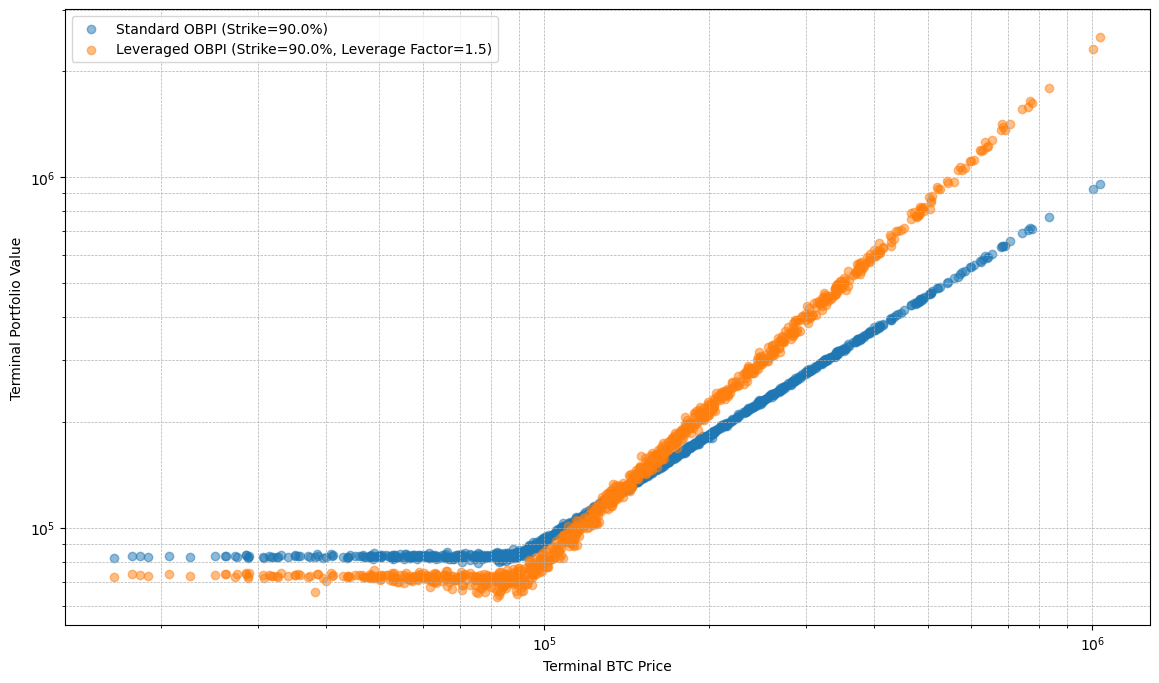

In [523]:
plt.figure(figsize=(14, 8))

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'Standard OBPI (Strike={floor_frac*100}%)')

# Leveraged OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi_leveraged, 
            alpha=0.5, 
            label=f'Leveraged OBPI (Strike={floor_frac*100}%, Leverage Factor={leverage_factor})')

#plt.title('Performance of OBPI vs Leveraged OBPI')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [524]:
benchmark_prices = price_paths

# Leveraged OBPI Strategy Performance
obpi_strategy_results_leveraged = obpi_results_leveraged[(0.9)]
obpi_portfolio_values_leveraged = np.array(obpi_strategy_results_leveraged['Basket Values'])
obpi_metrics_leveraged = performance(obpi_portfolio_values_leveraged, benchmark_prices)
obpi_turnover_leveraged = turnover(obpi_strategy_results_leveraged['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results[(0.9)]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

print("Leveraged OBPI Strategy Metrics:")
for metric, value in obpi_metrics_leveraged.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {obpi_turnover_leveraged:.2f}%\n")

print("Standard OBPI Strategy Metrics:")
for metric, value in obpi_metrics.items():
    if isinstance(value, (int, float)):  # Format only numeric values
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value}")
print(f"Turnover: {obpi_turnover:.2f}%\n")

Leveraged OBPI Strategy Metrics:
Average Return: 1.3253
Average Volatility: 0.6861
Average Tracking Error: 0.2949
Average Sharpe Ratio: 1.8734
Average Sortino Ratio: 3.2840
Average Var 5%: -0.0563
Average Expected Shortfall 5%: -0.0742
Average Skewness: 0.0219
Average Excess Kurtosis: 1.5465
Average Max Drawdown: -0.4593
Average Information Ratio: -0.0117
---------------------------------------------: Distribution Metrics
Median Return: 0.3032
Maximum Return: 24.0365
Minimum Return: -0.3660
Volatility Distribution: 2.6530
Var 5% Distribution: -0.2992
Expected Shortfall 5% Distribution: -0.3226
Skewness Distribution: 3.2872
Excess Kurtosis Distribution: 15.2560
Worst Max Drawdown: -0.8730
Turnover: 902.35%

Standard OBPI Strategy Metrics:
Average Return: 0.7395
Average Volatility: 0.4574
Average Tracking Error: 0.2984
Average Sharpe Ratio: 1.5294
Average Sortino Ratio: 2.6832
Average Var 5%: -0.0375
Average Expected Shortfall 5%: -0.0494
Average Skewness: 0.0219
Average Excess Kurtosis:

In [514]:
print('BTC metrics:')
compute_btc_metrics(price_paths)

BTC metrics:


{'Average Return': 1.1565657312951874,
 'Median Return': 0.6505012262289137,
 'Maximum Return': 11.24569238551118,
 'Minimum Return': -0.8058288664911037,
 'Volatility': 0.6935779516794349,
 'Sharpe Ratio': 1.6098633593982141,
 'Sortino Ratio': 2.8194521269900954,
 'VaR 5%': -0.056383818592624486,
 'Expected Shortfall 5%': -0.07054188943612251,
 'Skewness': 0.10771443798467326,
 'Excess Kurtosis': 0.014420015119730116,
 'Max Drawdown': -0.4612052891481426,
 '---------------------------------------------': 'Distribution Metrics',
 'Volatility Distribution': 1.6339361394523984,
 'VaR 5% Distribution': -0.43178492296348553,
 'Expected Shortfall 5% Distribution': -0.5949900886208972,
 'Skewness Distribution': 1.9401559316665793,
 'Excess Kurtosis Distribution': 5.141800202500633,
 'Worst Max Drawdown Distribution': -0.8909787177151208}

#### Comparison of both extensions

In [515]:
terminal_bnh = bnh_results['Basket Values'][-1]  # Last row of B&H basket values

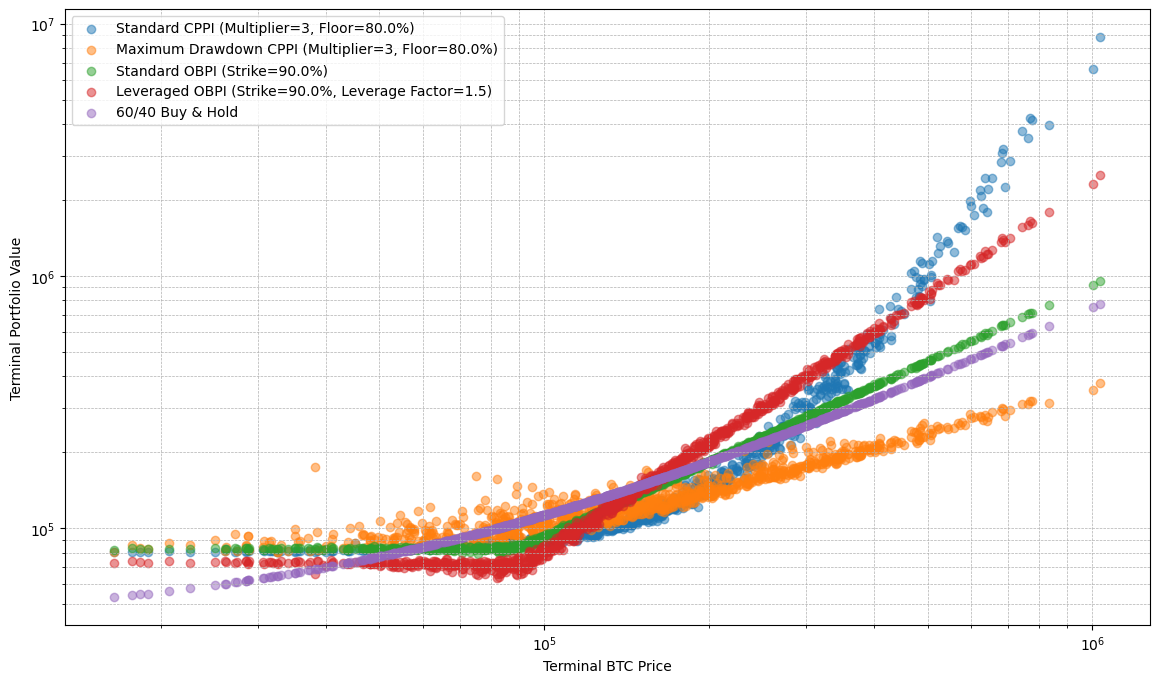

In [516]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'Standard CPPI (Multiplier={multiplier}, Floor={0.8*100}%)')

# MDD CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi_mdd, 
            alpha=0.5, 
            label=f'Maximum Drawdown CPPI (Multiplier={multiplier}, Floor={0.8*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'Standard OBPI (Strike={floor_frac*100}%)')

# Leveraged OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi_leveraged, 
            alpha=0.5, 
            label=f'Leveraged OBPI (Strike={floor_frac*100}%, Leverage Factor={leverage_factor})')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='60/40 Buy & Hold')

#plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#### Move-based rebalancing CPPI and OBPI

In [ ]:
# def cppi_strategy_move_based_rebalancing(
#     risky_asset, riskless_rate, multipliers, floor_fractions, 
#     initial_portfolio_value, move_thresholds
# ):
#     """
#     Implements the CPPI (Constant Proportion Portfolio Insurance) strategy with move-based rebalancing.
#     Now supports testing multiple move thresholds.

#     Parameters:
#         risky_asset (ndarray): Prices of the risky asset, shape (n_steps, n_simulations).
#         riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
#         multipliers (array-like): List of multipliers for the cushion.
#         floor_fractions (array-like): List of floor fractions of the initial portfolio value.
#         initial_portfolio_value (float): Initial value of the portfolio.
#         move_thresholds (array-like): List of percentage changes in risky asset price that trigger rebalancing (e.g., [0.02, 0.05, 0.10]).

#     Returns:
#         dict: A nested dictionary containing results for each (threshold, multiplier, floor_fraction) combination.
#     """

#     n_steps, n_simulations = risky_asset.shape
#     riskless_return = (1 + riskless_rate) ** (1 / 365) - 1  # Daily riskless return

#     results = {}

#     for move_threshold in move_thresholds:  # Loop over different move thresholds
#         results[move_threshold] = {}  # Store results separately for each threshold

#         for multiplier in multipliers:
#             for floor_fraction in floor_fractions:
#                 # Initialize arrays
#                 basket_values = np.zeros((n_steps, n_simulations))
#                 risky_weights = np.zeros((n_steps, n_simulations))
#                 riskless_weights = np.zeros((n_steps, n_simulations))
#                 last_rebalance_price = np.copy(risky_asset[0])  # Track last rebalanced price

#                 # Initial conditions
#                 basket_values[0] = initial_portfolio_value
#                 floor = initial_portfolio_value * floor_fraction

#                 # Compute initial cushion
#                 initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]

#                 # Compute initial weights
#                 risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
#                 riskless_weights[0] = 1 - risky_weights[0]

#                 # CPPI with move-based rebalancing
#                 for t in range(1, n_steps):
#                     # Compute risky asset return
#                     risky_return = (risky_asset[t] - risky_asset[t - 1]) / risky_asset[t - 1]

#                     # Portfolio return: combine risky and riskless returns
#                     port_return = (
#                         risky_weights[t - 1] * risky_return + 
#                         riskless_weights[t - 1] * riskless_return
#                     )

#                     # Update portfolio value
#                     basket_values[t] = basket_values[t - 1] * (1 + port_return) 

#                     # **Move-Based Rebalancing Check**
#                     price_change = np.abs((risky_asset[t] - last_rebalance_price) / last_rebalance_price)
#                     rebalance_indices = price_change >= move_threshold  # Boolean mask for simulations needing rebalancing

#                     # Update last rebalance price for simulations that trigger rebalancing
#                     last_rebalance_price[rebalance_indices] = risky_asset[t, rebalance_indices]

#                     # Recompute cushion and weights for simulations that rebalance
#                     cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
#                     risky_weights[t, rebalance_indices] = np.maximum(multiplier * cushion[rebalance_indices], 0)
#                     riskless_weights[t, rebalance_indices] = 1 - risky_weights[t, rebalance_indices]

#                     # For simulations NOT rebalancing, keep previous weights
#                     risky_weights[t, ~rebalance_indices] = risky_weights[t - 1, ~rebalance_indices]
#                     riskless_weights[t, ~rebalance_indices] = riskless_weights[t - 1, ~rebalance_indices]

#                 # Store results for the given threshold, multiplier, and floor_fraction
#                 results[move_threshold][(multiplier, floor_fraction)] = {
#                     'Basket Values': basket_values,
#                     'Risky Weights': risky_weights,
#                     'Riskless Weights': riskless_weights
#                 }

#     return results

In [162]:
def cppi_strategy_exposure_based_rebalancing(
    risky_asset, riskless_rate, multipliers, floor_fractions, 
    initial_portfolio_value, exposure_thresholds
):
    """
    CPPI strategy with rebalancing triggered by changes in risky exposure (multiplier × cushion).
    
    Parameters:
        risky_asset (ndarray): Prices of the risky asset, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate.
        multipliers (array-like): List of CPPI multipliers.
        floor_fractions (array-like): List of floor levels (as fractions of initial value).
        initial_portfolio_value (float): Initial portfolio value.
        exposure_thresholds (array-like): List of relative exposure change thresholds (e.g., [0.02, 0.05]).

    Returns:
        dict: Nested results per (threshold, multiplier, floor_fraction).
    """

    n_steps, n_simulations = risky_asset.shape
    riskless_return = (1 + riskless_rate) ** (1 / 365) - 1  # Daily compounding

    results = {}

    for exposure_threshold in exposure_thresholds:
        results[exposure_threshold] = {}

        for multiplier in multipliers:
            for floor_fraction in floor_fractions:
                # Initialize arrays
                basket_values = np.zeros((n_steps, n_simulations))
                risky_weights = np.zeros((n_steps, n_simulations))
                riskless_weights = np.zeros((n_steps, n_simulations))
                last_exposure = np.zeros(n_simulations)

                # Initial values
                basket_values[0] = initial_portfolio_value
                floor = initial_portfolio_value * floor_fraction

                cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
                risky_weights[0] = np.maximum(multiplier * cushion, 0)
                riskless_weights[0] = 1 - risky_weights[0]
                last_exposure[:] = basket_values[0] * risky_weights[0]

                # Time loop
                for t in range(1, n_steps):
                    risky_return = (risky_asset[t] - risky_asset[t - 1]) / risky_asset[t - 1]
                    port_return = (
                        risky_weights[t - 1] * risky_return + 
                        riskless_weights[t - 1] * riskless_return
                    )

                    # Update portfolio value
                    basket_values[t] = basket_values[t - 1] * (1 + port_return)

                    # Recalculate cushion
                    cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                    target_exposure = np.maximum(multiplier * cushion * basket_values[t], 0)

                    # Compute relative change in exposure
                    relative_change = np.abs((target_exposure - last_exposure) / (last_exposure + 1e-8))  # avoid divide by zero
                    rebalance_indices = relative_change >= exposure_threshold

                    # Rebalance where needed
                    risky_weights[t, rebalance_indices] = np.maximum(multiplier * cushion[rebalance_indices], 0)
                    riskless_weights[t, rebalance_indices] = 1 - risky_weights[t, rebalance_indices]
                    last_exposure[rebalance_indices] = target_exposure[rebalance_indices]

                    # No rebalancing — keep previous weights
                    risky_weights[t, ~rebalance_indices] = risky_weights[t - 1, ~rebalance_indices]
                    riskless_weights[t, ~rebalance_indices] = riskless_weights[t - 1, ~rebalance_indices]

                # Store results
                results[exposure_threshold][(multiplier, floor_fraction)] = {
                    'Basket Values': basket_values,
                    'Risky Weights': risky_weights,
                    'Riskless Weights': riskless_weights
                }

    return results


In [163]:
move_threshold = [0, 0.01, 0.05, 0.1, 0.2]

cppi_results_move_based_rebalancing = cppi_strategy_exposure_based_rebalancing(price_paths, 0.04, multipliers, floor_fractions, initial_portfolio_value, move_threshold)

In [164]:
move_threshold = 0.05
multiplier = 3
floor_frac = 0.8

key1 = move_threshold 
key2 = (multiplier, floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_cppi = cppi_results[key2]['Basket Values'][-1]  # Last row of CPPI basket values
terminal_cppi_move_based_rebalancing = cppi_results_move_based_rebalancing[key1][key2]['Basket Values'][-1]  # Last row of MDD CPPI basket values

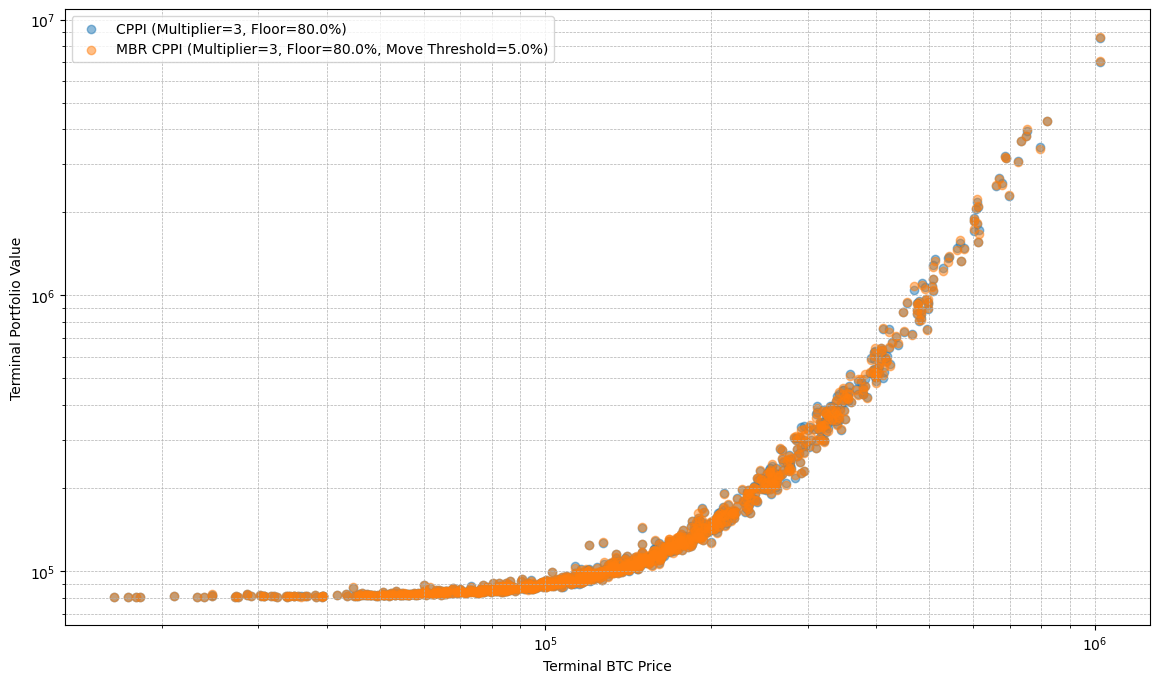

In [165]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# MBR CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi_move_based_rebalancing, 
            alpha=0.5, 
            label=f'MBR CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%, Move Threshold={move_threshold*100}%)')

# plt.title('Performance of CPPI vs MBR CPPI')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [166]:
# benchmark_prices = price_paths

# # MBR CPPI Strategy Performance
# cppi_strategy_results_move_based_rebalancing = cppi_results_move_based_rebalancing[(3, 0.8)]
# cppi_portfolio_values_move_based_rebalancing = np.array(cppi_strategy_results_move_based_rebalancing['Basket Values'])
# cppi_metrics_move_based_rebalancing = performance(cppi_portfolio_values_move_based_rebalancing, benchmark_prices)
# cppi_turnover_move_based_rebalancing = turnover(cppi_strategy_results_move_based_rebalancing['Risky Weights'])

# # CPPI Strategy Performance
# cppi_strategy_results = cppi_results[(3, 0.8)]
# cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
# cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
# cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# # Display Results
# def print_metrics(name, metrics, turnover):
#     print(f"{name} Strategy Metrics:")
#     for metric, value in metrics.items():
#         print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
#     print(f"Turnover: {turnover:.2f}%\n")

# print_metrics("move_based_rebalancing CPPI", cppi_metrics_move_based_rebalancing, cppi_turnover_move_based_rebalancing)
# print_metrics("CPPI", cppi_metrics, cppi_turnover)

In [167]:
# Extract move thresholds used in the strategy
move_thresholds = list(cppi_results_move_based_rebalancing.keys())

# Initialize dictionaries to store performance metrics
avg_returns_move_cppi = {}
volatility_move_cppi = {}
sharpe_move_cppi = {}

# Loop through each move threshold and compute performance metrics
for threshold in move_thresholds:
    # Extract final portfolio values
    terminal_values = cppi_results_move_based_rebalancing[threshold][key2]['Basket Values'][-1]

    # Compute performance metrics
    avg_returns_move_cppi[threshold] = np.mean(terminal_values) / initial_portfolio_value - 1  # Average return
    volatility_move_cppi[threshold] = np.std(terminal_values / initial_portfolio_value)  # Volatility
    sharpe_move_cppi[threshold] = avg_returns_move_cppi[threshold] / volatility_move_cppi[threshold]  # Sharpe ratio

# Convert to lists for easy plotting
thresholds = list(avg_returns_move_cppi.keys())
avg_returns_list = [avg_returns_move_cppi[t] for t in thresholds]
volatility_list = [volatility_move_cppi[t] for t in thresholds]
sharpe_list = [sharpe_move_cppi[t] for t in thresholds]

In [168]:
def compute_metrics_move_cppi_fixed_floor(cppi_results_move_based_rebalancing, m=3, riskless_rate=0.04, floor=0.8):
    """
    Computes the average return, volatility, and Sharpe ratio for a fixed floor fraction (0.8)
    across different move-based rebalancing thresholds for a specific multiplier.

    Parameters:
        cppi_results_move_based_rebalancing (dict): Output from the move-based CPPI strategy function.
                                                    Expected keys: {move_threshold: {(m, floor): results_dict}}.
        m (int or float): The multiplier to analyze (e.g., 3).
        riskless_rate (float): The annual risk-free rate (e.g., 0.04 for 4%).
        floor (float): The fixed floor fraction to analyze (default = 0.8).

    Returns:
        dict: A dictionary containing average returns, volatility, and Sharpe ratios for each move threshold.
    """
    avg_returns = {}
    volatility = {}
    sharpe_ratios = {}

    # Loop through different move thresholds in the results
    for move_threshold, threshold_results in cppi_results_move_based_rebalancing.items():
        key = (m, floor)  # Fixed floor

        # Ensure the key exists
        if key not in threshold_results:
            continue

        # Extract basket values (portfolio values over time)
        basket_values = threshold_results[key]['Basket Values']

        # Ensure basket_values has the expected shape (n_steps, n_simulations)
        if basket_values.ndim != 2:
            raise ValueError("Basket values must be a 2D array (n_steps, n_simulations)")

        # Compute returns across time (percentage change)
        basket_values_ret = basket_values[1:] / basket_values[:-1] - 1  # (n_steps - 1, n_simulations)

        # Compute the final and initial values for each simulation
        final_values = basket_values[-1, :]  # Final value for each simulation
        initial_values = basket_values[0, :]  # Initial value for each simulation

        # Compute cumulative returns for each simulation
        returns = (final_values - initial_values) / initial_values

        # Calculate average return across simulations
        avg_returns[move_threshold] = np.mean(returns)

        # Calculate volatility (Annualized standard deviation of returns)
        volatility[move_threshold] = np.mean(np.std(basket_values_ret, axis=1)) * np.sqrt(365)

        # Calculate Sharpe ratio: (Excess return) / Volatility
        sharpe_ratios[move_threshold] = (
            (avg_returns[move_threshold] - riskless_rate) / volatility[move_threshold]
            if volatility[move_threshold] > 0 else np.nan
        )

    # Return the computed metrics
    return {
        "Average Returns": avg_returns,
        "Volatility": volatility,
        "Sharpe Ratios": sharpe_ratios
    }

In [169]:
for threshold in thresholds:
    print(f'{threshold}: {np.round(turnover(cppi_results_move_based_rebalancing[threshold][key2]["Risky Weights"]), 2)}')

0: 1451.16
0.01: 1445.16
0.05: 1324.15
0.1: 1081.37
0.2: 718.76


In [170]:
results_cppi = compute_metrics_move_cppi_fixed_floor(cppi_results_move_based_rebalancing)

# Print the results_cppi
print("Average Returns:", results_cppi["Average Returns"])
print("Volatility:", results_cppi["Volatility"])
print("Sharpe Ratios:", results_cppi["Sharpe Ratios"])

Average Returns: {0: 1.5007454413809258, 0.01: 1.5008393516604062, 0.05: 1.5014916689075173, 0.1: 1.4999889690867698, 0.2: 1.5032913497428508}
Volatility: {0: 0.7335481142490773, 0.01: 0.733551963084837, 0.05: 0.7337172814810344, 0.1: 0.7333918585042718, 0.2: 0.7338170126149993}
Sharpe Ratios: {0: 1.9913423714220437, 0.01: 1.9914599444558456, 0.05: 1.9919002942897084, 0.1: 1.9907351740505663, 0.2: 1.9940820730338855}


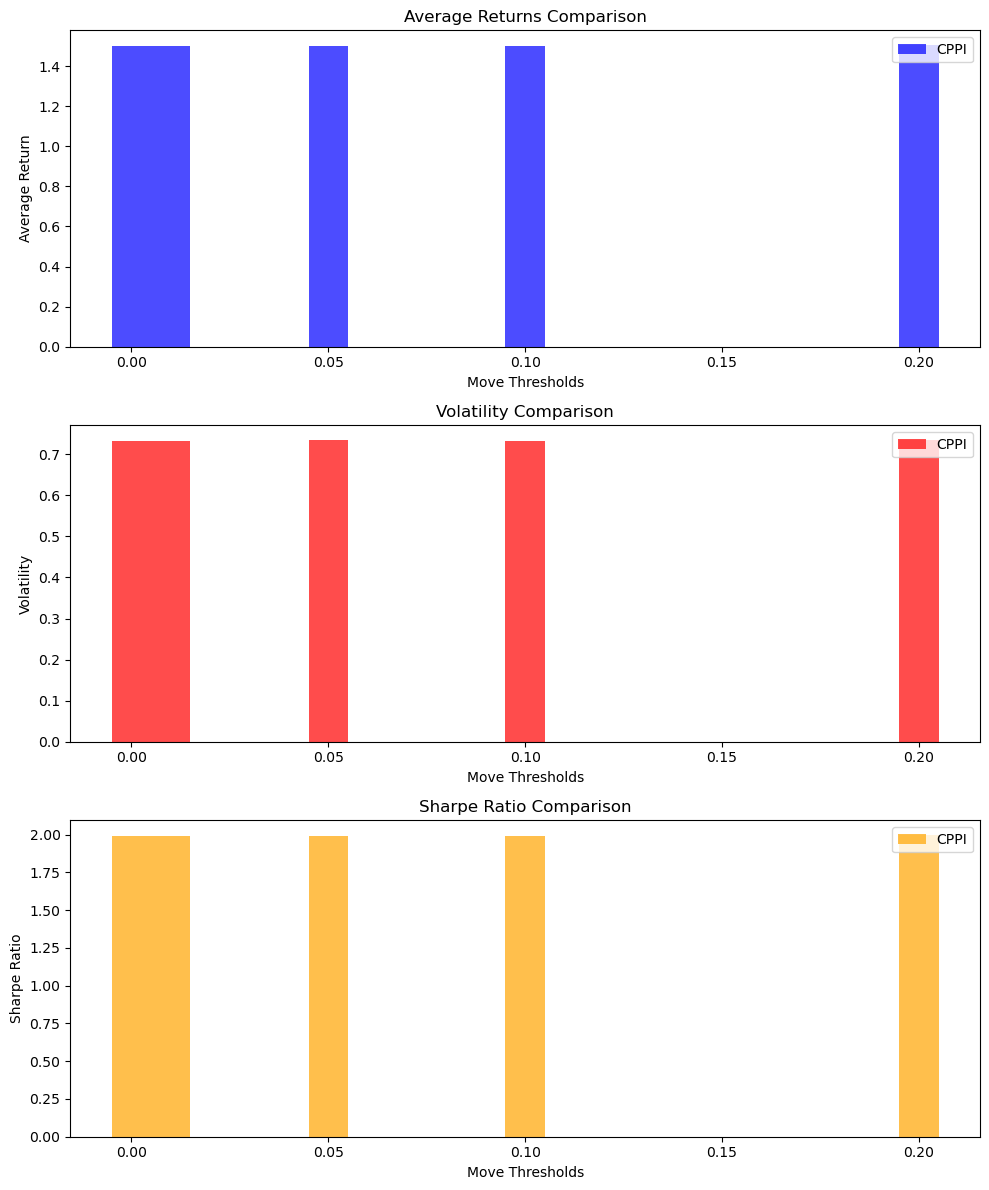

In [171]:
# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi["Average Returns"][f] for f in move_thresholds]
volatility_cppi = [results_cppi["Volatility"][f] for f in move_thresholds]
sharpe_cppi = [results_cppi["Sharpe Ratios"][f] for f in move_thresholds]

# Create subplots: 3 rows for Average Return, Volatility, and Sharpe Ratio
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Bar chart for Average Returns
axes[0].bar(move_thresholds, avg_returns_cppi, width=0.01, label='CPPI', alpha=0.7, color='blue')
axes[0].set_title('Average Returns Comparison')
axes[0].set_xlabel('Move Thresholds')
axes[0].set_ylabel('Average Return')
axes[0].legend()

# Bar chart for Volatility
axes[1].bar(move_thresholds, volatility_cppi, width=0.01, label='CPPI', alpha=0.7, color='red')
axes[1].set_title('Volatility Comparison')
axes[1].set_xlabel('Move Thresholds')
axes[1].set_ylabel('Volatility')
axes[1].legend()

# Bar chart for Sharpe Ratios
axes[2].bar(move_thresholds, sharpe_cppi, width=0.01, label='CPPI', alpha=0.7, color='orange')
axes[2].set_title('Sharpe Ratio Comparison')
axes[2].set_xlabel('Move Thresholds')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].legend()

plt.tight_layout()
plt.show()

In [172]:
print('BTC metrics:')
compute_btc_metrics(price_paths)

BTC metrics:


{'Annualized Return': '174.40%',
 'Annualized Volatility': '69.36%',
 'Sharpe Ratio': '2.51',
 'Sortino Ratio': '4.49',
 'VaR (5%)': '-5.59%',
 'Expected Shortfall (5%)': '-6.95%',
 'Skewness': '0.11',
 'Kurtosis': '-0.00',
 'Max Drawdown': '-46.16%'}

In [173]:
# plt.figure(figsize=(14, 8))

# # CPPI Outcomes 
# plt.scatter(terminal_prices, terminal_cppi, 
#             alpha=0.5, 
#             label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# # MBR CPPI Outcomes 
# plt.scatter(terminal_prices, terminal_cppi_move_based_rebalancing, 
#             alpha=0.5, 
#             label=f'MBR CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# # MDD CPPI Outcomes 
# plt.scatter(terminal_prices, terminal_cppi_mdd, 
#             alpha=0.5, 
#             label=f'MDD CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# plt.title('Performance of CPPI vs MBR CPPI vs MDD CPPI')
# plt.xlabel('Terminal Asset Price')
# plt.xscale('log')  # Use log scale for better visualization
# plt.ylabel('Terminal Portfolio Value')
# plt.yscale('log')
# plt.legend()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.show()

##### OBPI Move-based

In [174]:
def obpi_strategy_move_based_rebalancing(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, 
                                         time_to_maturity, sigma, delta_thresholds):
    """
    Implements the Move-Based OBPI (Option-Based Portfolio Insurance) strategy for multiple delta thresholds.
    
    Parameters:
        risky_asset (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized).
        delta_thresholds (list or array): Array of threshold values for move-based rebalancing.

    Returns:
        dict: Dictionary containing results for each (floor fraction, delta threshold) combination.
    """
    n_steps, n_simulations = risky_asset.shape
    steps_per_year = 365  # Adjust as needed
    riskless_return = (1 + riskless_rate) ** (1 / steps_per_year) - 1
    dt = 1 / steps_per_year  
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        """ Computes Black-Scholes European put price and delta. """
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    # Ensure sigma is an array of correct shape (n_steps, n_simulations)
    if np.isscalar(sigma):
        sigma = np.full((n_steps, n_simulations), sigma)

    if sigma.shape != (n_steps, n_simulations):
        raise ValueError("sigma must be either a scalar or have shape (n_steps, n_simulations)")

    # Loop over each delta threshold
    for delta_threshold in delta_thresholds:
        results[delta_threshold] = {}

        for floor_fraction in floor_fractions:
            # Initialize arrays
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))
            put_prices = np.zeros((n_steps, n_simulations))
            put_deltas = np.zeros((n_steps, n_simulations))

            # Initial conditions
            floor = initial_portfolio_value * floor_fraction

            # Compute initial put price and delta for all simulations
            initial_put_price, initial_put_delta = black_scholes_put(
                risky_asset[0], floor, time_to_maturity, riskless_rate, sigma[0]
            )

            # Compute initial weights
            risky_w = ((1 + initial_put_delta) * risky_asset[0]) / (risky_asset[0] + initial_put_price)
            risky_w = np.clip(risky_w, 0, 1)  # Ensure weights are between 0 and 1
            riskless_w = 1 - risky_w

            # Set initial values
            basket_values[0, :] = initial_portfolio_value
            risky_weights[0, :] = risky_w
            riskless_weights[0, :] = riskless_w
            put_prices[0, :] = initial_put_price
            put_deltas[0, :] = initial_put_delta
            previous_put_delta = initial_put_delta.copy()  # Track the previous delta

            # Loop over time steps
            for i in range(1, n_steps):
                remaining_ttm = time_to_maturity - i * dt  

                # Compute returns
                risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]

                # Update portfolio value
                portfolio_return = (risky_weights[i - 1] * risky_return +
                                    riskless_weights[i - 1] * riskless_return)
                basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

                # Compute new put option price and delta
                put_price, put_delta = black_scholes_put(
                    risky_asset[i], floor, remaining_ttm, riskless_rate, sigma[i]
                )

                # Compute the absolute change in put delta
                delta_change = np.abs(put_delta - previous_put_delta)

                # Boolean mask: True where the change exceeds the threshold
                rebalance_mask = delta_change > delta_threshold

                # Rebalance only where needed
                risky_w[rebalance_mask] = ((1 + put_delta[rebalance_mask]) * risky_asset[i, rebalance_mask]) / (
                    risky_asset[i, rebalance_mask] + put_price[rebalance_mask]
                )
                risky_w = np.clip(risky_w, 0, 1)  # Ensure weights remain valid
                riskless_w = 1 - risky_w

                # Update previous put delta only for rebalanced elements
                previous_put_delta[rebalance_mask] = put_delta[rebalance_mask]

                # Store values
                risky_weights[i] = risky_w
                riskless_weights[i] = riskless_w
                put_prices[i] = put_price
                put_deltas[i] = put_delta

            # Store results
            results[delta_threshold][floor_fraction] = {
                "Basket Values": basket_values,
                "Risky Weights": risky_weights,
                "Riskless Weights": riskless_weights,
                "Put Price": put_prices,
                "Put Delta": put_deltas,
            }

    return results

In [175]:
time_to_maturity = len(price_paths)/365  # adjust (52 for weekly, 365 for daily)
delta_thresholds = [0, 0.01, 0.05, 0.1, 0.25, 0.5]

obpi_results_move_based_rebalancing = obpi_strategy_move_based_rebalancing(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, historical_volatility.iloc[0], delta_thresholds)

In [176]:
floor_frac = 1
delta_threshold = 0.05

key1 = delta_threshold
key2 = floor_frac

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_obpi = obpi_results[key2]['Basket Values'][-1]  # Last row of OBPI basket values
terminal_obpi_move_based_rebalancing = obpi_results_move_based_rebalancing[key1][key2]['Basket Values'][-1]  # Last row of leveraged OBPI basket values

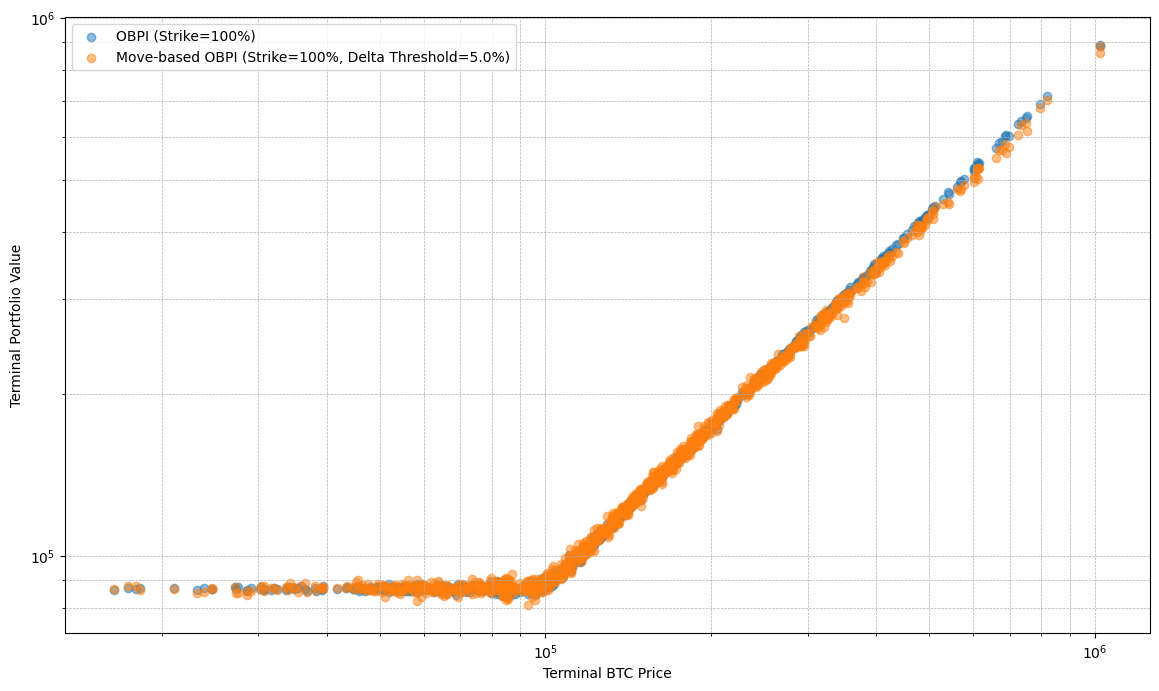

In [177]:
plt.figure(figsize=(14, 8))

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Strike={floor_frac*100}%)')

# Move-based OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi_move_based_rebalancing, 
            alpha=0.5, 
            label=f'Move-based OBPI (Strike={floor_frac*100}%, Delta Threshold={delta_threshold*100}%)')

# plt.title('Performance of OBPI vs Move-based OBPI')
plt.xlabel('Terminal BTC Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [178]:
# Extract move thresholds used in the strategy
delta_thresholds = list(obpi_results_move_based_rebalancing.keys())

# Initialize dictionaries to store performance metrics
avg_returns_move_obpi = {}
volatility_move_obpi = {}
sharpe_move_obpi = {}

# Loop through each move threshold and compute performance metrics
for delta_threshold in delta_thresholds:
    # Extract final portfolio values
    terminal_values = obpi_results_move_based_rebalancing[delta_threshold][key2]['Basket Values'][-1]

    # Compute performance metrics
    avg_returns_move_obpi[delta_threshold] = np.mean(terminal_values) / initial_portfolio_value - 1  # Average return
    volatility_move_obpi[delta_threshold] = np.std(terminal_values / initial_portfolio_value)  # Volatility
    sharpe_move_obpi[delta_threshold] = avg_returns_move_obpi[delta_threshold] / volatility_move_obpi[delta_threshold]  # Sharpe ratio

# Convert to lists for easy plotting
delta_thresholds = list(avg_returns_move_obpi.keys())
avg_returns_list = [avg_returns_move_obpi[t] for t in delta_thresholds]
volatility_list = [volatility_move_obpi[t] for t in delta_thresholds]
sharpe_list = [sharpe_move_obpi[t] for t in delta_thresholds]

In [179]:
def compute_metrics_move_obpi_fixed_floor(obpi_results_move_based_rebalancing, riskless_rate=0.04, floor=1):
    """
    Computes the average return, volatility, and Sharpe ratio for a fixed floor fraction (0.8)
    across different move-based rebalancing thresholds for a specific multiplier.

    Parameters:
        cppi_results_move_based_rebalancing (dict): Output from the move-based CPPI strategy function.
                                                    Expected keys: {move_threshold: {(m, floor): results_dict}}.
        m (int or float): The multiplier to analyze (e.g., 3).
        riskless_rate (float): The annual risk-free rate (e.g., 0.04 for 4%).
        floor (float): The fixed floor fraction to analyze (default = 0.8).

    Returns:
        dict: A dictionary containing average returns, volatility, and Sharpe ratios for each move threshold.
    """
    avg_returns = {}
    volatility = {}
    sharpe_ratios = {}

    # Loop through different move thresholds in the results
    for delta_threshold, threshold_results in obpi_results_move_based_rebalancing.items():
        key = floor  # Fixed floor

        # Ensure the key exists
        if key not in threshold_results:
            continue

        # Extract basket values (portfolio values over time)
        basket_values = threshold_results[key]['Basket Values']

        # Ensure basket_values has the expected shape (n_steps, n_simulations)
        if basket_values.ndim != 2:
            raise ValueError("Basket values must be a 2D array (n_steps, n_simulations)")

        # Compute returns across time (percentage change)
        basket_values_ret = basket_values[1:] / basket_values[:-1] - 1  # (n_steps - 1, n_simulations)

        # Compute the final and initial values for each simulation
        final_values = basket_values[-1, :]  # Final value for each simulation
        initial_values = basket_values[0, :]  # Initial value for each simulation

        # Compute cumulative returns for each simulation
        returns = (final_values - initial_values) / initial_values

        # Calculate average return across simulations
        avg_returns[delta_threshold] = np.mean(returns)

        # Calculate volatility (Annualized standard deviation of returns)
        volatility[delta_threshold] = np.mean(np.std(basket_values_ret, axis=1)) * np.sqrt(365)

        # Calculate Sharpe ratio: (Excess return) / Volatility
        sharpe_ratios[delta_threshold] = (
            (avg_returns[delta_threshold] - riskless_rate) / volatility[delta_threshold]
            if volatility[delta_threshold] > 0 else np.nan
        )

    # Return the computed metrics
    return {
        "Average Returns": avg_returns,
        "Volatility": volatility,
        "Sharpe Ratios": sharpe_ratios
    }



In [180]:
for delta_threshold in delta_thresholds:
    print(f'{delta_threshold}: {np.round(turnover(obpi_results_move_based_rebalancing[delta_threshold][key2]["Risky Weights"]),2)}')

0: 624.78
0.01: 569.87
0.05: 299.25
0.1: 181.72
0.25: 76.19
0.5: 14.18


In [181]:
results_obpi = compute_metrics_move_obpi_fixed_floor(obpi_results_move_based_rebalancing)

# Print the results_obpi
print("Average Returns:", results_obpi["Average Returns"])
print("Volatility:", results_obpi["Volatility"])
print("Sharpe Ratios:", results_obpi["Sharpe Ratios"])

Average Returns: {0: 0.6684356134243258, 0.01: 0.6665290367431737, 0.05: 0.6567410501265306, 0.1: 0.6379622500152967, 0.25: 0.5550031254066119, 0.5: 0.38816946875801805}
Volatility: {0: 0.4404331180369465, 0.01: 0.43976937076617567, 0.05: 0.4344329883536974, 0.1: 0.4251207203966113, 0.25: 0.38153964925877665, 0.5: 0.27634145708315755}
Sharpe Ratios: {0: 1.4268582168055952, 0.01: 1.4246763835590033, 0.05: 1.4196459906594512, 0.1: 1.4065704665193335, 0.25: 1.349802376783427, 0.5: 1.2599248496154734}


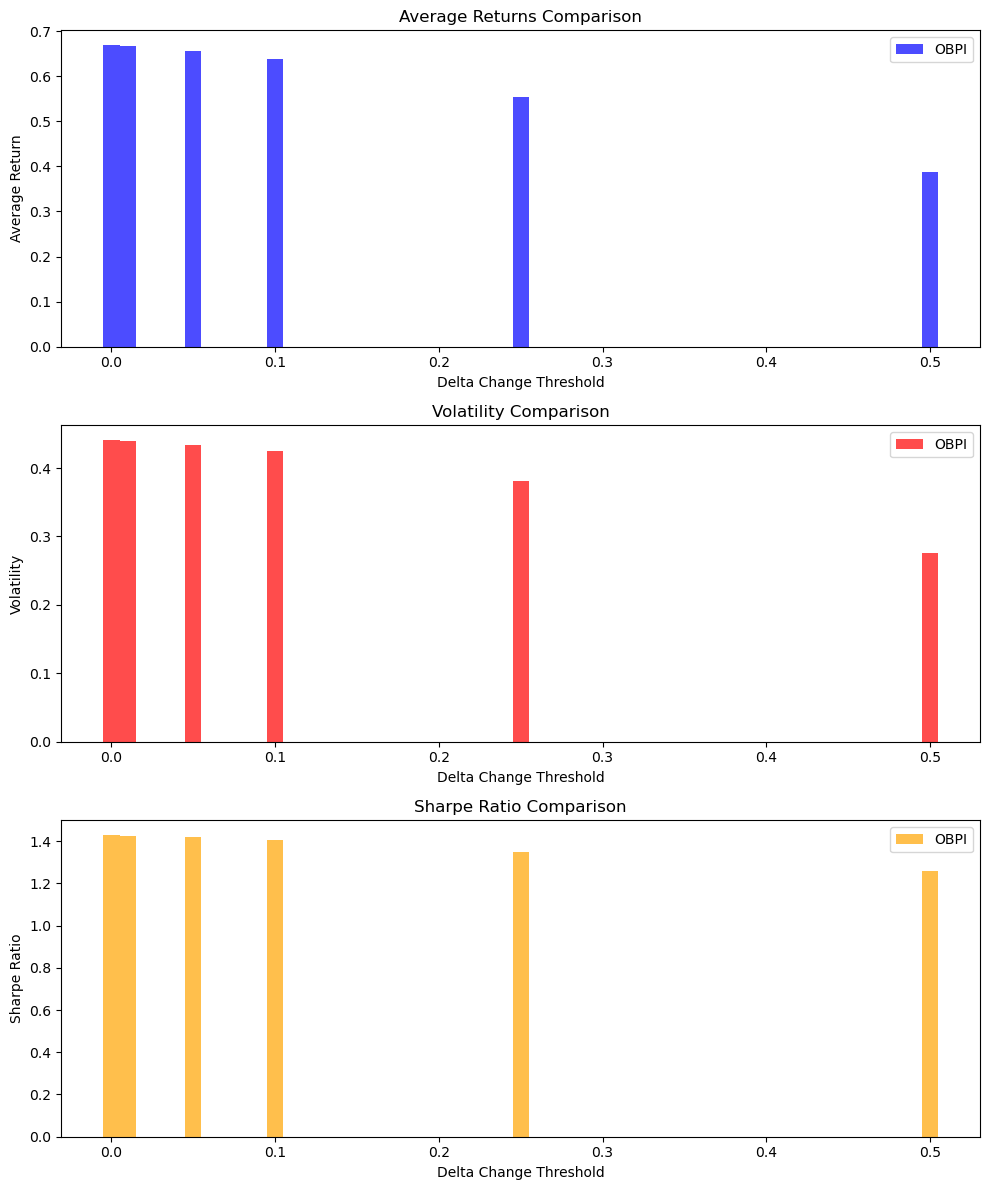

In [182]:
# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_obpi = [results_obpi["Average Returns"][f] for f in delta_thresholds]
volatility_obpi = [results_obpi["Volatility"][f] for f in delta_thresholds]
sharpe_obpi = [results_obpi["Sharpe Ratios"][f] for f in delta_thresholds]

# Create subplots: 3 rows for Average Return, Volatility, and Sharpe Ratio
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Bar chart for Average Returns
axes[0].bar(delta_thresholds, avg_returns_obpi, width=0.01, label='OBPI', alpha=0.7, color='blue')
axes[0].set_title('Average Returns Comparison')
axes[0].set_xlabel('Delta Change Threshold')
axes[0].set_ylabel('Average Return')
axes[0].legend()

# Bar chart for Volatility
axes[1].bar(delta_thresholds, volatility_obpi, width=0.01, label='OBPI', alpha=0.7, color='red')
axes[1].set_title('Volatility Comparison')
axes[1].set_xlabel('Delta Change Threshold')
axes[1].set_ylabel('Volatility')
axes[1].legend()

# Bar chart for Sharpe Ratios
axes[2].bar(delta_thresholds, sharpe_obpi, width=0.01, label='OBPI', alpha=0.7, color='orange')
axes[2].set_title('Sharpe Ratio Comparison')
axes[2].set_xlabel('Delta Change Threshold')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].legend()

plt.tight_layout()
plt.show()